# ABC with the OpenCL RAMP model

Multi-paramter calibration of the RAMP model using Approximate Bayesian Computation.

Calibrates on the individual hazard multipliers:
 - current_risk_beta
 - presymptomatic
 - asymptomatic
 - symptomatic
 
For a full list of parameters used in the model, see the default parameters file '[default.yml](../../model_parameters/default.yml)'.

Note about libraries:

 - Use [pyabc](https://pyabc.readthedocs.io/) (listed in [pythonMCMC](https://gabriel-p.github.io/pythonMCMC/)).

Note about installing. It is annoying. I did: 
```
conda install mpi4py
pip install pyabc
```
but also had to follow the first proposed solution [here](https://github.com/ipython/ipyparallel/issues/349) (reinstall setuptools and numpy).

Then I got a really annoying error about "`ValueError: Cell is empty`" which happened to be a pickle problem and was resolved by installing older versions: `cloudpickle==1.4.1 distributed==2.17.0` as per [this post](https://stackoverflow.com/questions/63497235/airflow-scheduler-crashes-when-a-dag-is-run)

 - Also adapted Josie's notebook: https://github.com/Urban-Analytics/uncertainty/blob/master/hm_abc_simple_example.ipynb

In [2]:
import multiprocessing as mp
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import pandas as pd
import unittest
import pickle
import copy
import random
import matplotlib.pyplot as plt
import scipy.stats as stats

import pyabc
from pygam import LinearGAM  # For graphing posteriors
from pyabc.transition.multivariatenormal import MultivariateNormalTransition  # For drawing from the posterior

from microsim.opencl.ramp.run import run_headless
from microsim.opencl.ramp.snapshot_convertor import SnapshotConvertor
from microsim.opencl.ramp.snapshot import Snapshot
from microsim.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from microsim.opencl.ramp.simulator import Simulator
from microsim.opencl.ramp.disease_statuses import DiseaseStatus

# Quieten down the pyopencl info messages (just print errors)
import logging
logging.getLogger("pyopencl").setLevel(logging.ERROR)

import sys
sys.path.append('..')
#import experiments_functions  # For the ones outside the class
from opencl_runner import OpenCLRunner # Some additional notebook-specific functions required (functions.py)

# Set this to False to recalculate all results (good on HPC or whatever). 
# If true then it loads pre-calculated results from pickle files (much quicker)
LOAD_PICKLES = True

# Useful for connecting to this kernel
#%connect_info

## Setup

### Get default params for all runs

Read the parameters file

Prepare the parameters for the OpenCL model. (See [main.py](https://github.com/Urban-Analytics/RAMP-UA/blob/052861cc51be5bc1827c85bb827209f0df73c685/microsim/main.py#L262) for an example of how this is done in the code). 

In [3]:
PARAMETERS_FILE = os.path.join("../../","model_parameters", "default.yml")
PARAMS = OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

In [7]:
OpenCLRunner.create_parameters(parameters_file=PARAMETERS_FILE)

### Get snapshot path
**NB** this is the path to the OpenCL snapshot file generated by running `microsim/main.py`. You need to initilaise the model at least once to create the snapshot. The following says 'run in opencl mode and stop once initialisation has finished':

```
python microsim/main.py -ocl -init
```

In [8]:
OPENCL_DIR = "../../microsim/opencl"
SNAPSHOT_FILEPATH = os.path.join(OPENCL_DIR, "snapshots", "cache.npz")
assert os.path.isfile(SNAPSHOT_FILEPATH), f"Snapshot doesn't exist: {SNAPSHOT_FILEPATH}"

### Observation Data

Read the real observations (number of hospital admissions in Devon) that will be used to calibrate the model. See the [README](./observation_data/README.md) for information about how these observations were obtained. They aren't the raw cases, it's actually a model that was fitted to the lagged cases. They need to be made cumulative as this is how they will be compared to the model.

In [1]:
# New per day:
gam_cases = pd.read_csv(os.path.join("../../", "gam_cases.csv"), header=0, names=["Day", "Cases"], )

# Cumulative
OBSERVATIONS = pd.DataFrame( {"Day": gam_cases['Day'], "Cases": gam_cases.cumsum()['Cases']} )

assert OBSERVATIONS.tail(1)['Cases'].values[0] == sum(gam_cases['Cases'])
print(f"Total cases: {sum(gam_cases['Cases'])}")

NameError: name 'pd' is not defined

### Run default (manually calibrated) model

This shows what happens with the 'default' (manually calibrated) model

In [10]:
ITERATIONS = 100  # Number of iterations to run for
NUM_SEED_DAYS = 10  # Number of days to seed the population
USE_GPU = False
STORE_DETAILED_COUNTS = False
REPETITIONS = 5

assert ITERATIONS < len(OBSERVATIONS), \
    f"Have more iterations ({ITERATIONS}) than observations ({len(OBSERVATIONS)})."

# Initialise the class so that its ready to run the model.
# This isn't actually necessary immediately as the `run_opencl_model_multi` function is a static method
# so doesn't read any of the class parameters, but the init is necessary
# for calibration later when some parameters can't be passed to the run function directly
OpenCLRunner.init(
    iterations = ITERATIONS, 
    repetitions = REPETITIONS, 
    observations = OBSERVATIONS,
    use_gpu = USE_GPU,
    store_detailed_counts = STORE_DETAILED_COUNTS, 
    parameters_file = PARAMETERS_FILE, 
    opencl_dir = OPENCL_DIR, 
    snapshot_filepath = SNAPSHOT_FILEPATH
)

Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/ramp-ua/lib/python3.7/site-packages/RAMP_UA-1.4.0.dev0-py3.7.egg/microsim/opencl/ramp/params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file.
  warnings.warn("Params object is being created using hard-coded default values, "
Running models: 100%|██████████| 5/5 [01:07<00:00, 13.40s/it]

.. finished, took 67.01s)
Ran Model with {}
fitness: 2228756.739269084


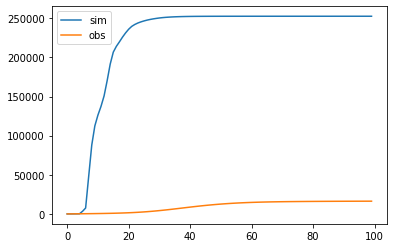

In [11]:
OpenCLRunner.update(repetitions=5)  # Temporarily use more repetitions to give a good baseline
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness0, sim0, obs0, out_params0, summaries0) = OpenCLRunner.run_model_with_params_abc({}, return_full_details=True)
OpenCLRunner.update(repetitions=REPETITIONS)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

# Check the model returns the observations correctly
np.array_equal(obs0, OBSERVATIONS.loc[:len(sim0)-1,"Cases"])

# Print the fitness and plot the different disease counts
print(f"fitness: {fitness0}")
#print(pd.DataFrame({"sim":sim, "real_obs1":obs}))

fig, ax = plt.subplots(1,1)
x = range(len(sim0))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="sim")
ax.plot(x, obs0, label="obs")
ax.legend()

### Plot output summary data

#### Total counts of disease status

In [12]:
def plot_summaries(summaries, observations=None, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    total_not_susceptible = np.zeros(iters)  # Used to compare to observations
    
    for d, disease_status in enumerate(DiseaseStatus):

        # Calculate the mean and standard deviation
        mean, sd = OpenCLRunner.get_mean_total_counts(summaries, d, get_sd=True)
        
        # Don't plot susceptible or recovered as it hides everytihng else
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )

    if observations is not None:
        # Plot the observations (cumulative infections)
        ax.plot(x, observations.loc[:len(x)-1, "Cases"], 
                label=f"Observations (cumulative cases)", color="black", linestyle="dashed")
        # And the total new infections, for comparison
        ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries),
               label=f"Total not susceptible ", color="grey", linestyle="dashed")
        
    
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")
    #ax.set_ylim(0, 5000)
    #ax.set_xlim(0,30)

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

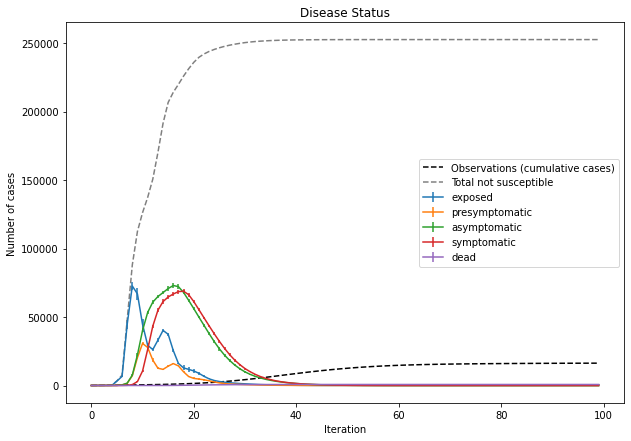

In [13]:
plot_summaries(summaries=summaries0, observations=OBSERVATIONS, plot_type="error_bars")

In [ ]:
#plot_summaries(summaries=summaries0, plot_type="lines")

#### Disease statuses by age

In [14]:
def plot_disease_status_by_age(summaries):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(int(len(DiseaseStatus)/2), int(len(DiseaseStatus)/2), 
                           figsize=(15,11), tight_layout=True)
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)
    age_thresholds = summaries[0].age_thresholds

    for d, disease_status in enumerate(DiseaseStatus):
        lower_age_bound = 0
        for age_idx in range(len(age_thresholds)):
            matrix = np.zeros(shape=(reps, iters))
            for rep in range(reps):
                #matrix[age_idx][rep][it] = summaries[rep].age_counts[str(disease_status)][age_idx][it]
                matrix[rep] = summaries[rep].age_counts[str(disease_status)][age_idx]
            mean = np.mean(matrix, axis=0)
            sd = np.std(matrix, axis=0)
            ax.flat[d].errorbar(x, mean, sd, label=f"{lower_age_bound} - {age_thresholds[age_idx]}" )
            lower_age_bound = age_thresholds[age_idx]
                
            ax.flat[d].legend() 
            ax.flat[d].set_title(f"{str(disease_status)}")
            ax.flat[d].set_xlabel("Iteration")
            ax.flat[d].set_ylabel("Number of cases")
    #fig.set_title(f"Num {disease_status} people by age group")

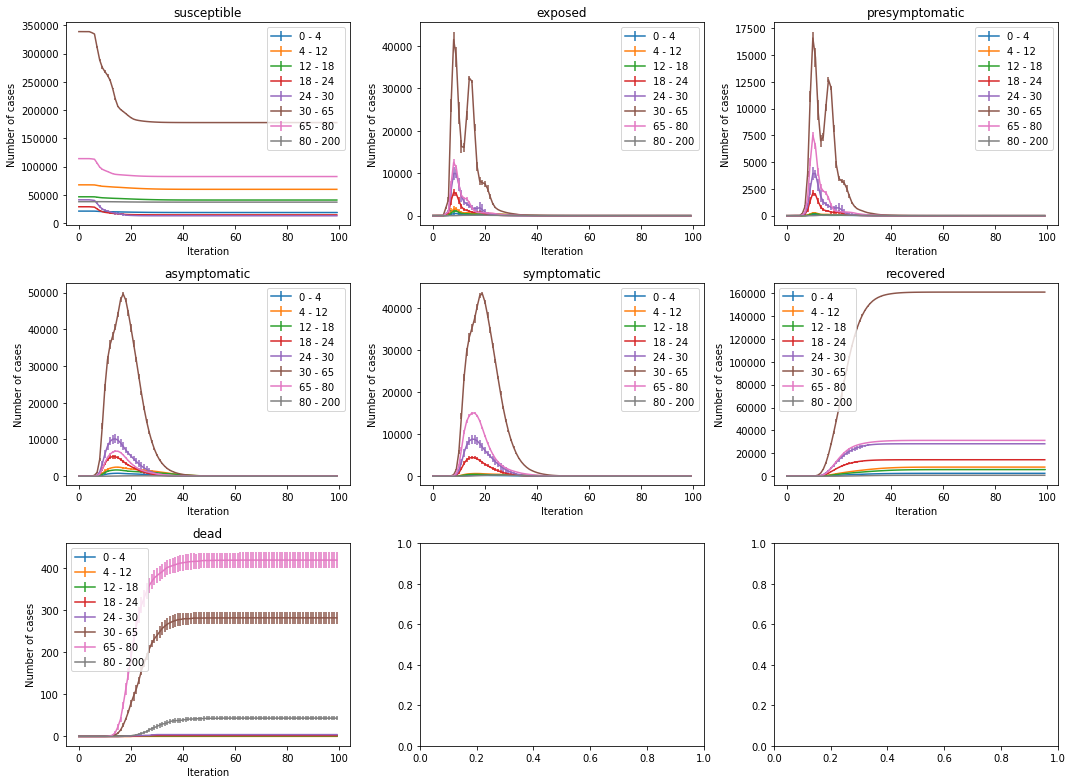

In [15]:
plot_disease_status_by_age(summaries0)

### Plot MSOA geodata

#### Load MSOA shapes

Loading OSM buildings shapefile
Loaded 206583 buildings from shapefile
Loaded 7201 MSOA shapes with projection epsg:27700
Loaded 107 devon MSOA codes
Filtered 107 devon MSOA shapes


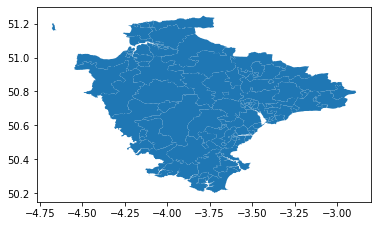

In [16]:
from microsim.load_msoa_locations import load_osm_shapefile, load_msoa_shapes

data_dir = ("../../devon_data")

osm_buildings = load_osm_shapefile(data_dir)

devon_msoa_shapes = load_msoa_shapes(data_dir, visualize=False)

devon_msoa_shapes.plot()
plt.show()

### Plot disease status by MSOA for a given timestep and status

In [17]:
def plot_msoa_choropleth(msoa_shapes, summary, disease_status, timestep, ax=None):
    """
    """
    # Summary can be a single summary, or a list of a few summaries (will need an average)
    # get dataframes for all statuses
    msoa_data = summary.get_area_dataframes()
    
    msoa_data_for_status = msoa_data[disease_status]

    # add "Code" column so dataframes can be merged
    msoa_data_for_status["Code"] = msoa_data_for_status.index
    msoa_shapes = pd.merge(msoa_shapes, msoa_data_for_status, on="Code")

    msoa_shapes.plot(column=f"Day{timestep}", legend=True, ax=ax)

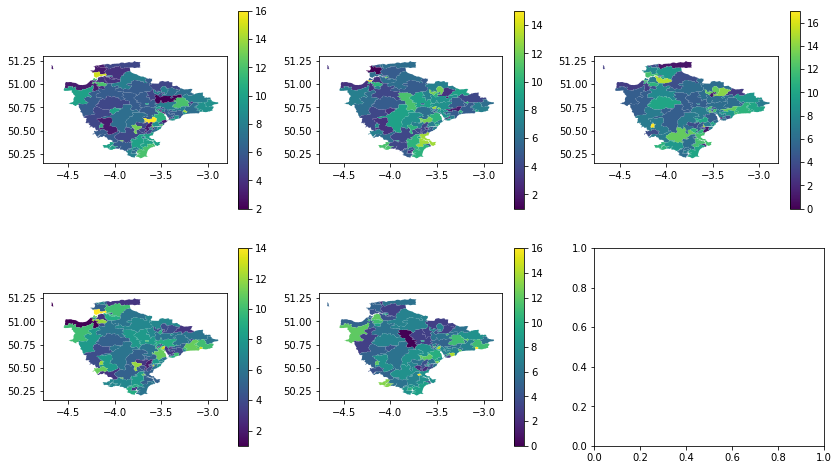

In [18]:
disease_status = "dead"

fig, axes = plt.subplots(nrows=2, ncols=int(REPETITIONS/2) if (REPETITIONS % 2) == 0 else int(REPETITIONS/2)+1, 
                         figsize=(14,8))

for i in range(REPETITIONS):
    ax = axes.flat[i]
    plot_msoa_choropleth(devon_msoa_shapes,  summaries0[i], 
                         disease_status, 99, ax=ax )
#plot_msoa_choropleth(devon_msoa_shapes, summaries0[0], disease_status, 99)

## Approximate Bayesian Computation

 - Use [pyabc](https://pyabc.readthedocs.io/) (listed in [pythonMCMC](https://gabriel-p.github.io/pythonMCMC/)).

In [20]:
# Also need a new distance function that extracts the data from dataframes.
def distance(sim,obs):
    fit = OpenCLRunner.fit_l2(sim["data"],obs["data"])
    print(fit)
    return fit

### Calculating Error: Fitness Function

To calibrate the model we need a fitness function that tells us, for a given result, how similar it is to the observations. The 'observations' (in the [gam_cases.csv](../../gam_cases.csv)) are the number of new infections per day. The model equivalent of this is to look at the number of non-susceptible people per day (i.e. add up all the _non-susceptible_ disease statuses).

Ultimately two arrays showing the cumulative infections per day need to be compared. There are lots of ways to do this. For now, just take the **Euclidean distance (L2 norm)** between the observed number of cases and the simulated number of cases.

This is implemented in `opencl_runner.OpenCLRunner.fit_l2` (see [opencl_runner.py](../opencl_runner.py)).

Note that the model is seeded using the first few days of cases, so at the beginning of a run the simulated data will be identical to the observations. This doesn't matter though because the relative difference between different parameter combinations will be the same regardless.

### Priors

Define the priors. This time make them all normal distributions, but will decorate them later to make sure they are positive. (_For some reason there is an error thrown if they are decorated first_) 

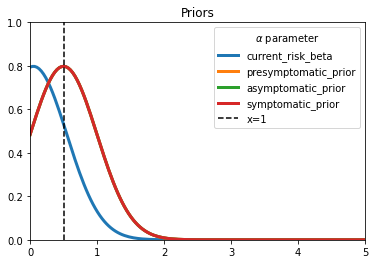

In [21]:
current_risk_beta_rv = pyabc.RV("norm", 0.05, 0.5)
presymptomatic_rv = pyabc.RV("norm", 0.5, 0.5)
asymptomatic_rv = pyabc.RV("norm", 0.5, 0.5)
symptomatic_rv = pyabc.RV("norm", 0.5, 0.5)

# Note, could create the distribution here (currently done below), then plot the priors directly using, e.g. 
#   y= p riors['current_risk_beta_prior'].pdf(x)
# but for some reason decorating them with the LowerBoundDecorator breaks the call to pdf()

x = np.linspace(-0 ,5, 150)
lines = plt.plot(x, pyabc.Distribution(param=current_risk_beta_rv).pdf({"param": x}),
                 label = "current_risk_beta", lw = 3)
lines = plt.plot(x, pyabc.Distribution(param=presymptomatic_rv).pdf({"param": x}),
                 label = "presymptomatic_prior", lw = 3)
lines = plt.plot(x, pyabc.Distribution(param=asymptomatic_rv).pdf({"param": x}),
                 label = "asymptomatic_prior", lw = 3)
lines = plt.plot(x, pyabc.Distribution(param=symptomatic_rv).pdf({"param": x}),
                 label = "symptomatic_prior", lw = 3)

plt.autoscale(tight=True)

plt.axvline(x=0.5, ls='--', color="black", label="x=1")
plt.title("Priors")
plt.ylim(0,1)
plt.legend(title=r"$\alpha$ parameter");

In [22]:
# Decorate the RVs so that they wont go below 0 and create the prior distribution 

priors = pyabc.Distribution(
    current_risk_beta = pyabc.LowerBoundDecorator(current_risk_beta_rv, 0.0),
    presymptomatic = pyabc.LowerBoundDecorator(presymptomatic_rv, 0.0),
    asymptomatic = pyabc.LowerBoundDecorator(asymptomatic_rv, 0.0),
    symptomatic = pyabc.LowerBoundDecorator(symptomatic_rv, 0.0)
    )

#current_risk_beta_prior = pyabc.LowerBoundDecorator(current_risk_beta_prior, 0.0)
#presymptomatic_prior = pyabc.LowerBoundDecorator(presymptomatic_prior, 0.0)
#asymptomatic_prior = pyabc.LowerBoundDecorator(asymptomatic_prior, 0.0)
#symptomatic_prior = pyabc.LowerBoundDecorator(symptomatic_prior, 0.0)

### Initialise the ABC algorithm.

In [23]:
abc = pyabc.ABCSMC(
    models=OpenCLRunner.run_model_with_params_abc, # Model (could be a list)
    parameter_priors=priors, # Priors (could be a list)
    distance_function=distance,  # Distance function
    sampler = pyabc.sampler.SingleCoreSampler()  # Single core because the model is parallelised
    )

Define observations

In [24]:
# 'Real' cumulative cases: 
y_observed = OBSERVATIONS.loc[:ITERATIONS-1, "Cases"].values

Where to store results


In [25]:
db_path = ("sqlite:///" + os.path.join(".", "abc-12.db"))

In [26]:
run_id = abc.new(db_path, {"data": y_observed})  # (ID only matters if multiple runs stored is same DB)

ABC.History INFO: Start <ABCSMC id=6, start_time=2021-10-27 12:23:44>


### Run ABC

In [27]:
history = None
fname = "./abc-12.pkl"
history = abc.run(max_nr_populations=5)

with open( fname, "wb" ) as f:
    pickle.dump( history, f) 


 #if LOAD_PICKLES:
     #with open( fname, "rb" ) as f:
         #history = pickle.load(f)
 #else:
    #history = abc.run(minimum_epsilon=.1, max_nr_populations=10)
    #history = abc.run(max_nr_populations=5) 
    # The history object only works if it has the associated database too ('abc-1.db')
     #with open( fname, "wb" ) as f:
         #pickle.dump( history, f)

ABC INFO: Calibration sample t = -1.
Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/ramp-ua/lib/python3.7/site-packages/RAMP_UA-1.4.0.dev0-py3.7.egg/microsim/opencl/ramp/params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file.
  warnings.warn("Params object is being created using hard-coded default values, "
Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5197396569695371, 'presymptomatic': 0.025995411237876243, 'asymptomatic': 0.992472741402112, 'symptomatic': 1.1534475046362758>


Running models: 100%|██████████| 5/5 [00:20<00:00,  4.17s/it]

.. finished, took 20.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.27906150441930816, 'presymptomatic': 0.9310276357692004, 'asymptomatic': 0.9456593446794523, 'symptomatic': 0.3170922311844113>


Running models: 100%|██████████| 5/5 [00:22<00:00,  4.56s/it]

.. finished, took 22.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.12883366721468018, 'presymptomatic': 0.8288807583242751, 'asymptomatic': 0.8498808216318272, 'symptomatic': 0.1383396223399696>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.40s/it]

.. finished, took 16.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4471469187051058, 'presymptomatic': 1.231910643283599, 'asymptomatic': 0.1652145432951141, 'symptomatic': 1.8076221315937233>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.09153884653703828, 'presymptomatic': 0.7663518358048893, 'asymptomatic': 0.47134034558062343, 'symptomatic': 0.08934425984962574>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2643658532876473, 'presymptomatic': 0.7774098379794954, 'asymptomatic': 0.9712416970063162, 'symptomatic': 0.8954211928385809>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5088796397853431, 'presymptomatic': 0.529784629799832, 'asymptomatic': 1.693220030904878, 'symptomatic': 0.428967533728567>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.40s/it]

.. finished, took 16.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.20514848258592955, 'presymptomatic': 0.6077822630690988, 'asymptomatic': 0.9767784949544946, 'symptomatic': 0.3366858849107541>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3755495209960188, 'presymptomatic': 0.3360253785994849, 'asymptomatic': 0.2242992256635591, 'symptomatic': 0.2803922425013139>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5505690666582909, 'presymptomatic': 0.4612818994278249, 'asymptomatic': 0.08370315142711848, 'symptomatic': 1.360008827988132>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5799710408508623, 'presymptomatic': 0.37593482950412127, 'asymptomatic': 0.34609625829712065, 'symptomatic': 0.046259870240505985>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.423091586309073, 'presymptomatic': 0.7964125658042538, 'asymptomatic': 1.4012238293219672, 'symptomatic': 0.002608023287758554>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.14030992410408222, 'presymptomatic': 0.1360144897551454, 'asymptomatic': 0.10295853350407669, 'symptomatic': 0.7872633112895058>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.09975966101026766, 'presymptomatic': 0.5881952207038866, 'asymptomatic': 0.11861396999979895, 'symptomatic': 0.6801007902466254>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4302919398575968, 'presymptomatic': 0.9392514511086472, 'asymptomatic': 0.6422256255459529, 'symptomatic': 0.9961188943933552>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3959739521111746, 'presymptomatic': 0.9190914694850426, 'asymptomatic': 0.4387722435132993, 'symptomatic': 0.16485710410318621>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.1287475196888259, 'presymptomatic': 1.7582839275722613, 'asymptomatic': 0.3534100301906806, 'symptomatic': 0.5378102045312535>


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.519324585354362, 'presymptomatic': 0.5227335773950745, 'asymptomatic': 0.9778112739439083, 'symptomatic': 1.0657871583798824>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6198872020630399, 'presymptomatic': 1.412724561212972, 'asymptomatic': 1.606185389809623, 'symptomatic': 0.8464189911359072>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4682621122890761, 'presymptomatic': 0.8846062797474421, 'asymptomatic': 0.8928926514821763, 'symptomatic': 0.37853770948884646>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.06101843260987677, 'presymptomatic': 0.7083477592763524, 'asymptomatic': 0.3020829216222418, 'symptomatic': 0.5303953794396965>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.48376953662799754, 'presymptomatic': 0.6579010668590157, 'asymptomatic': 0.6665078464936516, 'symptomatic': 1.2663705523862827>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.030162323242289645, 'presymptomatic': 1.1026007019814035, 'asymptomatic': 0.7453093214422402, 'symptomatic': 0.8184070040256886>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2712996819189378, 'presymptomatic': 0.3966520114423973, 'asymptomatic': 0.7071528979965962, 'symptomatic': 0.5811909535226478>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4716106729821158, 'presymptomatic': 0.4424427222328417, 'asymptomatic': 0.3504566660044236, 'symptomatic': 0.6831015034626069>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.0534694917667964, 'presymptomatic': 1.3113015120258011, 'asymptomatic': 0.8022327224344117, 'symptomatic': 0.5023386814711961>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4614082514916901, 'presymptomatic': 0.01959621342929141, 'asymptomatic': 0.3036825149652805, 'symptomatic': 0.8011480185499671>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.25662723692649186, 'presymptomatic': 1.0493596015224433, 'asymptomatic': 0.6550560002886568, 'symptomatic': 0.6936447500618751>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.37990964825701995, 'presymptomatic': 0.7163639247506097, 'asymptomatic': 0.43544068628733723, 'symptomatic': 0.2520364205224346>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5773227742374873, 'presymptomatic': 1.1194212697374974, 'asymptomatic': 1.0458880421819399, 'symptomatic': 0.996869874070258>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7300371492168957, 'presymptomatic': 0.7694004581036094, 'asymptomatic': 1.0910366612036357, 'symptomatic': 0.2291500793794824>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.31390898430396297, 'presymptomatic': 0.7473095460382092, 'asymptomatic': 1.3396073937046231, 'symptomatic': 0.8139792228722912>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7601764129579711, 'presymptomatic': 0.24299488178101192, 'asymptomatic': 0.8561553395993375, 'symptomatic': 0.9585213484062988>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.23805233741951293, 'presymptomatic': 0.6602831836711692, 'asymptomatic': 0.5089481382660844, 'symptomatic': 0.5114121653927983>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.342692982363515, 'presymptomatic': 0.6774567471149191, 'asymptomatic': 0.675770246834645, 'symptomatic': 0.2623831863120913>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.09064113197776466, 'presymptomatic': 0.9191366008023508, 'asymptomatic': 0.5966560390914778, 'symptomatic': 0.457480828394824>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.0033917468525047, 'presymptomatic': 0.8722664485511673, 'asymptomatic': 0.9529965677834519, 'symptomatic': 1.2210401900715089>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4985778767447505, 'presymptomatic': 1.1757305931559605, 'asymptomatic': 0.8591204094238498, 'symptomatic': 0.7906933588496965>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.10794632221862022, 'presymptomatic': 0.8756966580052781, 'asymptomatic': 0.4801526772538606, 'symptomatic': 1.0851926509819312>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5321999014617922, 'presymptomatic': 0.20700416087246043, 'asymptomatic': 0.7760837285845518, 'symptomatic': 0.21688227748122452>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.1386572494147717, 'presymptomatic': 0.29726272078160343, 'asymptomatic': 0.9549200693608682, 'symptomatic': 1.3305479357287797>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.209347658252371, 'presymptomatic': 0.6300465232781775, 'asymptomatic': 0.3132283072754546, 'symptomatic': 0.17114274682506742>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.12331570353070948, 'presymptomatic': 0.5266974658735532, 'asymptomatic': 0.5939883231637721, 'symptomatic': 0.10690583332817555>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7047478054328831, 'presymptomatic': 0.8415962467553919, 'asymptomatic': 1.0633515257137423, 'symptomatic': 0.47036223286917583>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.11722232683322938, 'presymptomatic': 0.42294533589586336, 'asymptomatic': 0.39644406507121865, 'symptomatic': 0.2446677778579019>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.14749455392889183, 'presymptomatic': 0.3213348042410388, 'asymptomatic': 0.23307514784514388, 'symptomatic': 0.876283066929384>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.07321259329670884, 'presymptomatic': 0.3975694395914464, 'asymptomatic': 0.7758575202336955, 'symptomatic': 0.06523793158809327>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.13653760902799822, 'presymptomatic': 1.4091153723798264, 'asymptomatic': 0.7914909218345816, 'symptomatic': 0.299824707521712>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.63460285290099, 'presymptomatic': 0.4963559918226593, 'asymptomatic': 1.1230755596821536, 'symptomatic': 0.6574861159894168>


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.47s/it]

.. finished, took 17.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.42293270729633653, 'presymptomatic': 0.48683970730281795, 'asymptomatic': 0.9218902744796567, 'symptomatic': 0.7105924583522241>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4643077881151139, 'presymptomatic': 1.241458586090549, 'asymptomatic': 0.409764734471459, 'symptomatic': 0.3480702942530167>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.13586546926671167, 'presymptomatic': 0.06795945394827635, 'asymptomatic': 0.5953178884860438, 'symptomatic': 1.0616929024954582>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.516776143065528, 'presymptomatic': 0.049040547565349646, 'asymptomatic': 0.16009790077108094, 'symptomatic': 0.780762833108412>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.08761436866998437, 'presymptomatic': 1.148858407087467, 'asymptomatic': 1.0766884072763236, 'symptomatic': 0.3332928597817827>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.024989465904278352, 'presymptomatic': 0.8526410697507293, 'asymptomatic': 0.8820472666895942, 'symptomatic': 0.448739555882656>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4120462337111102, 'presymptomatic': 0.3983927072599193, 'asymptomatic': 0.0949006214357968, 'symptomatic': 0.43132430381792697>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.03506116030883584, 'presymptomatic': 0.04720410060251862, 'asymptomatic': 0.5756861012473926, 'symptomatic': 0.45525094503745955>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.1306182643966951, 'presymptomatic': 0.7156006917828897, 'asymptomatic': 0.3239228905448452, 'symptomatic': 0.4402930742842595>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2662097852859022, 'presymptomatic': 0.1549608447393942, 'asymptomatic': 0.46795604491365755, 'symptomatic': 0.8987833239607574>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2148986860556365, 'presymptomatic': 0.48287414437577564, 'asymptomatic': 0.15532450055499442, 'symptomatic': 1.2075175377741645>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.3002160441484765, 'presymptomatic': 0.42081544990887476, 'asymptomatic': 0.3964172750006121, 'symptomatic': 0.6223880054476538>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.1130282374729095, 'presymptomatic': 0.1970769396358371, 'asymptomatic': 0.798130476423634, 'symptomatic': 1.3067019880573518>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3422799054640949, 'presymptomatic': 1.3785776443770603, 'asymptomatic': 0.7082110446305085, 'symptomatic': 0.8521762334149305>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8133383290303169, 'presymptomatic': 0.9586982459930626, 'asymptomatic': 0.5774860592129263, 'symptomatic': 0.5583700059237129>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.03360417709474199, 'presymptomatic': 0.8860589756223786, 'asymptomatic': 0.3467913343775001, 'symptomatic': 0.8469570902193924>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.45837527044407606, 'presymptomatic': 0.30085148078692825, 'asymptomatic': 0.11068301288182492, 'symptomatic': 0.28999011750342946>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.42344524459273625, 'presymptomatic': 0.18356096313476272, 'asymptomatic': 1.4492290162423989, 'symptomatic': 0.5095568720895102>


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.21094694673195996, 'presymptomatic': 0.8392394665086098, 'asymptomatic': 0.5117568231315685, 'symptomatic': 0.4617532007160735>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7352809985128592, 'presymptomatic': 0.009079071211115786, 'asymptomatic': 0.5435299359157092, 'symptomatic': 0.4641951532820783>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.19930941753931125, 'presymptomatic': 0.4836090708802287, 'asymptomatic': 0.2759072404722279, 'symptomatic': 0.9004867212586712>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.035757426411036616, 'presymptomatic': 0.18181559351041293, 'asymptomatic': 0.3544304981576857, 'symptomatic': 0.6476424623316305>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.9353848268585934, 'presymptomatic': 0.5003720889415286, 'asymptomatic': 0.1458546642513907, 'symptomatic': 0.29104814312804234>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8036453897604248, 'presymptomatic': 0.19366637826817662, 'asymptomatic': 0.4707072615167352, 'symptomatic': 0.15040039971210095>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3805451300738983, 'presymptomatic': 1.0328586017550023, 'asymptomatic': 0.9720051087208658, 'symptomatic': 0.01843629643952166>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5789881322598737, 'presymptomatic': 0.2764650357830352, 'asymptomatic': 0.6920957510570702, 'symptomatic': 0.29079707692077594>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.27494731671876055, 'presymptomatic': 0.5119754068073669, 'asymptomatic': 0.6128268426798499, 'symptomatic': 0.14608758374228697>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.44803743141487734, 'presymptomatic': 1.1990897169546653, 'asymptomatic': 0.6211294413701429, 'symptomatic': 0.43789391685897744>


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.04741550500086088, 'presymptomatic': 0.3984450271085974, 'asymptomatic': 1.107713205611518, 'symptomatic': 0.7708904860644876>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6904995526434771, 'presymptomatic': 0.42715513845081815, 'asymptomatic': 0.5594419292985368, 'symptomatic': 0.6846638657487413>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5296250757941282, 'presymptomatic': 1.0579574350260514, 'asymptomatic': 0.46237566361886245, 'symptomatic': 1.2705593172047043>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.057272545858218275, 'presymptomatic': 0.11976929298981098, 'asymptomatic': 0.651094755540237, 'symptomatic': 0.9099617173219576>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.22618290147341225, 'presymptomatic': 0.5627841145423674, 'asymptomatic': 1.5199377827491627, 'symptomatic': 0.49000202224188044>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5866922898552923, 'presymptomatic': 0.10046114683764501, 'asymptomatic': 0.47271583908510934, 'symptomatic': 0.5436524721868978>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4039018988863689, 'presymptomatic': 0.2537317165924037, 'asymptomatic': 1.013011380283916, 'symptomatic': 0.10800554561454934>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.264556695324691, 'presymptomatic': 0.6203727359078509, 'asymptomatic': 0.0842157528543464, 'symptomatic': 0.6148093640280674>


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.02360586922633008, 'presymptomatic': 0.3956393577460305, 'asymptomatic': 0.5566916332506096, 'symptomatic': 0.6677403344100334>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.11430987471022198, 'presymptomatic': 0.029611453744800897, 'asymptomatic': 0.11478560241806163, 'symptomatic': 0.7216344662069603>


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.12114580174699245, 'presymptomatic': 0.5840738528654018, 'asymptomatic': 1.0803817385313261, 'symptomatic': 0.35079707212872224>


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.0841812269083801, 'presymptomatic': 1.368691621314965, 'asymptomatic': 1.7087707076875536, 'symptomatic': 0.7448673529391375>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.05800462117608111, 'presymptomatic': 0.9072397193334153, 'asymptomatic': 0.11570331781641224, 'symptomatic': 1.3688406170862322>


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.21793635561184532, 'presymptomatic': 1.0971982451225943, 'asymptomatic': 0.4687583048042855, 'symptomatic': 0.06170932840831722>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.06094000303407804, 'presymptomatic': 0.22495037834717663, 'asymptomatic': 0.6719806430522339, 'symptomatic': 0.7431395981944183>


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.260710050155416, 'presymptomatic': 0.7079577600415241, 'asymptomatic': 0.4450384459551933, 'symptomatic': 1.239240138641824>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.9536621886276437, 'presymptomatic': 0.5045267444118718, 'asymptomatic': 0.40565200438305365, 'symptomatic': 0.7066815671065716>


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.9988097599504792, 'presymptomatic': 0.677902267933441, 'asymptomatic': 1.1636249190909114, 'symptomatic': 0.27010890883782124>


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.9300454963464333, 'presymptomatic': 0.24703709754869702, 'asymptomatic': 1.311183569718, 'symptomatic': 0.05918615323081533>


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.31795834102760284, 'presymptomatic': 0.8372063856700926, 'asymptomatic': 0.982076386837586, 'symptomatic': 0.49213277732090654>


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.1743006088091959, 'presymptomatic': 1.506918633546373, 'asymptomatic': 0.014138467501275176, 'symptomatic': 1.4876708112529644>


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.04317268555109721, 'presymptomatic': 0.06739105989555277, 'asymptomatic': 0.2667767201398681, 'symptomatic': 0.2009845994757538>


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.85s)



ABC INFO: t: 0, eps: 4.95728859e+06.
Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.010057857500691561, 'presymptomatic': 0.5735073164725675, 'asymptomatic': 0.5278559715683646, 'symptomatic': 1.1269938685346714>
5366453.312896244
5088100.864457151
4450699.3532012105
4997046.384241387
3915386.5820574043
5198032.00598787
5383470.758999513
4885007.736389853
4614336.020145222
4829817.5413205
4814184.206960245
5107655.905502621
4001081.6372933956
3901479.3124656915
5301069.730094483
4965701.569164752
4464722.961484665
5395878.504490122
5485505.073379723
5305591.545793441
3714393.0864497903
5334893.941498856
3689618.267617993
5007618.584885637
5093530.119177516
5480941.927526505
4981651.047055388
5062702.079939293
4948875.617721315
5443270.332893424
5394362.336496914
5316477.728430014
5414579.362052491
4825963.770528005
5030030.938322801
4233585.748125501
2269794.7145834663
5390750.607227936
4489330.527353004
5140625.610419347
4886825.124538876
4336428.509982946
4165215.1853500633
5433120.576368358
4016254.2121907123
4324566

Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.18851890089996648, 'presymptomatic': 0.46663512724625944, 'asymptomatic': 0.4161842648932423, 'symptomatic': 1.0827848228733934>
4746130.390218465


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.20776320541933746, 'presymptomatic': 0.2569790854028176, 'asymptomatic': 1.6973923530983195, 'symptomatic': 0.8419276311050046>
5182748.990947218


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.16905734707761713, 'presymptomatic': 0.31797645710577044, 'asymptomatic': 1.0831751472106745, 'symptomatic': 0.23549217354009488>
4695249.663852605


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7426369879309362, 'presymptomatic': 0.009229928100151996, 'asymptomatic': 0.9432589756559968, 'symptomatic': 1.3828521597370673>
5416894.454339224


Running models: 100%|██████████| 5/5 [00:19<00:00,  3.90s/it]

.. finished, took 19.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.1934009384333938, 'presymptomatic': 1.1817233833795178, 'asymptomatic': 0.5591683870864458, 'symptomatic': 0.40133028626808126>
4760569.757831854


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.0077159418771737, 'presymptomatic': 0.7557344097411502, 'asymptomatic': 1.2241316850924469, 'symptomatic': 0.20043720579525887>
5446587.789413206


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.0071124647335141, 'presymptomatic': 0.28382614797395056, 'asymptomatic': 0.5491895566153665, 'symptomatic': 0.6089593977204472>
5393592.879062145


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.14123217785650954, 'presymptomatic': 0.8065398558551473, 'asymptomatic': 0.26033016805829984, 'symptomatic': 0.5876436225990804>
4306276.79607107


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.06750724036446101, 'presymptomatic': 0.21948713711029189, 'asymptomatic': 0.7169923751446732, 'symptomatic': 0.7827881728257653>
4102611.824786333


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.1261963001868704, 'presymptomatic': 0.3228905389769873, 'asymptomatic': 1.0619618789976593, 'symptomatic': 0.733551802701695>
4723321.592580738


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.43103423741036945, 'presymptomatic': 0.22686242700459847, 'asymptomatic': 0.4870491995388192, 'symptomatic': 1.0575853584522863>
5176790.973768877


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8691890983888682, 'presymptomatic': 0.12484726872292906, 'asymptomatic': 0.5885927428609908, 'symptomatic': 0.19680598883226275>
5232707.387611591


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.043447119366507705, 'presymptomatic': 0.5603873145962781, 'asymptomatic': 0.8710696341894956, 'symptomatic': 0.3885122600312758>
3785740.231791426


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.22241892291101606, 'presymptomatic': 0.5288365798681698, 'asymptomatic': 0.33377991528875217, 'symptomatic': 0.8129217676912395>
4718148.41533956


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3297606546617812, 'presymptomatic': 0.7191271535089587, 'asymptomatic': 0.9098111218904551, 'symptomatic': 0.7995418675858315>
5254837.220178193


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.07206356070540075, 'presymptomatic': 0.529722771333581, 'asymptomatic': 0.9195566508323214, 'symptomatic': 0.3873458518295121>
4163515.2989081377


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.055704191656812556, 'presymptomatic': 0.3893871815403469, 'asymptomatic': 0.29987569556442306, 'symptomatic': 0.34610150714694243>
3419219.691814587


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.1451516302096008, 'presymptomatic': 0.41658202667122946, 'asymptomatic': 0.8620069592688633, 'symptomatic': 0.2700122540289277>
5426351.865360941


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.19709204913518763, 'presymptomatic': 0.41831493622117005, 'asymptomatic': 0.4382579862887241, 'symptomatic': 0.6400601196060294>
4650842.1957193045


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3942962445530558, 'presymptomatic': 1.1195112537119791, 'asymptomatic': 0.7880392776852972, 'symptomatic': 0.6886276927948279>
5298996.469989737


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3061924734848991, 'presymptomatic': 0.2113083457839518, 'asymptomatic': 0.678679104993255, 'symptomatic': 0.11916778759648333>
4726423.59256436


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5218960585746084, 'presymptomatic': 1.1211522511087824, 'asymptomatic': 1.0988885577486802, 'symptomatic': 0.3636861600325212>
5383229.791343929


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.030659513035392924, 'presymptomatic': 0.5313341052557252, 'asymptomatic': 0.5777502366105918, 'symptomatic': 0.47625371506359165>
3364758.181827948


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8424422970069777, 'presymptomatic': 0.23085613284597944, 'asymptomatic': 0.3254481117147021, 'symptomatic': 1.3240176804729489>
5288499.1915589925


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7170294669748041, 'presymptomatic': 0.5771719564827301, 'asymptomatic': 1.0243905939244453, 'symptomatic': 1.2427313556511088>
5449404.47814211


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.9600821337737722, 'presymptomatic': 0.7647370972539664, 'asymptomatic': 0.3208328171520911, 'symptomatic': 0.9085167843873176>
5349271.028241942


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.14651900115732827, 'presymptomatic': 0.5896925562624362, 'asymptomatic': 0.1674284966358534, 'symptomatic': 0.1638036371423966>
3852622.256538541


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.988765707689433, 'presymptomatic': 0.680467564490836, 'asymptomatic': 0.20027755052706725, 'symptomatic': 0.7944366484061354>
5249332.209071318


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.10627693623799214, 'presymptomatic': 1.4172764948852645, 'asymptomatic': 1.012542679292686, 'symptomatic': 1.391232219150961>
4844092.648900119


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.2677879829070346, 'presymptomatic': 0.009162965697421033, 'asymptomatic': 0.4302652128492706, 'symptomatic': 0.947759601184222>
5370639.390056574


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.309173143357109, 'presymptomatic': 0.7141929484904634, 'asymptomatic': 0.40871982270366547, 'symptomatic': 0.934255021058745>
5016412.3711525


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5808015415574649, 'presymptomatic': 0.3352612091078472, 'asymptomatic': 0.9090078895626835, 'symptomatic': 0.48537206628848656>
5337333.742853411


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.1061430011081618, 'presymptomatic': 0.8708850369192432, 'asymptomatic': 0.7352610037218796, 'symptomatic': 0.5478157241540956>
4459379.398098507


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.024803509369561, 'presymptomatic': 0.5993388910507722, 'asymptomatic': 0.3621874866620499, 'symptomatic': 0.5788563045080282>
5365602.320248771


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5797579670097827, 'presymptomatic': 0.9974902924155913, 'asymptomatic': 0.4634442704472391, 'symptomatic': 0.9499113772962511>
5316332.352171865


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6139497540329685, 'presymptomatic': 0.07890231796537184, 'asymptomatic': 0.3241621041342805, 'symptomatic': 1.135493448277467>
5171639.367372752


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6014745998235776, 'presymptomatic': 0.7976290500052554, 'asymptomatic': 1.133843003691052, 'symptomatic': 1.2085251715772327>
5447876.841212194


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.173255811131284, 'presymptomatic': 0.31317374012445104, 'asymptomatic': 0.43469166498879996, 'symptomatic': 0.8042141887295747>
5399283.291047895


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6082973274811748, 'presymptomatic': 0.43695056962341716, 'asymptomatic': 0.18428919606360022, 'symptomatic': 0.5180695229065296>
4980582.454709819


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.24916543966030896, 'presymptomatic': 1.007632134100147, 'asymptomatic': 1.2823355011808313, 'symptomatic': 0.750425155758282>
5237631.932274928


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.23988080552439334, 'presymptomatic': 0.4600494401852181, 'asymptomatic': 0.2026699145907196, 'symptomatic': 0.96139982996445>
4642222.817367551


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.02632271290350427, 'presymptomatic': 0.7453786438534349, 'asymptomatic': 1.4817946328014755, 'symptomatic': 0.7785701410233689>
3834102.4855576097


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.29523584716985773, 'presymptomatic': 0.5846738324365932, 'asymptomatic': 1.1845879281247993, 'symptomatic': 0.5661988225782011>
5211890.736392911


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2713123948819131, 'presymptomatic': 1.0726862441303688, 'asymptomatic': 0.058070420112310006, 'symptomatic': 0.18124417223948797>
4238186.093816311


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.384250162798227, 'presymptomatic': 1.1547146932139818, 'asymptomatic': 1.389823427206259, 'symptomatic': 0.5411178691144384>
5365195.186506548


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.2273529565825398, 'presymptomatic': 0.8763673069681481, 'asymptomatic': 0.013999036325804237, 'symptomatic': 0.4735258759462474>
4741546.6041969685


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.33959454483757406, 'presymptomatic': 0.5551292577295137, 'asymptomatic': 0.7196199861880432, 'symptomatic': 1.7416331382594419>
5262834.151175566


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.03621901353011729, 'presymptomatic': 0.1981822804495762, 'asymptomatic': 1.0842091072690383, 'symptomatic': 0.44649024998760845>
3732042.1305437274


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2343931775897145, 'presymptomatic': 1.2168839427240443, 'asymptomatic': 0.7155645148146788, 'symptomatic': 0.7493645717950628>
5064734.473590516


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.59s/it]

.. finished, took 17.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3995178700995818, 'presymptomatic': 1.3272777348784432, 'asymptomatic': 0.8409093932775122, 'symptomatic': 0.6124693464093125>
5319960.037807671


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.57s/it]

.. finished, took 17.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7492822109074191, 'presymptomatic': 0.05867325359641257, 'asymptomatic': 1.2657463784701666, 'symptomatic': 0.31300691894748967>
5338673.07850287


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.0125560833480844, 'presymptomatic': 0.17054969484928822, 'asymptomatic': 0.6831679878657877, 'symptomatic': 1.2830849909635562>
5424053.709622268


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.255633103669363, 'presymptomatic': 0.244210384109807, 'asymptomatic': 0.8177804886995748, 'symptomatic': 0.23569139813152423>
4811085.37787777


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2545275261004598, 'presymptomatic': 0.4221929060151276, 'asymptomatic': 1.1352864052831995, 'symptomatic': 0.0641816231311082>
4822792.177746311


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6269604153439006, 'presymptomatic': 1.1541445443540757, 'asymptomatic': 0.24581045214180708, 'symptomatic': 0.7750051752908793>
5189046.302384634


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.11196991662376214, 'presymptomatic': 0.7455978431735484, 'asymptomatic': 0.26833422318685585, 'symptomatic': 0.2035834283753068>
3911187.2285859957


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.49s/it]

.. finished, took 17.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.059228132380913324, 'presymptomatic': 0.2552693141843704, 'asymptomatic': 0.6559077963849987, 'symptomatic': 1.2705583100077966>
4137169.7628515707


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7729443837004408, 'presymptomatic': 1.5131303456700245, 'asymptomatic': 0.5810231647912191, 'symptomatic': 1.1182150189637108>
5436172.80306835


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.16348564191519394, 'presymptomatic': 0.5026604047743752, 'asymptomatic': 0.679996114752605, 'symptomatic': 1.030682865059542>
4825539.317205517


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.47s/it]

.. finished, took 17.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.27025323491159103, 'presymptomatic': 0.33329524085623874, 'asymptomatic': 0.6124733872601339, 'symptomatic': 0.8033618857749825>
5007923.966017535


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.65s/it]

.. finished, took 18.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8224063584590812, 'presymptomatic': 0.3683902050957008, 'asymptomatic': 1.2662719245420386, 'symptomatic': 1.2812790350779903>
5466843.222124033


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.53s/it]

.. finished, took 17.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.1014878571206692, 'presymptomatic': 0.36861931808673676, 'asymptomatic': 0.38346981995081675, 'symptomatic': 0.3460131758332339>
5342135.970347108


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5177305888616103, 'presymptomatic': 0.6166642604805351, 'asymptomatic': 0.23540335551714575, 'symptomatic': 2.148223575288017>
5110052.75023701


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.30877724338845786, 'presymptomatic': 0.34506321271294826, 'asymptomatic': 1.0516516974421397, 'symptomatic': 0.9586306291251103>
5253799.819976002


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.1375972716535738, 'presymptomatic': 0.7729360542849875, 'asymptomatic': 0.4026978277305183, 'symptomatic': 0.5480100256011017>
5413067.384324965


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.008527009021784764, 'presymptomatic': 0.8079583314405779, 'asymptomatic': 0.10556249599452427, 'symptomatic': 0.06375244588702961>
2064946.4863427624


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.12550406248222692, 'presymptomatic': 0.45000665592524697, 'asymptomatic': 1.4063439637790105, 'symptomatic': 0.681660953447677>
4830520.424043575


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.39422856306230786, 'presymptomatic': 0.7164829476371644, 'asymptomatic': 0.6995374747240933, 'symptomatic': 0.27333484479592374>
5128570.307571526


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.1517588732819979, 'presymptomatic': 0.44701385359259727, 'asymptomatic': 0.530582406081907, 'symptomatic': 0.14842287779922947>
5349751.638204252


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8316199114551488, 'presymptomatic': 0.5245270276452267, 'asymptomatic': 2.139524027742108, 'symptomatic': 0.4105878803992655>
5466643.664107317


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.46198854740760464, 'presymptomatic': 1.263130626307813, 'asymptomatic': 0.7574651154248555, 'symptomatic': 0.5178872162289095>
5331470.611756362


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4142194476607471, 'presymptomatic': 0.2757633395958913, 'asymptomatic': 1.257020786337815, 'symptomatic': 0.17696658889032146>
5122110.131700157


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5240567385433931, 'presymptomatic': 0.3986168155017479, 'asymptomatic': 0.36791134650039126, 'symptomatic': 0.4778050631785427>
5106041.179954266


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2515494486445522, 'presymptomatic': 0.7099235488783864, 'asymptomatic': 0.19658355447053116, 'symptomatic': 0.2831169106622326>
4416959.966665644


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7843481310584779, 'presymptomatic': 0.4830622698901097, 'asymptomatic': 0.8676309581143142, 'symptomatic': 1.6158257958677067>
5444408.331163209


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.0801718777340863, 'presymptomatic': 0.853821895812569, 'asymptomatic': 1.1530093354639455, 'symptomatic': 0.7374637131767663>
4508932.172823126


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2338244120341953, 'presymptomatic': 1.605494727170641, 'asymptomatic': 0.622872391481029, 'symptomatic': 0.09341097359434036>
4833920.227264778


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5585786540738358, 'presymptomatic': 0.2020527489398356, 'asymptomatic': 0.598414398288978, 'symptomatic': 0.6365272854776238>
5263163.659843608


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3394543669171977, 'presymptomatic': 1.2236145532682987, 'asymptomatic': 0.7023991886346058, 'symptomatic': 0.9982329884592428>
5257172.476858681


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.19302150397379508, 'presymptomatic': 0.3880630729439068, 'asymptomatic': 0.8493432661762723, 'symptomatic': 0.21280435069287484>
4671603.394804499


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5387183624384397, 'presymptomatic': 0.5661366444033267, 'asymptomatic': 0.9810465322742348, 'symptomatic': 1.003418263145568>
5400970.010019448


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.24087817050639942, 'presymptomatic': 1.3355845779089237, 'asymptomatic': 1.143073550377049, 'symptomatic': 0.16510586186486476>
5048553.591675572


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3206979180598875, 'presymptomatic': 0.32830361488680515, 'asymptomatic': 0.9838321087865826, 'symptomatic': 0.49558742885333484>
5147865.491371619


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6675883239114907, 'presymptomatic': 0.032569878513333816, 'asymptomatic': 0.7752259542953118, 'symptomatic': 0.4470106261437612>
5294526.199177857


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3295894522244679, 'presymptomatic': 0.028737234833183967, 'asymptomatic': 0.3347506245778501, 'symptomatic': 0.7285326294339087>
4819771.3754018005


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5516149336538981, 'presymptomatic': 0.22443351201757805, 'asymptomatic': 0.7159117708467109, 'symptomatic': 0.654946562098594>
5297865.410112378


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.11264371002681456, 'presymptomatic': 0.7004560530959849, 'asymptomatic': 0.08243824097980684, 'symptomatic': 0.24791821789737262>
3647223.1224178215


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.18863787733437215, 'presymptomatic': 1.0225258701940665, 'asymptomatic': 0.6532360515273317, 'symptomatic': 1.148196462621922>
4969751.148456196


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.023066368506150937, 'presymptomatic': 0.22168525161457353, 'asymptomatic': 0.3478228406356253, 'symptomatic': 1.2259140113510805>
3158350.3272481035


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.31016300726516544, 'presymptomatic': 0.2466282949607373, 'asymptomatic': 0.6466103613985115, 'symptomatic': 0.007979999573867358>
4577791.159254327


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4132772682538757, 'presymptomatic': 0.3657008672148309, 'asymptomatic': 0.607736258247096, 'symptomatic': 0.7408749478649624>
5197054.45640833


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.050604414014053405, 'presymptomatic': 0.5177826767379471, 'asymptomatic': 0.7066664074377462, 'symptomatic': 0.8192030495221825>
3954106.926275641


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.9342502056199911, 'presymptomatic': 0.40393921300118907, 'asymptomatic': 0.4472350345454519, 'symptomatic': 0.5553666934556946>
5358946.0208802065


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6084287916096749, 'presymptomatic': 0.6266687253170755, 'asymptomatic': 0.4202466102962342, 'symptomatic': 0.926064245813919>
5283596.103776192


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.07666327188942258, 'presymptomatic': 0.23244455835864902, 'asymptomatic': 0.26150997124789654, 'symptomatic': 0.7573716402001507>
3814755.9081996735


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.27343905389282464, 'presymptomatic': 0.8230807682778294, 'asymptomatic': 0.39449269924260966, 'symptomatic': 0.9620650295837816>
4960333.338646535


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6860713257486957, 'presymptomatic': 0.7154060772872504, 'asymptomatic': 0.9844621690111479, 'symptomatic': 0.12662688627335977>
5313176.690977894


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4585840349426253, 'presymptomatic': 0.19076527153687262, 'asymptomatic': 0.8958541354703176, 'symptomatic': 0.09767522132973189>
4978866.056683136


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8229436253386476, 'presymptomatic': 0.6449397880098563, 'asymptomatic': 0.24521592642828294, 'symptomatic': 0.5323264952084286>
5223697.321366819


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.981435813636884, 'presymptomatic': 0.7280153799403213, 'asymptomatic': 0.019631389904311403, 'symptomatic': 0.47477895439270423>
4713963.410192697


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.21301676471677816, 'presymptomatic': 0.5436135346345642, 'asymptomatic': 1.2962671822784286, 'symptomatic': 1.0869065930433428>
5192334.43396797


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6689482313202092, 'presymptomatic': 0.21326893361663513, 'asymptomatic': 0.202121260173649, 'symptomatic': 0.6709232050965926>
5037994.707154179


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.14579620133750043, 'presymptomatic': 0.2971268816732303, 'asymptomatic': 1.3499546958699151, 'symptomatic': 0.7087760658341934>
4901472.925292596


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6679033396100451, 'presymptomatic': 0.6258119591243353, 'asymptomatic': 0.817152625293556, 'symptomatic': 0.28207301421515957>
5340876.3701710375


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8894477077005705, 'presymptomatic': 0.5503088476479335, 'asymptomatic': 0.3990863047785157, 'symptomatic': 0.7843875118034234>
5355085.301255657


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.1629454868264752, 'presymptomatic': 0.9917025511123054, 'asymptomatic': 0.660625088442535, 'symptomatic': 0.7732713750876893>
5472981.537560455


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.10615735029625745, 'presymptomatic': 0.891099990425547, 'asymptomatic': 0.6425901110785255, 'symptomatic': 0.16667727436890978>
4221124.542026544


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 16.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5937812727279371, 'presymptomatic': 0.8120818531176175, 'asymptomatic': 0.6083422383453155, 'symptomatic': 0.5146230528590744>
5332484.102328434


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.12968750046502026, 'presymptomatic': 0.7921737798388007, 'asymptomatic': 0.508595749688495, 'symptomatic': 0.39766190960865655>
4374923.110813798


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3743390373166377, 'presymptomatic': 0.3428157966623263, 'asymptomatic': 0.17042478193091137, 'symptomatic': 0.6663546706253911>
4731006.0199207105


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.29703735948684945, 'presymptomatic': 0.6868693256514165, 'asymptomatic': 0.16925367182392914, 'symptomatic': 0.12646918934313667>
4336710.179725825


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.43162945887372295, 'presymptomatic': 0.40726786820229854, 'asymptomatic': 0.5227139504555146, 'symptomatic': 0.3978690661593126>
5089625.500010192


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.35250795532589246, 'presymptomatic': 0.659463492649127, 'asymptomatic': 0.8124494533739555, 'symptomatic': 0.4393683615328827>
5169415.506177185


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5581862718620597, 'presymptomatic': 0.37525686172407535, 'asymptomatic': 1.2347624193548947, 'symptomatic': 0.09206474116253599>
5163777.450328494


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.033306920019781125, 'presymptomatic': 0.5104114168334619, 'asymptomatic': 0.19080051313295054, 'symptomatic': 0.8908540038582617>
3231361.5399396396


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5094353455621822, 'presymptomatic': 0.6306338305080064, 'asymptomatic': 0.6402037766494143, 'symptomatic': 1.1452891581725693>
5332913.452458009


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4150225308034353, 'presymptomatic': 0.5435878088606921, 'asymptomatic': 0.7814176915663118, 'symptomatic': 0.7411399425522524>
5278528.947016344


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5368448394402604, 'presymptomatic': 0.21631438294075322, 'asymptomatic': 1.0189735967939249, 'symptomatic': 1.2083144885405175>
5391641.070194706


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.20727907498266462, 'presymptomatic': 0.25447758000236287, 'asymptomatic': 0.7137718622550567, 'symptomatic': 0.6301753952329023>
4842950.409638926


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.39666140086776547, 'presymptomatic': 0.7990170955354309, 'asymptomatic': 0.009090213642776124, 'symptomatic': 0.6877833475662032>
4493394.200057588


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 16.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2890466090585732, 'presymptomatic': 0.2780474106105162, 'asymptomatic': 0.45692822732760957, 'symptomatic': 0.2085473814225235>
4639239.699342594


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.37907955049416847, 'presymptomatic': 1.4024732480827282, 'asymptomatic': 0.2342882023984557, 'symptomatic': 0.11914962699046477>
4798713.595411058


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3622558489125827, 'presymptomatic': 0.3571217344553683, 'asymptomatic': 0.08005622763768627, 'symptomatic': 0.9129805258351145>
4607590.132273351


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7724280809766658, 'presymptomatic': 1.6194642171322653, 'asymptomatic': 0.531118290340773, 'symptomatic': 0.5771590887022018>
5417829.129949578


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5505822001325107, 'presymptomatic': 0.04721474533990466, 'asymptomatic': 1.1887226668507949, 'symptomatic': 0.8681507065024303>
5385848.586092487


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.13307824934487325, 'presymptomatic': 0.30973275282289037, 'asymptomatic': 0.1675962548623699, 'symptomatic': 0.7409958260292555>
4108848.678882195


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.33991708936161313, 'presymptomatic': 0.8052211654778816, 'asymptomatic': 1.247094245638969, 'symptomatic': 0.032854190106277714>
5043597.50042012


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.11381346912753719, 'presymptomatic': 0.699927943692974, 'asymptomatic': 0.45882641707783123, 'symptomatic': 1.5111111275691524>
4583273.963966335


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8311673422576852, 'presymptomatic': 0.23119701410826882, 'asymptomatic': 1.3751853877455846, 'symptomatic': 0.1427796770156231>
5299530.4238888025


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.619643665810064, 'presymptomatic': 0.5783338445811665, 'asymptomatic': 1.129636577586655, 'symptomatic': 0.8665103280075979>
5431323.271112241


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.007049792953447029, 'presymptomatic': 0.8761444820550754, 'asymptomatic': 0.43180863638789724, 'symptomatic': 0.09307195231077975>
2181780.7624510396


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.0866893900373871, 'presymptomatic': 0.7722840086163911, 'asymptomatic': 0.39555211783541666, 'symptomatic': 0.3968189854182704>
3997676.5962152616


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.13941843723718705, 'presymptomatic': 0.5203273662516745, 'asymptomatic': 0.9724068227266955, 'symptomatic': 0.47417154870952344>
4685824.1000022525


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3499634757815872, 'presymptomatic': 0.7177184431712695, 'asymptomatic': 0.8054257766584692, 'symptomatic': 1.3495373361384515>
5291637.882551186


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.11248796681614363, 'presymptomatic': 0.6946208703983736, 'asymptomatic': 0.484741263958665, 'symptomatic': 0.07282794137925169>
4030635.73126337


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7430116785513816, 'presymptomatic': 0.9015079429418327, 'asymptomatic': 0.5196553072735982, 'symptomatic': 0.8627061210921709>
5387979.177641439


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8212242820171987, 'presymptomatic': 0.4804291977893596, 'asymptomatic': 0.14135614109772127, 'symptomatic': 0.7492614654826465>
5071461.914907547


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.14443264553978133, 'presymptomatic': 0.6296612503860846, 'asymptomatic': 0.5847525951231379, 'symptomatic': 0.12258626812276657>
4302460.883134362


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5313022904370385, 'presymptomatic': 0.8228239993116055, 'asymptomatic': 0.8528241982878688, 'symptomatic': 0.6012470286733754>
5367174.578140245


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.638329953708566, 'presymptomatic': 0.23944426053145207, 'asymptomatic': 0.6556510915874136, 'symptomatic': 1.4010055627664455>
5367515.515296015


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5811950333492854, 'presymptomatic': 0.03174730199815906, 'asymptomatic': 0.8501882951453434, 'symptomatic': 1.052418286536546>
5360035.045102877


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.9952770827444544, 'presymptomatic': 0.2727084799888192, 'asymptomatic': 0.053946118292334366, 'symptomatic': 0.5581569163316544>
4823275.483051778


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.14939346435482, 'presymptomatic': 0.9535025181465504, 'asymptomatic': 1.1098013690310995, 'symptomatic': 0.2937144406332147>
5480751.445104516


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.087736089783162, 'presymptomatic': 0.4593633311158821, 'asymptomatic': 1.017509899240358, 'symptomatic': 0.6952067717618715>
4455915.203740884


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.44886060260292343, 'presymptomatic': 1.4125952077251114, 'asymptomatic': 0.01974576251054505, 'symptomatic': 0.05348387084767098>
4385705.269255466


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.49796974458628374, 'presymptomatic': 0.6152377957090699, 'asymptomatic': 0.0925349414434749, 'symptomatic': 0.628420850710213>
4763015.642405589


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3638301059161338, 'presymptomatic': 0.01607330262612705, 'asymptomatic': 1.1050895231574112, 'symptomatic': 0.3441206706114854>
5104666.304283935


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.0169092444779142, 'presymptomatic': 1.3374964868593482, 'asymptomatic': 0.5103723478872106, 'symptomatic': 0.03626256213513901>
5392910.998724752


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.43234617079385723, 'presymptomatic': 0.7175534152766443, 'asymptomatic': 0.669781849069674, 'symptomatic': 0.06249268911403988>
5011283.637540997


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2446519365599466, 'presymptomatic': 0.07342403390341617, 'asymptomatic': 0.28218083658992754, 'symptomatic': 0.2574733175636253>
4255348.836682046


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3864738986961007, 'presymptomatic': 0.7661861410053095, 'asymptomatic': 0.9937769503328653, 'symptomatic': 0.4356407678423885>
5262713.539775012


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.273931446969491, 'presymptomatic': 0.7769407972647816, 'asymptomatic': 0.6592056742376833, 'symptomatic': 0.43891257375229104>
4991875.823965348


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.34827846723281813, 'presymptomatic': 0.9654328800872789, 'asymptomatic': 0.3824757521166685, 'symptomatic': 1.376617505472146>
5110178.741476638


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8487710367729305, 'presymptomatic': 0.6881537087621682, 'asymptomatic': 0.2668051303017633, 'symptomatic': 1.1761757921151212>
5284962.622936492


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5345681954296763, 'presymptomatic': 0.008271644121268074, 'asymptomatic': 0.07043891169431304, 'symptomatic': 0.7815065455240464>
4586068.607631316


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.40s/it]

.. finished, took 17.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.22288561808181012, 'presymptomatic': 0.7486657557995503, 'asymptomatic': 1.2990546907903542, 'symptomatic': 0.943507291751114>
5206559.2040377455


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.17808730712770565, 'presymptomatic': 0.6204331775742993, 'asymptomatic': 0.13229685990072215, 'symptomatic': 0.3658221299109442>
4118886.385507748


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.9404777439718529, 'presymptomatic': 0.006146237318867764, 'asymptomatic': 0.4019992654930904, 'symptomatic': 0.061142635522687894>
4901497.026023841


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.04430765816163924, 'presymptomatic': 1.3877252619446723, 'asymptomatic': 0.8950534539303592, 'symptomatic': 0.8963397663933896>
4084293.774240854


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.9008550074034269, 'presymptomatic': 0.9426716462252693, 'asymptomatic': 1.3562809507201632, 'symptomatic': 0.24750188367593395>
5459432.156017847


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.35317671070174167, 'presymptomatic': 0.25346470737118487, 'asymptomatic': 0.8136193070630371, 'symptomatic': 1.5487320707578827>
5277575.710550128


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.9173681906534104, 'presymptomatic': 0.881596602428548, 'asymptomatic': 0.5059614492816688, 'symptomatic': 0.49514810242056256>
5405409.066042746


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6529328441923203, 'presymptomatic': 0.7452499719081636, 'asymptomatic': 0.5904754241072587, 'symptomatic': 1.190669238687596>
5381737.686147351


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.48919997118642006, 'presymptomatic': 0.5214226070440162, 'asymptomatic': 0.5006741121411273, 'symptomatic': 0.38167402430514014>
5153787.645647298


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8968732002307959, 'presymptomatic': 0.7868355704581163, 'asymptomatic': 0.05433089569941585, 'symptomatic': 0.797105021423278>
4890093.623782939


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.08780609538917905, 'presymptomatic': 0.6245643590638967, 'asymptomatic': 0.7017131834555133, 'symptomatic': 0.3032837587800663>
4151393.0039950875


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8557518633221332, 'presymptomatic': 1.1182262368308629, 'asymptomatic': 1.1099115812056533, 'symptomatic': 1.0209341055419665>
5483899.432187355


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.15486876804270508, 'presymptomatic': 1.2754008325942672, 'asymptomatic': 0.3302325805783743, 'symptomatic': 0.35784249871714446>
4422480.006812716


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3428012006058979, 'presymptomatic': 0.5663415714910531, 'asymptomatic': 0.4612701028804658, 'symptomatic': 1.112594878950246>
5109750.2174213715


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.26750940832814674, 'presymptomatic': 0.7260121136482267, 'asymptomatic': 0.5459746642029311, 'symptomatic': 0.3120145580762497>
4849303.998626029


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.31990982198743484, 'presymptomatic': 0.4766185029478058, 'asymptomatic': 0.8559092643536405, 'symptomatic': 0.41799053330554825>
5102557.869771027


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.24663566731696823, 'presymptomatic': 0.5854713843725121, 'asymptomatic': 0.8486380294651885, 'symptomatic': 0.30873606084025124>
4926448.897514213


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.715555816392373, 'presymptomatic': 0.8472893083557753, 'asymptomatic': 0.1382100524814071, 'symptomatic': 0.783510217105287>
5054349.892961566


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.558462993011786, 'presymptomatic': 0.6542079452642623, 'asymptomatic': 1.04250379746165, 'symptomatic': 0.6708029870119676>
5496758.034063857


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2899771364620288, 'presymptomatic': 0.8654059495491474, 'asymptomatic': 1.2079812117479203, 'symptomatic': 1.030924287044953>
5306531.893308581


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.14989303557866213, 'presymptomatic': 0.48797674564023036, 'asymptomatic': 1.187908271090609, 'symptomatic': 0.4505310919268685>
4798836.0607833555


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.17810305532798837, 'presymptomatic': 0.7877829152421191, 'asymptomatic': 0.3456679403360705, 'symptomatic': 0.10871023068974817>
4254840.536583377


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3262003525160469, 'presymptomatic': 0.6492653342759086, 'asymptomatic': 0.8925126132014085, 'symptomatic': 0.8296166393073274>
5245341.9703258285


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.0834333716211113, 'presymptomatic': 0.16707707667664018, 'asymptomatic': 0.15773890136850366, 'symptomatic': 0.38748319760967753>
5095410.627288364


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4456383190635786, 'presymptomatic': 0.5828401945262894, 'asymptomatic': 1.0124932527251727, 'symptomatic': 0.7249788154236356>
5346992.37856901


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.17799829339868473, 'presymptomatic': 1.4904978779486466, 'asymptomatic': 0.7665291056137752, 'symptomatic': 0.17201737145178259>
4760322.53846743


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.500453740113471, 'presymptomatic': 0.7072547516235734, 'asymptomatic': 0.13119776245762865, 'symptomatic': 0.04871218764560581>
4525922.698842555


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3451201603905591, 'presymptomatic': 0.3379818533414306, 'asymptomatic': 0.8753883129868556, 'symptomatic': 0.43704649315634914>
5130876.157421537


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2295437568613748, 'presymptomatic': 0.08615486999815364, 'asymptomatic': 0.5691029701770892, 'symptomatic': 0.5851638399113616>
4762712.111671366


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.37653120510371824, 'presymptomatic': 0.3516643956972162, 'asymptomatic': 0.7271087763583459, 'symptomatic': 0.06772352289144795>
4853157.991354516


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.28111480351354423, 'presymptomatic': 0.9672116505891688, 'asymptomatic': 1.4400649694035823, 'symptomatic': 0.23927163537784618>
5161022.3131791195


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6679816231100344, 'presymptomatic': 0.8853629025809784, 'asymptomatic': 0.5753377864838848, 'symptomatic': 0.3862217284803705>
5342816.959715232


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6797926118512386, 'presymptomatic': 0.5566333429756345, 'asymptomatic': 0.3876662148526331, 'symptomatic': 0.41999571546257053>
5240301.6057893


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8247710686225147, 'presymptomatic': 0.7120380966571657, 'asymptomatic': 0.6622467497814122, 'symptomatic': 0.3015958800073266>
5384084.973196883


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.17709759786690915, 'presymptomatic': 0.4823186800321002, 'asymptomatic': 0.12658016392231497, 'symptomatic': 0.7804512065061623>
4306584.961150182


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6891435096687716, 'presymptomatic': 1.416813503140111, 'asymptomatic': 0.7811748925792495, 'symptomatic': 1.322826066772938>
5449607.943557302


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.0384758238944385, 'presymptomatic': 0.27668498736367586, 'asymptomatic': 0.32475149615358445, 'symptomatic': 0.05346606574333995>
2852741.941032872


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8291500337383879, 'presymptomatic': 0.9377381108624222, 'asymptomatic': 1.000170068797631, 'symptomatic': 0.3427144532839216>
5442675.461698796


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.011808940581902065, 'presymptomatic': 0.23573358691528024, 'asymptomatic': 1.1191421322763881, 'symptomatic': 1.1612315133084792>
3106779.300197856


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.0705040480419839, 'presymptomatic': 0.8200798000260638, 'asymptomatic': 0.2637528012907906, 'symptomatic': 1.5414069835120754>
4176028.0813020593


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7025848374004676, 'presymptomatic': 0.1325725605443147, 'asymptomatic': 0.3885458380591179, 'symptomatic': 0.061572976718343775>
4849362.0585639635


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 16.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.19480705159155481, 'presymptomatic': 0.44812151006402634, 'asymptomatic': 0.5304514993855215, 'symptomatic': 0.623843500998485>
4713242.796849927


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4187475706493633, 'presymptomatic': 1.2162414133139734, 'asymptomatic': 0.6834723566759692, 'symptomatic': 0.8166347370153355>
5307526.2504575215


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.002364884860568059, 'presymptomatic': 0.07184121639041585, 'asymptomatic': 0.15630716338495926, 'symptomatic': 0.7219328577694402>
1949737.1901250486


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6452754421695653, 'presymptomatic': 0.18028205713999068, 'asymptomatic': 0.5603263871296045, 'symptomatic': 0.3350822311349828>
5213707.262180062


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.08991167036899705, 'presymptomatic': 0.7225413806312332, 'asymptomatic': 0.4488742713696494, 'symptomatic': 0.37909916232256874>
4044430.6942316066


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5265760952977522, 'presymptomatic': 0.6756675220953685, 'asymptomatic': 0.023249820171742097, 'symptomatic': 0.5579431719507746>
4567687.382927116


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5359843930629576, 'presymptomatic': 0.3985391228313703, 'asymptomatic': 0.49985590139867375, 'symptomatic': 0.27974651344553747>
5126707.805208476


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.14877784954148243, 'presymptomatic': 0.7248145890116565, 'asymptomatic': 1.305906348603578, 'symptomatic': 0.5565794234658366>
4901289.919184496


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3048138541627181, 'presymptomatic': 0.26645064939314234, 'asymptomatic': 0.721128429489776, 'symptomatic': 0.5197582736843244>
5031200.747950322


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.8271543442988758, 'presymptomatic': 0.33030603693099414, 'asymptomatic': 1.1759060754668826, 'symptomatic': 1.1695180243862515>
5460636.200933459


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.22107485754118994, 'presymptomatic': 1.0170278784201798, 'asymptomatic': 0.7346876140610442, 'symptomatic': 0.9599620137440853>
5063860.184036723


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.18439614588131442, 'presymptomatic': 0.6925127600028012, 'asymptomatic': 0.7150039427755392, 'symptomatic': 0.05773879566893536>
4524871.717010523


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.002856863928726, 'presymptomatic': 1.6540334071883183, 'asymptomatic': 0.602245474354162, 'symptomatic': 0.6463449144204085>
5470452.1709502805


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 1.1813644680054922, 'presymptomatic': 0.9964565266848702, 'asymptomatic': 0.142711413297749, 'symptomatic': 0.7246663190869784>
5236315.188214327


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.5222252493346055, 'presymptomatic': 0.8069282662265597, 'asymptomatic': 0.42954507623622423, 'symptomatic': 0.2680469103092936>
5145650.128231529


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4635413266866162, 'presymptomatic': 0.6888171152170559, 'asymptomatic': 0.30777247751028947, 'symptomatic': 0.45067467997853333>
5030204.194981675


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

.. finished, took 14.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.2798048537330555, 'presymptomatic': 1.9221570840923121, 'asymptomatic': 0.7180822745234489, 'symptomatic': 0.8969170242066258>
5214345.002087845


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6261242987548882, 'presymptomatic': 0.9031083515429432, 'asymptomatic': 0.9550575208634501, 'symptomatic': 0.07525556774736786>
5285899.732237773


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.7610235723051286, 'presymptomatic': 0.6145836982340314, 'asymptomatic': 1.491146491638253, 'symptomatic': 0.3367826409360324>
5432302.69585171


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.23404278210520058, 'presymptomatic': 0.11097915918280321, 'asymptomatic': 0.5698616896743142, 'symptomatic': 0.7669871448649838>
4848270.943924789


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6538522935397804, 'presymptomatic': 0.09147244891640183, 'asymptomatic': 0.7550606666373381, 'symptomatic': 0.08899540732509215>
5025905.515480963


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.03084289566779551, 'presymptomatic': 0.6946549554657013, 'asymptomatic': 0.5713446128226937, 'symptomatic': 0.36897651167774315>
3358906.666921765


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]

.. finished, took 14.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3299098436075107, 'presymptomatic': 1.1247311012522154, 'asymptomatic': 0.8686103586460059, 'symptomatic': 0.5307368402889551>
5228747.4844311


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

.. finished, took 14.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4147857472164363, 'presymptomatic': 1.0283910802441236, 'asymptomatic': 0.843715449951685, 'symptomatic': 1.3364433210432558>
5363755.367322891


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.6508116092023227, 'presymptomatic': 0.282279167721869, 'asymptomatic': 0.5845996501773704, 'symptomatic': 0.46472923916120834>
5282049.781654849


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.0878254648955167, 'presymptomatic': 0.28426751195566813, 'asymptomatic': 1.249643587074302, 'symptomatic': 0.2317498194430863>
4340150.539434558


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.08542535906517769, 'presymptomatic': 0.05793649911684218, 'asymptomatic': 0.4360901783434181, 'symptomatic': 0.1200962499265954>
3578265.178349514


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

.. finished, took 14.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4504956540506409, 'presymptomatic': 1.2575594390802518, 'asymptomatic': 0.5725134531655908, 'symptomatic': 0.6815558811767719>
5281292.862179707


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.10330544078550542, 'presymptomatic': 0.45885194962029513, 'asymptomatic': 0.44324291762463247, 'symptomatic': 0.020469717704688528>
3809908.7347453195


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

.. finished, took 14.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.3546976346092087, 'presymptomatic': 0.8083209489618317, 'asymptomatic': 0.8042036427266444, 'symptomatic': 0.5327291447056007>
5214413.086122878


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.85s/it]

.. finished, took 14.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.4939305988004996, 'presymptomatic': 0.26702415530443613, 'asymptomatic': 1.2096897930508717, 'symptomatic': 1.295622968050079>
5406696.858424844


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.82s/it]

.. finished, took 14.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.003525635345618075, 'presymptomatic': 0.11254457361998038, 'asymptomatic': 0.48665686914464523, 'symptomatic': 0.09333135708675461>
1996859.3644912


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.1598824826214238, 'presymptomatic': 0.6747244075328178, 'asymptomatic': 0.7786178906616377, 'symptomatic': 0.49728604253245484>
4721822.44381128


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.06965735235356335, 'presymptomatic': 0.8241225854943337, 'asymptomatic': 0.9006799685171571, 'symptomatic': 0.8143070197585944>
4326532.777575596


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.88s/it]

.. finished, took 14.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.36701690404032644, 'presymptomatic': 0.30333641826044305, 'asymptomatic': 1.4071047155409495, 'symptomatic': 0.1587470285768065>
5092490.565340201


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.1451953011133131, 'presymptomatic': 0.3801746748840178, 'asymptomatic': 0.2027071451577856, 'symptomatic': 0.5152693348702532>
4108650.6141269933


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.10702303425649257, 'presymptomatic': 0.3783130066149145, 'asymptomatic': 0.4792715893302206, 'symptomatic': 0.6381493233324933>
4245860.037637666


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'current_risk_beta': 0.31073001622187996, 'presymptomatic': 0.9444705387583162, 'asymptomatic': 0.009864534911235068, 'symptomatic': 0.5991447518546673>
4405968.9469212415


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.79s)



ABC INFO: Accepted: 100 / 235 = 4.2553e-01, ESS: 1.0000e+02.


Ran Model with <Parameter 'current_risk_beta': 0.29010821862541986, 'presymptomatic': 0.12450699949029204, 'asymptomatic': 0.3839142353154582, 'symptomatic': 0.587443159762151>
4767905.531753397


ABC INFO: t: 1, eps: 4.45764730e+06.
Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23303825670728617, 'current_risk_beta': 0.061894094958329975, 'presymptomatic': 0.7437330005479579, 'symptomatic': 0.4034475816910165>
3583053.440678969


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4935795861656837, 'current_risk_beta': 0.2655760618231411, 'presymptomatic': 0.7249966566727926, 'symptomatic': 0.4598124162465432>
4875882.270332584


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0812375107381487, 'current_risk_beta': 0.08098854605870764, 'presymptomatic': 0.29609358729028645, 'symptomatic': 0.612250921258608>
4376830.208191283


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9620067507865168, 'current_risk_beta': 0.08982147890994754, 'presymptomatic': 0.08681114680884322, 'symptomatic': 0.09406841463184618>
4094790.400048105


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12269439795900601, 'current_risk_beta': 0.26409291314673927, 'presymptomatic': 1.0898576892207334, 'symptomatic': 0.3369085107207608>
4466688.776593915


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8098375319247528, 'current_risk_beta': 0.18069165255296146, 'presymptomatic': 0.5010234464835062, 'symptomatic': 0.4715118629322572>
4779155.146991698


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.03015873272290398, 'current_risk_beta': 0.22487184191918763, 'presymptomatic': 0.4693462258966338, 'symptomatic': 0.39718314103552466>
4023329.751353041


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.14885706414369992, 'current_risk_beta': 0.1290474533556812, 'presymptomatic': 0.5027744370738172, 'symptomatic': 0.4631444429848951>
3956071.3694657283


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5618247703707901, 'current_risk_beta': 0.18838673692733876, 'presymptomatic': 0.5210933331022178, 'symptomatic': 0.411666325159642>
4632654.631797139


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.291283008536647, 'current_risk_beta': 0.07763386109010963, 'presymptomatic': 0.03611917048622845, 'symptomatic': 0.2789087279209021>
4257520.195288736


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6717852291969735, 'current_risk_beta': 0.0838532869741958, 'presymptomatic': 0.33776786798137615, 'symptomatic': 0.382899067934923>
4079722.0885995557


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.618314023683908, 'current_risk_beta': 0.15031115240676207, 'presymptomatic': 1.0831633419929645, 'symptomatic': 0.4426557054230948>
4625080.044681195


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4058001390693538, 'current_risk_beta': 0.2031210495814755, 'presymptomatic': 0.5647528218022855, 'symptomatic': 0.7995284922644985>
4726356.780441891


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7729014165836435, 'current_risk_beta': 0.2002265609564215, 'presymptomatic': 0.0962534531783873, 'symptomatic': 0.6983785072999953>
4846354.991993173


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0195052005552787, 'current_risk_beta': 0.16811711101929663, 'presymptomatic': 0.41350455636463224, 'symptomatic': 0.2876072255564346>
4714664.647729999


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7827034741012223, 'current_risk_beta': 0.17492209756879867, 'presymptomatic': 0.9354123578187024, 'symptomatic': 0.4683884809708812>
4808771.03888864


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3711675861473393, 'current_risk_beta': 0.2757761802935278, 'presymptomatic': 1.6097047556438548, 'symptomatic': 0.2214767713875319>
4831092.035337332


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.025248572606735915, 'current_risk_beta': 0.8657382755854942, 'presymptomatic': 0.8745960350543635, 'symptomatic': 1.1956575343132783>
4769998.756944958


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7358708542034929, 'current_risk_beta': 0.023208526880918984, 'presymptomatic': 0.3822090981437528, 'symptomatic': 0.27193612218423496>
3154524.7180494308


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22976452687193755, 'current_risk_beta': 0.20365290393088106, 'presymptomatic': 0.5614977307402216, 'symptomatic': 0.34685071824026104>
4326631.960300709


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.20513998652952833, 'current_risk_beta': 0.3182779538174144, 'presymptomatic': 0.8368699729561606, 'symptomatic': 0.6669073253979827>
4785003.190592474


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0171253283287511, 'current_risk_beta': 0.28893751851512783, 'presymptomatic': 0.6573598495564235, 'symptomatic': 0.5413002782825408>
5166643.061868129


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0220633318330902, 'current_risk_beta': 0.45876789913528826, 'presymptomatic': 1.0326409081727863, 'symptomatic': 0.7638358085950568>
4613624.540194141


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2983777226485325, 'current_risk_beta': 0.04316938019553171, 'presymptomatic': 0.9542230133994292, 'symptomatic': 0.1467668455553068>
3297119.222794341


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8561879345523158, 'current_risk_beta': 0.18579069419983718, 'presymptomatic': 0.22727685432961442, 'symptomatic': 0.7845637204244964>
4886039.087095649


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8815387200887852, 'current_risk_beta': 0.11383866952064228, 'presymptomatic': 0.3064008542648764, 'symptomatic': 0.856094168865001>
4608910.439359343


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0037623990143319103, 'current_risk_beta': 1.1558392521083334, 'presymptomatic': 0.3717674097056961, 'symptomatic': 0.5888524843295084>
4590926.339213531


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23050977877512918, 'current_risk_beta': 0.09869480615229727, 'presymptomatic': 0.41110236409834755, 'symptomatic': 0.1774767921258385>
3606112.839791834


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

.. finished, took 14.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.25341541579165366, 'current_risk_beta': 1.1334986286639255, 'presymptomatic': 0.9699252156197883, 'symptomatic': 0.538064378876335>
5348492.60790831


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.25575432290448313, 'current_risk_beta': 0.09939340463044194, 'presymptomatic': 0.5854458500462811, 'symptomatic': 0.19163368292195626>
3745608.580897011


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.049809014639950216, 'current_risk_beta': 1.022143339543561, 'presymptomatic': 0.8763083364637413, 'symptomatic': 0.8700908604609591>
4916966.344191569


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.36929387754701554, 'current_risk_beta': 0.09053878207905072, 'presymptomatic': 0.5717194748342718, 'symptomatic': 0.3992253193950316>
3947919.8185151434


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1606481267623857, 'current_risk_beta': 0.0821259660308273, 'presymptomatic': 0.7920843689442522, 'symptomatic': 0.20146325495133294>
3550678.5427510613


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.04058165507574718, 'current_risk_beta': 0.1875267405579552, 'presymptomatic': 0.041763369902578784, 'symptomatic': 0.7031117548436374>
3920759.964140478


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07402495430705855, 'current_risk_beta': 0.3733093033860318, 'presymptomatic': 0.005978105141995982, 'symptomatic': 0.6068249021818706>
4334613.040779571


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.73902075668086, 'current_risk_beta': 0.008127966335127024, 'presymptomatic': 0.624957449779778, 'symptomatic': 0.46254303456682244>
2977187.437581611


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.461794984630195, 'current_risk_beta': 0.08298225123187401, 'presymptomatic': 0.2536955586745894, 'symptomatic': 0.34240756835849034>
4429312.581566949


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7136700648712377, 'current_risk_beta': 0.16399021763987343, 'presymptomatic': 0.7002544607915395, 'symptomatic': 0.3178690197564869>
4618311.325224358


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6902658441104506, 'current_risk_beta': 0.12448094021372691, 'presymptomatic': 0.6675671102978952, 'symptomatic': 0.7331432173552441>
4586012.420183216


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.5158209175990558, 'current_risk_beta': 0.1104248402342333, 'presymptomatic': 0.9381875015276513, 'symptomatic': 0.737701913561469>
4848254.563587106


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1123631700079886, 'current_risk_beta': 0.3119379823752334, 'presymptomatic': 1.2565641445876405, 'symptomatic': 0.614168472473582>
4673825.351787164


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9005257415154724, 'current_risk_beta': 0.10794017143790566, 'presymptomatic': 0.3289252690979872, 'symptomatic': 1.0645441059834693>
4643592.540358631


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.87s/it]

.. finished, took 14.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3783714611159419, 'current_risk_beta': 0.7127096384474907, 'presymptomatic': 1.1476785180620228, 'symptomatic': 0.8900286977102612>
5333649.096321215


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7240046386652512, 'current_risk_beta': 0.20804703691936602, 'presymptomatic': 0.7304619588752722, 'symptomatic': 0.2403907842190941>
4748376.72280089


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6368437559832335, 'current_risk_beta': 0.19517051628923784, 'presymptomatic': 0.5688458526872908, 'symptomatic': 0.13905596656171249>
4541545.409982307


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5606912501238384, 'current_risk_beta': 0.14428007858594472, 'presymptomatic': 0.10934691237743613, 'symptomatic': 1.0707066372506318>
4619983.918757983


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6113731293689605, 'current_risk_beta': 0.2203290534256125, 'presymptomatic': 1.1766271117062737, 'symptomatic': 0.1510036720771813>
4751224.879828431


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.48352793629255386, 'current_risk_beta': 0.05357154731646062, 'presymptomatic': 0.38814535591536004, 'symptomatic': 1.8370057364936183>
4135989.1334609524


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3029888991697821, 'current_risk_beta': 0.08044886429017221, 'presymptomatic': 0.23996597118389296, 'symptomatic': 0.23987020480741483>
3542702.5232279324


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.569284918412363, 'current_risk_beta': 0.5575705287101834, 'presymptomatic': 0.45684845822811315, 'symptomatic': 0.26888858083716216>
5184052.676652558


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.535165455131053, 'current_risk_beta': 0.3029850782197376, 'presymptomatic': 0.7092987710961844, 'symptomatic': 0.49708272788773494>
4995492.255308328


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3565037867109358, 'current_risk_beta': 0.33507479622948516, 'presymptomatic': 0.7216754261627721, 'symptomatic': 0.15038933328446424>
4722708.417898323


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1221214514437101, 'current_risk_beta': 0.35349675138192593, 'presymptomatic': 0.35425417990309827, 'symptomatic': 0.03567313545835593>
4029806.2986773197


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.029904960754639193, 'current_risk_beta': 0.3107211061660316, 'presymptomatic': 0.7162137266636923, 'symptomatic': 0.19870918670674048>
4132806.769564742


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.147860586681309, 'current_risk_beta': 0.2056584028842115, 'presymptomatic': 0.5062308047317909, 'symptomatic': 0.500897200953432>
4998753.464158716


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.37916173460127356, 'current_risk_beta': 0.2269666104538191, 'presymptomatic': 0.13441166434873653, 'symptomatic': 0.44886848057557666>
4520323.329900922


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.30468773007278116, 'current_risk_beta': 0.30751123823503174, 'presymptomatic': 0.6905167830827585, 'symptomatic': 1.4572082565011995>
4982560.7123454455


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.700869278967031, 'current_risk_beta': 0.037240355880940185, 'presymptomatic': 1.5865051860200758, 'symptomatic': 0.39511933407020744>
3755092.9178013266


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.89s/it]

.. finished, took 14.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4449373861837146, 'current_risk_beta': 0.4509084670741116, 'presymptomatic': 0.4597694173702786, 'symptomatic': 0.6325122536202928>
5140826.337215755


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22895144585180088, 'current_risk_beta': 0.055338348310082885, 'presymptomatic': 0.18925253593028235, 'symptomatic': 0.7043165145756761>
3466698.8873406816


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06214167204984374, 'current_risk_beta': 0.20282270923998702, 'presymptomatic': 0.9844621535159642, 'symptomatic': 0.7949468280636744>
4394518.114348093


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6938917986851786, 'current_risk_beta': 0.08857436948229329, 'presymptomatic': 0.5514757266667476, 'symptomatic': 0.7764974065272676>
4340321.513761021


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07474878205833561, 'current_risk_beta': 0.20048965056098883, 'presymptomatic': 1.1201948302585234, 'symptomatic': 0.6274429824469453>
4372911.73880805


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22422951634615904, 'current_risk_beta': 0.36754802088788263, 'presymptomatic': 1.3537574754907717, 'symptomatic': 0.25426761751052535>
4825625.58204113


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.47785002544319294, 'current_risk_beta': 0.21368966694263486, 'presymptomatic': 0.387365617723874, 'symptomatic': 0.4494935518573733>
4646904.481568378


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0148488725433782, 'current_risk_beta': 0.09022707640811449, 'presymptomatic': 0.4379161337756873, 'symptomatic': 0.7473820749748846>
4492009.553846091


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.3289121752436155, 'current_risk_beta': 0.1834307034744455, 'presymptomatic': 0.30385785866090237, 'symptomatic': 0.1956902475702831>
4793065.426376602


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2788083515121005, 'current_risk_beta': 0.12018601760614482, 'presymptomatic': 0.44449451291427267, 'symptomatic': 0.1375803703485245>
4527999.455070722


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7473083913832366, 'current_risk_beta': 0.1931977559329941, 'presymptomatic': 0.8421195575610565, 'symptomatic': 0.13404296711088085>
4664656.759062455


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.90s/it]

.. finished, took 14.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1521683784206598, 'current_risk_beta': 0.3260696458216219, 'presymptomatic': 0.7139291520424162, 'symptomatic': 0.5316384921635652>
5246818.914109223


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.605003668825773, 'current_risk_beta': 0.24348858408803115, 'presymptomatic': 0.18652653866015406, 'symptomatic': 0.7501846965297783>
5207764.913701447


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7610131201849912, 'current_risk_beta': 0.15022212624034798, 'presymptomatic': 0.37162823223934305, 'symptomatic': 0.15841465987838516>
4415363.224040206


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.37120017290446994, 'current_risk_beta': 0.24379290098343492, 'presymptomatic': 0.6771900586054054, 'symptomatic': 0.24917716155128183>
4587491.31044403


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.38010457354241617, 'current_risk_beta': 0.28634814327862695, 'presymptomatic': 0.9087156943948325, 'symptomatic': 0.2647022994511794>
4767202.033535303


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.695682426851317, 'current_risk_beta': 0.1961737130414692, 'presymptomatic': 0.9154393170661415, 'symptomatic': 0.17271237272671625>
4689192.029463306


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.00831099149469583, 'current_risk_beta': 0.17219406367520207, 'presymptomatic': 1.011201300201811, 'symptomatic': 0.25261802648062814>
3899301.896905086


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12136020427574068, 'current_risk_beta': 0.18316772240258344, 'presymptomatic': 0.748734722896806, 'symptomatic': 0.5921191818948578>
4292922.898783234


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8917395494539754, 'current_risk_beta': 0.18323695117943153, 'presymptomatic': 0.3102656894799063, 'symptomatic': 0.042509915448753655>
4502972.7582021905


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0946880713155708, 'current_risk_beta': 0.05613329191852381, 'presymptomatic': 0.8497887856801365, 'symptomatic': 0.46865326060611>
3388356.610212585


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11888075431277825, 'current_risk_beta': 0.3554920209106681, 'presymptomatic': 0.281467463216975, 'symptomatic': 0.6750976189684833>
4592377.716894419


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09428738511217347, 'current_risk_beta': 0.19384753464283416, 'presymptomatic': 0.5350306296402283, 'symptomatic': 1.0831757495523806>
4427539.397603833


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.749289249601681, 'current_risk_beta': 0.23083057752446196, 'presymptomatic': 0.12894712747347467, 'symptomatic': 0.5068340298819247>
4849683.140047972


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6961785103732797, 'current_risk_beta': 0.013949164474225423, 'presymptomatic': 0.8554650262976893, 'symptomatic': 0.5307550404881269>
2927613.3928343747


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0506754399048746, 'current_risk_beta': 0.08866442405678268, 'presymptomatic': 0.8537473317682754, 'symptomatic': 0.6577131147300062>
4515574.690208439


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07151278431414974, 'current_risk_beta': 0.3633543528871749, 'presymptomatic': 0.0516573380087499, 'symptomatic': 0.6804368154747351>
4391137.55436675


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7853478431663121, 'current_risk_beta': 0.013108555827303317, 'presymptomatic': 0.43557097318682103, 'symptomatic': 0.08202754551425251>
2684757.7745836885


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0108521386280092, 'current_risk_beta': 0.19187876534681875, 'presymptomatic': 0.5928174257141247, 'symptomatic': 0.3732660538752949>
4872344.647408994


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.062377029787359, 'current_risk_beta': 0.18235603943707746, 'presymptomatic': 1.405611023016295, 'symptomatic': 1.3659064891564499>
5155953.391788864


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7389731751591532, 'current_risk_beta': 0.10895794960221623, 'presymptomatic': 1.3699201762655702, 'symptomatic': 0.601680806731459>
4565731.383030522


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.95s/it]

.. finished, took 14.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5071741764665623, 'current_risk_beta': 0.1928128311562341, 'presymptomatic': 0.513046875062287, 'symptomatic': 0.8163016040134513>
4768307.485392745


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.92s/it]

.. finished, took 14.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7264416515249388, 'current_risk_beta': 0.24770611434509093, 'presymptomatic': 0.8958450493218817, 'symptomatic': 0.5275983173922029>
5013749.372173141


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.27789156807294935, 'current_risk_beta': 0.2890599786971192, 'presymptomatic': 0.5843708679991293, 'symptomatic': 0.5486383462902014>
4738587.480702261


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.41156078462588297, 'current_risk_beta': 0.26436592940063697, 'presymptomatic': 0.35110942979895965, 'symptomatic': 0.3718993329701359>
4680386.926646129


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.17340980281313167, 'current_risk_beta': 0.17870395994062177, 'presymptomatic': 0.9926942946986078, 'symptomatic': 0.2862556126122326>
4237456.638455091


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4475539103751392, 'current_risk_beta': 0.22693662455682617, 'presymptomatic': 0.20208951221242827, 'symptomatic': 0.5439302932301509>
4669138.816106473


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4634776757565712, 'current_risk_beta': 0.34719631504589343, 'presymptomatic': 0.4895940758661624, 'symptomatic': 0.5033019698005943>
4990749.288951614


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06515102891419892, 'current_risk_beta': 0.2871831242573123, 'presymptomatic': 1.0681194412770398, 'symptomatic': 0.703782598605698>
4548424.954264296


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5076953469045165, 'current_risk_beta': 0.08830949407054273, 'presymptomatic': 0.7727321445181535, 'symptomatic': 0.06977430509735968>
3910734.1851971983


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6085086054456493, 'current_risk_beta': 0.29723908757075557, 'presymptomatic': 0.03758513481799347, 'symptomatic': 0.3905384388388241>
4837164.658858463


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5474815031715791, 'current_risk_beta': 0.032942814137295634, 'presymptomatic': 0.6744601714615968, 'symptomatic': 0.3283581498004114>
3362570.864499061


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15857351036078515, 'current_risk_beta': 1.0280780303743888, 'presymptomatic': 0.6799575989860841, 'symptomatic': 0.6646901340420187>
5194341.988669167


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.49999782313484187, 'current_risk_beta': 0.24014614824338432, 'presymptomatic': 0.969213249672761, 'symptomatic': 0.3519968599370431>
4807074.133315262


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5649299218497419, 'current_risk_beta': 0.0556841199482464, 'presymptomatic': 0.11599689869348456, 'symptomatic': 1.1180024158064759>
3962086.1340045496


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2769762642212769, 'current_risk_beta': 0.07769547497667939, 'presymptomatic': 0.5459379423704505, 'symptomatic': 1.1742865383041883>
4100387.3728972585


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.91s/it]

.. finished, took 14.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.49363220495776094, 'current_risk_beta': 0.48067828873011975, 'presymptomatic': 1.2653367578707457, 'symptomatic': 0.1369540680739348>
5151818.008685155


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.4319089934453775, 'current_risk_beta': 0.036829043829123526, 'presymptomatic': 0.7204268654612781, 'symptomatic': 0.5762549689231488>
4000047.138430661


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06262226909133939, 'current_risk_beta': 0.3975688544052147, 'presymptomatic': 0.3149553842513444, 'symptomatic': 0.00043756015074447596>
3745192.158210321


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3937484462734289, 'current_risk_beta': 0.24936623990256462, 'presymptomatic': 0.46954618960513445, 'symptomatic': 0.748974531123054>
4812784.016163194


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5291143977656573, 'current_risk_beta': 0.2392928974718866, 'presymptomatic': 0.5659971939919777, 'symptomatic': 1.2215019478061249>
4998208.415711713


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.93s/it]

.. finished, took 14.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8067309535347602, 'current_risk_beta': 0.16202394885732152, 'presymptomatic': 0.33225067359763455, 'symptomatic': 0.5941815908415322>
4725913.887550005


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3702381330358516, 'current_risk_beta': 0.08936537494080192, 'presymptomatic': 0.7512608668892365, 'symptomatic': 0.1765694600731838>
3848868.813480963


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.26223315744695846, 'current_risk_beta': 0.15438350798529787, 'presymptomatic': 1.016424417145349, 'symptomatic': 0.08923498813690872>
4108012.2608560654


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12188282345485107, 'current_risk_beta': 0.20095081022322692, 'presymptomatic': 0.8969868982076274, 'symptomatic': 0.1490354214533495>
4090642.2862830576


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23160796076645424, 'current_risk_beta': 0.058293895345792573, 'presymptomatic': 0.504872473275437, 'symptomatic': 0.35591662748650643>
3409476.036795466


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.13281870426830794, 'current_risk_beta': 0.2009311071610326, 'presymptomatic': 0.4358404768027609, 'symptomatic': 1.130613349945897>
4492838.623619232


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9981805313789204, 'current_risk_beta': 0.0875342613437297, 'presymptomatic': 0.9216873857814722, 'symptomatic': 0.670390976401057>
4497652.833526123


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06395608019997259, 'current_risk_beta': 0.8288510629098371, 'presymptomatic': 0.6864445345376512, 'symptomatic': 0.9719520547206273>
4899049.188168447


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.4166687572180847, 'current_risk_beta': 0.0739832350588968, 'presymptomatic': 0.2114856542775992, 'symptomatic': 1.0331593090495967>
4549739.1205896195


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1145133454470124, 'current_risk_beta': 0.17713100768763604, 'presymptomatic': 0.0466765353627015, 'symptomatic': 0.14368174294020802>
4606150.537157486


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.48169629154766114, 'current_risk_beta': 0.09529877024725653, 'presymptomatic': 0.4575598390608858, 'symptomatic': 0.8448599376963022>
4263150.514118623


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.03183724776565583, 'current_risk_beta': 0.19914129554488996, 'presymptomatic': 0.4036706376634104, 'symptomatic': 0.3210001770543823>
3830458.9861867


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0373528471752121, 'current_risk_beta': 1.1376855862922788, 'presymptomatic': 0.19478649182171417, 'symptomatic': 0.5819615174040085>
4765769.700973064


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 15.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7150217846807612, 'current_risk_beta': 0.2448821040691153, 'presymptomatic': 0.366909559124999, 'symptomatic': 0.8136442248403317>
5014317.709844688


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.445102892095831, 'current_risk_beta': 0.2646752719194983, 'presymptomatic': 0.5575875010715277, 'symptomatic': 0.5096378730760552>
5188985.883073242


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7578374600552887, 'current_risk_beta': 0.28697768381922734, 'presymptomatic': 0.21306956092165436, 'symptomatic': 0.6356118016413356>
5045899.143288898


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4696844953129744, 'current_risk_beta': 0.39189768724879254, 'presymptomatic': 0.9615628307558854, 'symptomatic': 0.37742125415979155>
5087139.298989519


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19617393939534394, 'current_risk_beta': 0.429332085908982, 'presymptomatic': 0.47924623522156173, 'symptomatic': 0.0657877855415947>
4476359.008824007


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.13394072602266602, 'current_risk_beta': 0.31489199847199717, 'presymptomatic': 0.8814575165140441, 'symptomatic': 0.01497885085136641>
4250222.68100739


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.050181573795018336, 'current_risk_beta': 0.5411004181212742, 'presymptomatic': 0.8864634047541693, 'symptomatic': 0.8116900191349139>
4742725.317697056


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.521714334893121, 'current_risk_beta': 0.0373567180482315, 'presymptomatic': 0.07414026707053661, 'symptomatic': 0.005882965491528357>
3004398.1687978976


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.33678657782863186, 'current_risk_beta': 0.11619642380925699, 'presymptomatic': 0.20224941043465144, 'symptomatic': 0.03364735871542664>
3631759.5799569935


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1203005927526322, 'current_risk_beta': 0.06211257231115065, 'presymptomatic': 0.304162641106559, 'symptomatic': 0.04670815904501047>
3972142.3462781846


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1933227449744743, 'current_risk_beta': 0.154247415333, 'presymptomatic': 0.37801890262376436, 'symptomatic': 0.8005420326387136>
4925559.200221757


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4089178666500049, 'current_risk_beta': 0.037424096806459695, 'presymptomatic': 0.5507901919507088, 'symptomatic': 0.5455528284986206>
3409113.010216974


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.45798393015503913, 'current_risk_beta': 0.1206790958923418, 'presymptomatic': 0.5558776914501204, 'symptomatic': 1.0941151370244229>
4508806.228958463


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1032818550515837, 'current_risk_beta': 0.13289170772318662, 'presymptomatic': 0.790755689938653, 'symptomatic': 0.6248923079800609>
4797961.333785269


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6195373550324589, 'current_risk_beta': 0.032879022127254805, 'presymptomatic': 0.7874565224655692, 'symptomatic': 0.36744849344489966>
3462243.1710914704


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.058054331460522, 'current_risk_beta': 0.3753483532072316, 'presymptomatic': 0.9271743197260797, 'symptomatic': 0.743355250164726>
4630265.330437586


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9116733923094119, 'current_risk_beta': 0.04151020958686792, 'presymptomatic': 0.6054824226442752, 'symptomatic': 1.0182194174078727>
3987552.2298007985


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7062177698098766, 'current_risk_beta': 0.19350162417611852, 'presymptomatic': 0.3776467132384803, 'symptomatic': 1.5442982906814928>
5008139.346027165


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.46882438944518695, 'current_risk_beta': 0.3047497931686708, 'presymptomatic': 1.222201627761997, 'symptomatic': 0.24815886625601666>
4928471.6088775145


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8097963422104743, 'current_risk_beta': 0.08786843057702823, 'presymptomatic': 0.4594502232748613, 'symptomatic': 0.5495924891039715>
4301842.45056665


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12899110166861136, 'current_risk_beta': 0.16039986822429955, 'presymptomatic': 1.0682002028047488, 'symptomatic': 0.38514852625527396>
4185023.018551554


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.129073327744466, 'current_risk_beta': 0.11840942233744617, 'presymptomatic': 0.26327180904665626, 'symptomatic': 0.5265842770983178>
3805733.622372154


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6929498413812082, 'current_risk_beta': 0.3643660468785003, 'presymptomatic': 0.30827443470059834, 'symptomatic': 0.15963195560913104>
4910522.226025513


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.39777228007699117, 'current_risk_beta': 0.13983828931606018, 'presymptomatic': 0.6236138137993598, 'symptomatic': 0.562239577598503>
4385163.006142987


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0038731028564580883, 'current_risk_beta': 0.18111527400001592, 'presymptomatic': 0.40173136141353083, 'symptomatic': 0.3226909417937516>
3664963.9866313394


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6041372102512925, 'current_risk_beta': 0.07156436555604426, 'presymptomatic': 0.7032711848275833, 'symptomatic': 0.7043333923305882>
4134105.9033410116


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2252830283133535, 'current_risk_beta': 0.13137926969623198, 'presymptomatic': 0.435393862230737, 'symptomatic': 0.869557603392721>
4263832.4366038125


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.04448010386727036, 'current_risk_beta': 0.20626442437467718, 'presymptomatic': 0.45540155858326614, 'symptomatic': 0.5800892023542482>
4139564.771069645


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8930716660479486, 'current_risk_beta': 0.19982577914654465, 'presymptomatic': 0.5214326415456129, 'symptomatic': 0.42449530003224495>
4864903.250045344


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2385358917456885, 'current_risk_beta': 0.0068625238707935785, 'presymptomatic': 1.024174947288376, 'symptomatic': 0.2145487396382884>
2143333.859330104


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.28249665606677915, 'current_risk_beta': 0.31257955331823295, 'presymptomatic': 0.8529312419802173, 'symptomatic': 1.4254727522997843>
4977491.604031175


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 16.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.33653705468659784, 'current_risk_beta': 0.2599142924085153, 'presymptomatic': 0.17279541971563123, 'symptomatic': 0.5028253021201451>
4613888.719618249


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3838908991461512, 'current_risk_beta': 0.16266759575606704, 'presymptomatic': 0.6835323923746797, 'symptomatic': 0.22674936109342314>
4298036.405625941


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.47604579296384997, 'current_risk_beta': 0.2776126872349909, 'presymptomatic': 0.7619608051278708, 'symptomatic': 0.774572280759893>
4988825.376556983


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8169877050118294, 'current_risk_beta': 0.18391447277262277, 'presymptomatic': 0.4788816451576609, 'symptomatic': 1.0470307304442656>
4964257.333867043


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.4372345738412535, 'current_risk_beta': 0.06973661332428654, 'presymptomatic': 0.09780954201360709, 'symptomatic': 0.6961192882071493>
4408397.726861451


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21415516896019446, 'current_risk_beta': 0.4006492343399187, 'presymptomatic': 0.7636820068333279, 'symptomatic': 0.7636978805544529>
4928383.154481169


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07298578886535452, 'current_risk_beta': 0.15903283256752893, 'presymptomatic': 0.7153504000976965, 'symptomatic': 0.6275589528886061>
4145227.0567298094


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7344512290096805, 'current_risk_beta': 0.20412530134956694, 'presymptomatic': 0.772627694940449, 'symptomatic': 0.37258760828655085>
4818529.696793939


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2519582214713685, 'current_risk_beta': 0.0795874704457763, 'presymptomatic': 0.6303623443594473, 'symptomatic': 1.4905282770200377>
4200465.987550919


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5227682014340542, 'current_risk_beta': 0.13967254585812605, 'presymptomatic': 0.2035096573459844, 'symptomatic': 0.7399415406335782>
4476348.601748604


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9718779542358988, 'current_risk_beta': 0.29163589874200485, 'presymptomatic': 1.0078388552049706, 'symptomatic': 0.7480180903646356>
5235980.344849328


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.059448927369068205, 'current_risk_beta': 0.20377175091347305, 'presymptomatic': 0.9948382371254664, 'symptomatic': 0.1611743216224007>
4021682.981394645


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2466282919541776, 'current_risk_beta': 0.4777804519365126, 'presymptomatic': 0.3605375535495615, 'symptomatic': 0.7374377694859142>
4990931.588599287


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4539600999738278, 'current_risk_beta': 0.33946726887259376, 'presymptomatic': 0.433724312072427, 'symptomatic': 1.0944346461351815>
5086098.797342757


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6698342789056848, 'current_risk_beta': 0.04757467720745831, 'presymptomatic': 0.9034902281795142, 'symptomatic': 0.7142366858400298>
3917216.3100459953


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5068880547151332, 'current_risk_beta': 0.2018635741878303, 'presymptomatic': 0.08053550335257414, 'symptomatic': 0.12863145328092435>
4286018.588088166


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.25261819973474053, 'current_risk_beta': 0.9713583986235245, 'presymptomatic': 0.3815514294163177, 'symptomatic': 0.3036440442703343>
5214168.527382797


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8766855576616145, 'current_risk_beta': 0.07324364412687129, 'presymptomatic': 0.9839924209161455, 'symptomatic': 0.4449367191949648>
4245194.485126391


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.14618800665493328, 'current_risk_beta': 0.18303280530833804, 'presymptomatic': 0.500644471927367, 'symptomatic': 0.30513919803854744>
4066320.6164775738


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4947057666770939, 'current_risk_beta': 0.017606161244872184, 'presymptomatic': 0.41617194988284273, 'symptomatic': 0.2515616890459101>
2698997.764197362


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5636621240159078, 'current_risk_beta': 0.29250946485434376, 'presymptomatic': 0.06538658524892216, 'symptomatic': 0.7607456925991453>
4964522.619925965


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1435849784828504, 'current_risk_beta': 0.08223015185965553, 'presymptomatic': 0.732037417079819, 'symptomatic': 1.7566761857737938>
4215878.211840688


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.39278458086431534, 'current_risk_beta': 0.05413909132002129, 'presymptomatic': 0.3875800744414752, 'symptomatic': 0.7731559537227268>
3740832.485022819


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1760534099102178, 'current_risk_beta': 0.28025779650254856, 'presymptomatic': 0.2779979827798943, 'symptomatic': 0.3916845725416945>
5080944.068264869


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12890650733473794, 'current_risk_beta': 0.9444554679603641, 'presymptomatic': 0.5223630562917727, 'symptomatic': 0.7245681816555203>
5096881.064580735


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5798293476801303, 'current_risk_beta': 0.35732321920540533, 'presymptomatic': 0.005514226893061927, 'symptomatic': 0.32234724896494504>
4876226.83926321


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.019948359404825367, 'current_risk_beta': 0.21322749436390737, 'presymptomatic': 0.6598159986903627, 'symptomatic': 0.1577045994658236>
3789510.5730601414


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3170349973105936, 'current_risk_beta': 0.07899889913123437, 'presymptomatic': 0.9584031149881439, 'symptomatic': 0.40242917437154774>
3906447.1317251227


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9291879795330332, 'current_risk_beta': 0.21261674242454998, 'presymptomatic': 1.0398037081990203, 'symptomatic': 0.8273343553008077>
5096861.399753935


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5411097223914125, 'current_risk_beta': 0.18308947551933974, 'presymptomatic': 0.5491035296264135, 'symptomatic': 0.5775342725091104>
4684500.922026699


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7853403128832459, 'current_risk_beta': 0.12718361103624004, 'presymptomatic': 0.21360948744148883, 'symptomatic': 0.4133364327215078>
4440778.586403871


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6690970997429138, 'current_risk_beta': 0.23912538015679918, 'presymptomatic': 0.6878875195485714, 'symptomatic': 0.42516489041705297>
4896765.081009233


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3593525261095019, 'current_risk_beta': 0.2621723994128269, 'presymptomatic': 0.3976537882296174, 'symptomatic': 0.9212483977419865>
4844703.604777782


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7901461993885965, 'current_risk_beta': 0.23907144237937877, 'presymptomatic': 0.5767666717657232, 'symptomatic': 0.8634280727032538>
5070562.843080109


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3187634843800862, 'current_risk_beta': 0.1405701683001376, 'presymptomatic': 0.6799478815700744, 'symptomatic': 0.4673175972289293>
4281323.062019417


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.13185659842706232, 'current_risk_beta': 0.17976634673969666, 'presymptomatic': 0.47173738833036805, 'symptomatic': 0.963024419024377>
4389444.062795707


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.815491994777636, 'current_risk_beta': 0.18315949222072214, 'presymptomatic': 1.0233349916889969, 'symptomatic': 0.4686277985817978>
4864930.887401716


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5104745027125097, 'current_risk_beta': 0.32837909564578116, 'presymptomatic': 0.2725385905205413, 'symptomatic': 0.796874926664087>
5039917.18561645


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1450927814805008, 'current_risk_beta': 0.0860069909849819, 'presymptomatic': 0.28310629851326496, 'symptomatic': 0.3360144157610956>
4333014.884486764


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0015046829870757894, 'current_risk_beta': 0.185428288699116, 'presymptomatic': 0.3437436245225078, 'symptomatic': 0.780697086252551>
4058510.9278974473


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8174753217664261, 'current_risk_beta': 0.12407035755017584, 'presymptomatic': 0.23233200637911677, 'symptomatic': 0.25599821399645534>
4355486.131605197


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8562960114343457, 'current_risk_beta': 0.3591831760587126, 'presymptomatic': 0.5604014901661959, 'symptomatic': 0.38859072360184216>
5156187.969034406


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0794587631003005, 'current_risk_beta': 0.09603225574871807, 'presymptomatic': 1.0205930437199182, 'symptomatic': 0.7012961263876671>
4613227.876806794


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1958200283636226, 'current_risk_beta': 0.20503009252740942, 'presymptomatic': 0.3363740328954549, 'symptomatic': 0.37900592199836264>
4226417.400424378


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.41306482818393125, 'current_risk_beta': 0.049963951543343155, 'presymptomatic': 1.5288561720826852, 'symptomatic': 0.1942608185698798>
3689639.984662601


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6983249246282407, 'current_risk_beta': 0.17940906149350766, 'presymptomatic': 1.3360645804475626, 'symptomatic': 0.6278345017721688>
4887027.466850584


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6010733260407686, 'current_risk_beta': 0.09169505185738511, 'presymptomatic': 1.010448198916718, 'symptomatic': 0.0491862437009038>
4053733.287889804


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.378694458025612, 'current_risk_beta': 0.18095074689771637, 'presymptomatic': 0.41003358930775324, 'symptomatic': 0.4405258228156701>
4950827.498889566


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1617355297444844, 'current_risk_beta': 0.27285289939600593, 'presymptomatic': 0.7380032847525226, 'symptomatic': 0.02868662834361255>
4168643.686656656


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5874914846651337, 'current_risk_beta': 0.4224851803087566, 'presymptomatic': 0.293441229101732, 'symptomatic': 0.2807685302315799>
5029594.004607719


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3545594585311387, 'current_risk_beta': 0.1568017143335848, 'presymptomatic': 0.6495994188954971, 'symptomatic': 0.04203600074295144>
4075611.8910466977


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.130836434752727, 'current_risk_beta': 0.3247949269510009, 'presymptomatic': 0.9994832370304756, 'symptomatic': 0.17948095773042888>
4481663.583699482


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21197922384925166, 'current_risk_beta': 0.9921220488478905, 'presymptomatic': 0.7401778489780936, 'symptomatic': 0.6251428112700477>
5261789.274851432


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.03771186650114847, 'current_risk_beta': 0.24870373004451796, 'presymptomatic': 0.8546680949996515, 'symptomatic': 0.051896289074044574>
3901278.882915078


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6933884877237366, 'current_risk_beta': 0.07828643834986429, 'presymptomatic': 0.3422351466724156, 'symptomatic': 0.8686574892127887>
4250126.286473845


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5166309674717673, 'current_risk_beta': 0.3640123695570482, 'presymptomatic': 0.48353327168364635, 'symptomatic': 0.28611248913660814>
4951106.31745907


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5875251398896558, 'current_risk_beta': 0.21097031856599766, 'presymptomatic': 1.3175298791790606, 'symptomatic': 0.48755166725997845>
4885769.857916658


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.36068138197320404, 'current_risk_beta': 0.3096578282384458, 'presymptomatic': 1.583258848892674, 'symptomatic': 0.2058317072225453>
4888645.833220022


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3017561944073379, 'current_risk_beta': 0.24329875704317824, 'presymptomatic': 0.8203736186249408, 'symptomatic': 0.37573706641002547>
4623627.180830526


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.880435171097127, 'current_risk_beta': 0.007615042118297666, 'presymptomatic': 0.7004516219178364, 'symptomatic': 0.4772274477088322>
2541249.740047459


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6308143361236304, 'current_risk_beta': 0.19996735744967156, 'presymptomatic': 0.7292662096495944, 'symptomatic': 0.19544497768142732>
4637636.89667559


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5069518758018234, 'current_risk_beta': 0.1707196239800134, 'presymptomatic': 0.3669080069098789, 'symptomatic': 0.30891202332930123>
4419954.159260093


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5217651987743201, 'current_risk_beta': 0.40833486500865235, 'presymptomatic': 0.05200672210921063, 'symptomatic': 1.076678837090139>
5155047.792164277


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5143256890432308, 'current_risk_beta': 0.22004159343752933, 'presymptomatic': 0.2769933957668374, 'symptomatic': 0.7902803248549681>
4812528.789090268


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8601633895332177, 'current_risk_beta': 0.23694439871796147, 'presymptomatic': 0.6659805128535334, 'symptomatic': 0.34277103125886904>
4940516.6203550985


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5973794062845061, 'current_risk_beta': 0.07756502631716239, 'presymptomatic': 0.6099675408672778, 'symptomatic': 0.32905876938217876>
4006689.285060772


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.624316433622006, 'current_risk_beta': 0.08718801735649619, 'presymptomatic': 0.6571874058518226, 'symptomatic': 0.8723864290759055>
4338218.362950298


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4387220984790123, 'current_risk_beta': 0.09601004005063443, 'presymptomatic': 0.4465621809274554, 'symptomatic': 0.32059026005150876>
3976295.2844464853


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.108884827662553, 'current_risk_beta': 0.16377657387844718, 'presymptomatic': 1.2453136763183668, 'symptomatic': 1.3670226741859615>
5106664.080394488


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.96s/it]

.. finished, took 14.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6007334492541737, 'current_risk_beta': 0.006154460276168464, 'presymptomatic': 0.5769133925636306, 'symptomatic': 0.19142274105227539>
2194282.7984304847


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1784374879561765, 'current_risk_beta': 0.0771407136694946, 'presymptomatic': 0.1595677543424293, 'symptomatic': 0.4363379853479157>
4292069.641467482


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.10933994090744825, 'current_risk_beta': 0.13028516797195003, 'presymptomatic': 1.0725367152390082, 'symptomatic': 0.8314035083044465>
4246320.922862124


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.33379100113598814, 'current_risk_beta': 0.3649079615360615, 'presymptomatic': 0.4383135475066944, 'symptomatic': 0.17844884216327525>
4693931.587034353


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3950642816784121, 'current_risk_beta': 0.4200301107187162, 'presymptomatic': 1.6192955106893807, 'symptomatic': 0.044932176673736585>
5020193.818367797


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06240185533696108, 'current_risk_beta': 0.45251333735187527, 'presymptomatic': 0.23062556087470817, 'symptomatic': 0.7435350298499219>
4576040.497159901


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.27250050758395866, 'current_risk_beta': 0.7885020266201631, 'presymptomatic': 0.620969851434693, 'symptomatic': 0.6970805465761404>
5245387.762165127


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06344561522613379, 'current_risk_beta': 0.33390694115265906, 'presymptomatic': 0.48726557805354054, 'symptomatic': 0.636581717924065>
4479110.044757463


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.220603300296936, 'current_risk_beta': 0.21955123194407622, 'presymptomatic': 0.22297724454571918, 'symptomatic': 0.0242741283605398>
4682994.47414239


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



ABC INFO: Accepted: 100 / 232 = 4.3103e-01, ESS: 7.5884e+01.


Ran Model with <Parameter 'asymptomatic': 1.5439678702767274, 'current_risk_beta': 0.01857089484326438, 'presymptomatic': 0.5818654515106962, 'symptomatic': 0.6401866204866787>
3554411.2935238765


ABC INFO: t: 2, eps: 4.04551459e+06.
Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3829271777148311, 'current_risk_beta': 0.16582642976675013, 'presymptomatic': 0.9465420658533257, 'symptomatic': 0.9504627081687502>
4673185.659271444


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.938668747533825, 'current_risk_beta': 0.08783932215872817, 'presymptomatic': 0.9515877381181481, 'symptomatic': 0.4565651414156803>
4402187.316629546


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12111167222419074, 'current_risk_beta': 0.1774646213567383, 'presymptomatic': 0.24489301553848267, 'symptomatic': 0.4074096227508567>
3968356.945804165


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.43793947925552956, 'current_risk_beta': 0.11366059689203456, 'presymptomatic': 0.21577220592976332, 'symptomatic': 1.915669852141065>
4585488.811939425


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3345374322882499, 'current_risk_beta': 0.19148498642255946, 'presymptomatic': 0.2955894123161104, 'symptomatic': 0.3392990261966641>
4324238.178728388


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1739072460971073, 'current_risk_beta': 0.34483536703322926, 'presymptomatic': 0.545463992413775, 'symptomatic': 0.2436011879069408>
4515058.375457447


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3968770795802484, 'current_risk_beta': 0.05271767618805359, 'presymptomatic': 0.5749272751301334, 'symptomatic': 0.7643190938726077>
3765661.0361225773


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8622281866343038, 'current_risk_beta': 0.11632387694923658, 'presymptomatic': 0.1988476368318668, 'symptomatic': 0.14104908324115736>
4255856.855152753


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.40200530799246564, 'current_risk_beta': 0.31391234661089845, 'presymptomatic': 0.0759589511975799, 'symptomatic': 0.06492174466992905>
4356829.986979845


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5290279914425114, 'current_risk_beta': 0.13711143570547651, 'presymptomatic': 0.52747181232405, 'symptomatic': 0.6533247638206676>
4497034.523780639


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11651932952604453, 'current_risk_beta': 0.16734732814806347, 'presymptomatic': 0.5560496470837829, 'symptomatic': 0.48391724560455107>
4115363.8924175682


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.3515747551322925, 'current_risk_beta': 0.07098023850239991, 'presymptomatic': 0.6695543242793935, 'symptomatic': 0.6127307437921778>
4437416.909119242


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.40s/it]

.. finished, took 17.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21080187291795316, 'current_risk_beta': 0.15593034715952928, 'presymptomatic': 0.37615592378471135, 'symptomatic': 1.1204598320618546>
4432900.455393458


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9321756072022132, 'current_risk_beta': 0.024978464762030153, 'presymptomatic': 0.3721245829218632, 'symptomatic': 0.8883106443897348>
3551995.9087181785


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9473563252710072, 'current_risk_beta': 0.003919930430698623, 'presymptomatic': 0.6608380514308572, 'symptomatic': 0.3357245030074958>
2192778.07287874


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.17255360565881153, 'current_risk_beta': 0.23753285512150957, 'presymptomatic': 0.7324535073520606, 'symptomatic': 0.2911726460981505>
4358733.256687874


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0782741262353566, 'current_risk_beta': 0.0028620923929257303, 'presymptomatic': 1.0168099684342433, 'symptomatic': 0.44123587167667544>
2016612.0847103738


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5229212398692172, 'current_risk_beta': 0.07381416081194753, 'presymptomatic': 0.5146715468477743, 'symptomatic': 0.9111011032887821>
4145969.5510421204


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2854467921568225, 'current_risk_beta': 0.018276555159212886, 'presymptomatic': 0.45565573257309894, 'symptomatic': 0.7427149514940211>
2742865.818455485


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.46323319436161, 'current_risk_beta': 0.1867082023875208, 'presymptomatic': 0.23562456686071626, 'symptomatic': 0.9941699017631734>
4718822.311282882


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21335928252254038, 'current_risk_beta': 0.2870540531904628, 'presymptomatic': 0.04892801231030379, 'symptomatic': 1.075192290285795>
4690076.34785876


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6522846133878372, 'current_risk_beta': 0.1015108692440667, 'presymptomatic': 0.6476891425234624, 'symptomatic': 0.6403540514223484>
4379239.954576451


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5948977845939688, 'current_risk_beta': 0.07141069027583724, 'presymptomatic': 1.177499022600324, 'symptomatic': 0.11373058889384621>
3952724.846990673


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12807153937221663, 'current_risk_beta': 0.07782443023380309, 'presymptomatic': 1.044811641966973, 'symptomatic': 0.4784385162768682>
3756882.8909590086


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8761449995407358, 'current_risk_beta': 0.034617722615263906, 'presymptomatic': 1.0318427314749363, 'symptomatic': 0.46636618789766493>
3734814.533877767


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1480777907111408, 'current_risk_beta': 0.0769953859322394, 'presymptomatic': 1.4657144941949378, 'symptomatic': 0.8875706870686947>
4048622.4449959276


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3760196321334929, 'current_risk_beta': 0.1412889149133089, 'presymptomatic': 0.05752605239627395, 'symptomatic': 0.21348212145055995>
3943037.33094527


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9108835499135943, 'current_risk_beta': 0.0050617307395848556, 'presymptomatic': 0.3808186011985605, 'symptomatic': 0.04774797059423372>
2193436.2211435465


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4715593939497403, 'current_risk_beta': 0.14522256277398943, 'presymptomatic': 0.3389647927765144, 'symptomatic': 0.20404276486504527>
4185727.8077801047


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06276453147559902, 'current_risk_beta': 0.20254865337301156, 'presymptomatic': 0.5011604494090445, 'symptomatic': 0.09573288860803596>
3690610.6084660403


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2747676400446971, 'current_risk_beta': 0.13728213763006594, 'presymptomatic': 0.3242545546767922, 'symptomatic': 0.35471969921463675>
4033047.4279324017


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.43831418985538423, 'current_risk_beta': 0.0876514784536369, 'presymptomatic': 0.45731458102661826, 'symptomatic': 0.2927875254937158>
3895204.259517064


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22921774987570837, 'current_risk_beta': 0.07027817275559649, 'presymptomatic': 0.8024460070552926, 'symptomatic': 0.3413625806460352>
3652964.518815791


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5633363466065128, 'current_risk_beta': 0.13266397110488853, 'presymptomatic': 0.9671423054798145, 'symptomatic': 0.37019670419667006>
4451094.574569482


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6576204574585239, 'current_risk_beta': 0.05898332477857812, 'presymptomatic': 0.6588571942075471, 'symptomatic': 0.30765279465227574>
3859214.198690049


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.34739320194316353, 'current_risk_beta': 0.09722188509132035, 'presymptomatic': 0.11525972802107398, 'symptomatic': 2.0355692258920057>
4432669.430947822


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.10183103431643059, 'current_risk_beta': 0.05960059921605375, 'presymptomatic': 1.050714645210444, 'symptomatic': 0.03609812586298311>
3148663.771054299


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12765445694071587, 'current_risk_beta': 0.16458239938481325, 'presymptomatic': 1.315798858132626, 'symptomatic': 0.2767319107245594>
4195724.142056448


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0586398894459697, 'current_risk_beta': 0.1267391648600863, 'presymptomatic': 0.2091896340535234, 'symptomatic': 0.16311225333283447>
4432991.019958091


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.44410320355166794, 'current_risk_beta': 0.12867952570109287, 'presymptomatic': 0.9265915967797388, 'symptomatic': 0.39622631146289183>
4343614.458141381


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2532998290714278, 'current_risk_beta': 0.128000684080676, 'presymptomatic': 0.5835881930292517, 'symptomatic': 0.6050662415840948>
4194107.2220334043


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2025545303804253, 'current_risk_beta': 0.08737116160210529, 'presymptomatic': 0.727312715682994, 'symptomatic': 0.7119174842335363>
3967303.968256574


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4662743603223235, 'current_risk_beta': 0.11619886202800876, 'presymptomatic': 0.2009264709730095, 'symptomatic': 0.9647022964279409>
4386954.434496059


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.31496880203350575, 'current_risk_beta': 0.04352764332690603, 'presymptomatic': 0.21843571318663543, 'symptomatic': 0.2042030926455954>
3036616.0993230934


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.35896496586077464, 'current_risk_beta': 0.2192953900153971, 'presymptomatic': 0.5266572383095672, 'symptomatic': 0.8032383311645075>
4727744.251352901


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8219141788720977, 'current_risk_beta': 0.0025893291918705937, 'presymptomatic': 0.8517900981182551, 'symptomatic': 0.55688781034135>
2104931.536100963


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5587194817259306, 'current_risk_beta': 0.04077756938308062, 'presymptomatic': 0.4687252207711469, 'symptomatic': 0.2826126653336405>
3455242.6702588117


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.581101892722988, 'current_risk_beta': 0.006864020278177632, 'presymptomatic': 0.9761275418971741, 'symptomatic': 0.403957134219311>
2336893.7086159224


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5189664678359079, 'current_risk_beta': 0.08852400314189354, 'presymptomatic': 0.32994247330930293, 'symptomatic': 1.9361226722984555>
4499956.890214572


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.094156574799786, 'current_risk_beta': 0.07259102330218978, 'presymptomatic': 0.01043474198655607, 'symptomatic': 0.40497748521327637>
4170152.753593753


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5556019452141971, 'current_risk_beta': 0.025631313918177523, 'presymptomatic': 1.385206286378074, 'symptomatic': 0.6422745091973447>
3453943.744970621


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08929315678913315, 'current_risk_beta': 0.12118254351012567, 'presymptomatic': 1.0215647819309026, 'symptomatic': 0.4296054289160306>
3968493.100036733


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.45621384632503104, 'current_risk_beta': 0.11602996277432406, 'presymptomatic': 0.6958597333236136, 'symptomatic': 0.5581613878335976>
4313060.700050009


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5483140506888888, 'current_risk_beta': 0.1984010780401895, 'presymptomatic': 0.28193649594826886, 'symptomatic': 0.1956433148955839>
4450233.132817866


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06459730358237968, 'current_risk_beta': 0.34806152208124347, 'presymptomatic': 0.0039273911646238195, 'symptomatic': 0.49075161729796557>
4171102.966663072


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

.. finished, took 17.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.03780501909233247, 'current_risk_beta': 0.40450008513054225, 'presymptomatic': 0.0376682413552968, 'symptomatic': 1.1114589472254006>
4481333.893192491


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.40s/it]

.. finished, took 17.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8832049999059397, 'current_risk_beta': 0.06976611529914423, 'presymptomatic': 0.3477071719314778, 'symptomatic': 0.8071389461766727>
4250709.165040794


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.18974573073377826, 'current_risk_beta': 0.18018309402131483, 'presymptomatic': 0.8797650320388807, 'symptomatic': 0.40209851359454196>
4312893.65829426


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2693443319226222, 'current_risk_beta': 0.12257387188000135, 'presymptomatic': 0.8850296808093685, 'symptomatic': 0.35468109553485416>
4118126.3445616527


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19274349195804225, 'current_risk_beta': 0.24086696274021235, 'presymptomatic': 0.13740383578443774, 'symptomatic': 0.3397663015414187>
4205091.208195732


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8418427715769389, 'current_risk_beta': 0.0949882082909747, 'presymptomatic': 0.12017690498190549, 'symptomatic': 0.005860404526974519>
3995998.0788277816


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.45678186051640346, 'current_risk_beta': 0.11341447320082307, 'presymptomatic': 0.6217355123879164, 'symptomatic': 1.3189302883175396>
4533549.7580311345


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.3118724567019675, 'current_risk_beta': 0.10651039879811806, 'presymptomatic': 0.08202443953241387, 'symptomatic': 0.03817923014064348>
4332096.397567252


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.39248805209883064, 'current_risk_beta': 0.1648042937497186, 'presymptomatic': 1.0639763070933985, 'symptomatic': 0.09560257979732614>
4318215.424941308


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.26462705845113776, 'current_risk_beta': 0.2586813818407271, 'presymptomatic': 0.5309551669223184, 'symptomatic': 0.7999995732745959>
4731747.849303054


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.97s/it]

.. finished, took 14.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6205300654017105, 'current_risk_beta': 0.015508735761896722, 'presymptomatic': 0.8050112456939861, 'symptomatic': 0.1450469055552025>
2796369.4685052475


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3763422366733236, 'current_risk_beta': 0.051271769000789946, 'presymptomatic': 0.42659466998312273, 'symptomatic': 1.149776513540105>
3844691.4318011426


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.16313808568991697, 'current_risk_beta': 0.0828565652508457, 'presymptomatic': 0.3061561423101419, 'symptomatic': 0.5388161394550819>
3628188.2639433364


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3028028793176653, 'current_risk_beta': 0.037776542628373454, 'presymptomatic': 0.5928079081043808, 'symptomatic': 0.8537597323762606>
3471737.8781858175


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1234588773023105, 'current_risk_beta': 0.38218190448795714, 'presymptomatic': 0.26812649577516384, 'symptomatic': 0.6363804953597225>
4619240.910819119


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.585868790078593, 'current_risk_beta': 0.05851102925822401, 'presymptomatic': 0.33130189007137467, 'symptomatic': 0.6564194594501418>
3883844.5980013


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7160154389544192, 'current_risk_beta': 0.035807228216039044, 'presymptomatic': 1.6551891014600895, 'symptomatic': 0.18796230789043178>
3675555.988925458


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

.. finished, took 17.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8066399211422949, 'current_risk_beta': 0.056109971792017016, 'presymptomatic': 0.19286373693266884, 'symptomatic': 0.2875082118541052>
3808695.890909407


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2704234106906464, 'current_risk_beta': 0.19208966023496626, 'presymptomatic': 1.2940637734914233, 'symptomatic': 0.7763535849497015>
4663267.628075986


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3106885015557064, 'current_risk_beta': 0.22356010584393382, 'presymptomatic': 0.23557209008931057, 'symptomatic': 0.4605263365852909>
4471599.478169926


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.46375562472237697, 'current_risk_beta': 0.020683047014890592, 'presymptomatic': 0.14623566965470255, 'symptomatic': 1.7149837866796354>
3317934.7630296233


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.20801038730470364, 'current_risk_beta': 0.04409067198130098, 'presymptomatic': 0.7393977792430991, 'symptomatic': 0.447531892334458>
3308823.93520033


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.16874089992721564, 'current_risk_beta': 0.14921965274966495, 'presymptomatic': 1.146241240679613, 'symptomatic': 0.583189056712022>
4312466.599432311


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 16.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5303586335369443, 'current_risk_beta': 0.058171109945920695, 'presymptomatic': 1.7741952400249947, 'symptomatic': 0.5285060563313619>
4039875.5563514377


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8245018948942854, 'current_risk_beta': 0.12447034862319906, 'presymptomatic': 0.21865097735411046, 'symptomatic': 0.3645095842720488>
4422839.446332475


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.34744290328780963, 'current_risk_beta': 0.0758142511854469, 'presymptomatic': 1.6704887699999635, 'symptomatic': 0.6762663723001223>
4145957.117216824


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19371710370930018, 'current_risk_beta': 0.11146493112125211, 'presymptomatic': 0.9063028201905807, 'symptomatic': 0.9203401750589562>
4241195.193964433


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9813183817490272, 'current_risk_beta': 0.02670989289182009, 'presymptomatic': 0.8574829112080075, 'symptomatic': 1.1548292738316734>
3760185.560259961


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12297049753531367, 'current_risk_beta': 0.3033853223353698, 'presymptomatic': 0.1935949347168883, 'symptomatic': 0.3023374408852568>
4209479.046214275


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23885280977696416, 'current_risk_beta': 0.21282998957465335, 'presymptomatic': 0.7240729338040492, 'symptomatic': 0.0653214413101395>
4174403.979035072


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 16.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.3988433543182146, 'current_risk_beta': 0.056202741159074546, 'presymptomatic': 0.21672819241434121, 'symptomatic': 0.2339372084866696>
4101943.5394546036


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]

.. finished, took 17.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2737653914784281, 'current_risk_beta': 0.07770358464913069, 'presymptomatic': 0.9197701034304744, 'symptomatic': 0.2984180520506159>
3778685.3769315644


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.52s/it]

.. finished, took 17.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22386918475705114, 'current_risk_beta': 0.18964257822500147, 'presymptomatic': 0.3400250570303216, 'symptomatic': 0.38774450919788067>
4218558.243015559


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6091226850822956, 'current_risk_beta': 0.14893881220498606, 'presymptomatic': 0.5293355490895366, 'symptomatic': 0.658568362626049>
4613189.238648131


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.26115681361573573, 'current_risk_beta': 0.05719344900324485, 'presymptomatic': 0.9202041477626466, 'symptomatic': 0.45638715058032053>
3640927.730067462


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9101119754197607, 'current_risk_beta': 0.07267037526094774, 'presymptomatic': 0.13435006101834962, 'symptomatic': 0.8558432457902534>
4271552.362566644


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.03766398878248778, 'current_risk_beta': 0.15686773968751047, 'presymptomatic': 0.6677974540740241, 'symptomatic': 0.43925816162181386>
3936604.4120341735


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6843017498093841, 'current_risk_beta': 0.043493673593463435, 'presymptomatic': 0.5969770600405614, 'symptomatic': 0.47348665219818664>
3716914.182570224


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.34345809746933914, 'current_risk_beta': 0.03608574742348343, 'presymptomatic': 0.0721660490764483, 'symptomatic': 0.8565312905861491>
3308289.135656816


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.34580355271331864, 'current_risk_beta': 0.1911618015282393, 'presymptomatic': 0.6174225497156736, 'symptomatic': 0.6810774731885026>
4603007.37279559


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.442115967412697, 'current_risk_beta': 0.09261949583194401, 'presymptomatic': 0.7127934959951402, 'symptomatic': 0.6423220215615473>
4184751.7806547047


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.16368348822856915, 'current_risk_beta': 0.1298000703463687, 'presymptomatic': 0.3457865675362578, 'symptomatic': 0.8070754689815072>
4130223.168171061


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07224411926604885, 'current_risk_beta': 0.08613322236920543, 'presymptomatic': 1.0540378782548632, 'symptomatic': 0.5689035267029626>
3809352.5620827586


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.13895076009323298, 'current_risk_beta': 0.19637221995150872, 'presymptomatic': 0.6670661693053206, 'symptomatic': 0.8426259904063373>
4446859.011600728


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.17067566655654134, 'current_risk_beta': 0.09018050177737975, 'presymptomatic': 0.7686919552725352, 'symptomatic': 0.03660048594606852>
3468974.0154375965


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8369632135167162, 'current_risk_beta': 0.13968910212784863, 'presymptomatic': 0.022481231166918136, 'symptomatic': 0.7572883109610629>
4646951.920076815


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06061319347061064, 'current_risk_beta': 0.1548173088980267, 'presymptomatic': 1.4492299100249701, 'symptomatic': 0.3973724751709065>
4161954.7070621713


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.32221355550491915, 'current_risk_beta': 0.17532311752023194, 'presymptomatic': 1.1644528764808462, 'symptomatic': 0.02626526475242169>
4255418.755788648


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4846999035828179, 'current_risk_beta': 0.015414371854944278, 'presymptomatic': 0.5902272959364749, 'symptomatic': 0.23647620887905418>
2635135.058664948


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.46841332019916615, 'current_risk_beta': 0.09757661586306317, 'presymptomatic': 0.6676625351348526, 'symptomatic': 0.9433304800824209>
4340803.483755246


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7123694827624254, 'current_risk_beta': 0.11739410217039518, 'presymptomatic': 0.6885003259976283, 'symptomatic': 0.3753103202120605>
4415238.051039074


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.812696400003878, 'current_risk_beta': 0.04087059170070738, 'presymptomatic': 0.08729074029536082, 'symptomatic': 0.05740274957865324>
3435033.66072871


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2424916484288464, 'current_risk_beta': 0.09146620598472642, 'presymptomatic': 0.7531441133170053, 'symptomatic': 0.6859861754257702>
4027846.8524596663


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.48886591934584633, 'current_risk_beta': 0.12375104256806907, 'presymptomatic': 0.8542234680095668, 'symptomatic': 0.6268819214238014>
4441825.738941499


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.33056878157766756, 'current_risk_beta': 0.12335698679546153, 'presymptomatic': 1.0297454027708595, 'symptomatic': 0.47328561844119876>
4274507.547546707


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23647127091385417, 'current_risk_beta': 0.32725904496347996, 'presymptomatic': 0.3740474147534206, 'symptomatic': 0.8339967265254171>
4811705.252369796


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5170948191382188, 'current_risk_beta': 0.054692217441510926, 'presymptomatic': 0.7410887899373972, 'symptomatic': 0.44058777836618296>
3782134.3481965153


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9501641915990685, 'current_risk_beta': 0.05560476761273241, 'presymptomatic': 0.09474882852819404, 'symptomatic': 0.2904202501832962>
3874786.553658361


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5875745579744847, 'current_risk_beta': 0.06920072533018698, 'presymptomatic': 1.0925945987262713, 'symptomatic': 0.8452629119484923>
4203840.549409827


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.34786523789820756, 'current_risk_beta': 0.09779618992044366, 'presymptomatic': 0.6704360325709937, 'symptomatic': 0.17611598622970615>
3866521.6480309535


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3528688041589271, 'current_risk_beta': 0.17264751303283643, 'presymptomatic': 0.29373413895801725, 'symptomatic': 0.32457806935666744>
4262420.744786366


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2255371730340595, 'current_risk_beta': 0.15678295234611025, 'presymptomatic': 0.30113301463951636, 'symptomatic': 0.632928607686486>
4234690.955348289


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0272391637748415, 'current_risk_beta': 0.08498757453944075, 'presymptomatic': 0.3038124558987091, 'symptomatic': 0.312164872808966>
4259838.920385432


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8746366585236459, 'current_risk_beta': 0.0577345678640485, 'presymptomatic': 0.7079698271234316, 'symptomatic': 0.40343198796191726>
4021001.0330582056


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7151004655624262, 'current_risk_beta': 0.029161223481157086, 'presymptomatic': 0.8838521334947, 'symptomatic': 0.8055782975606557>
3611952.622746373


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3524095192430763, 'current_risk_beta': 0.14637870658791313, 'presymptomatic': 0.3155966212085793, 'symptomatic': 0.5898213162446907>
4313950.516246277


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8250491519415903, 'current_risk_beta': 0.11636591756445601, 'presymptomatic': 0.7304712266181212, 'symptomatic': 0.46353398456033307>
4517587.768829166


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.05925355664680855, 'current_risk_beta': 0.19315713454739084, 'presymptomatic': 0.25813644187829077, 'symptomatic': 0.24849153533854618>
3686861.6647603256


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.332475073448606, 'current_risk_beta': 0.1468320872272685, 'presymptomatic': 0.7241062615006648, 'symptomatic': 0.2405567440815563>
4192071.278535908


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2869119326889522, 'current_risk_beta': 0.07826654685898614, 'presymptomatic': 1.0028377402682516, 'symptomatic': 0.4041512047179714>
3881967.878851849


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1112699376185737, 'current_risk_beta': 0.1592186496816486, 'presymptomatic': 0.582884512088852, 'symptomatic': 0.19530091594656102>
3829444.7480761437


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1461450471751986, 'current_risk_beta': 0.10921610875285741, 'presymptomatic': 0.30425233345310787, 'symptomatic': 0.4545648764223046>
4549859.978896947


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06943607195581576, 'current_risk_beta': 0.21152252653513443, 'presymptomatic': 0.6924902919153497, 'symptomatic': 0.33940955091542885>
4120026.229258328


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.31729769564329124, 'current_risk_beta': 0.13906173294555557, 'presymptomatic': 1.0818385628492222, 'symptomatic': 0.2584719847822066>
4239741.883689416


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8858670860814973, 'current_risk_beta': 0.10589284688873636, 'presymptomatic': 0.32929771403343483, 'symptomatic': 1.0052388914391337>
4609870.032451483


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.20867127985177725, 'current_risk_beta': 0.13732370890506584, 'presymptomatic': 0.8417732676447467, 'symptomatic': 0.08332551691273923>
3901097.0814137654


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3417899642731979, 'current_risk_beta': 0.10245918234561388, 'presymptomatic': 0.36054969003278475, 'symptomatic': 0.3401398193922157>
3905398.650150307


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3113858108863702, 'current_risk_beta': 0.11072205459316073, 'presymptomatic': 1.597177329665662, 'symptomatic': 0.3676389441634042>
4236162.637185862


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.10039290089029143, 'current_risk_beta': 0.1520006173030696, 'presymptomatic': 1.2108664003655707, 'symptomatic': 0.4215980165359351>
4167977.1260548634


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24976199721637457, 'current_risk_beta': 0.15576194377665148, 'presymptomatic': 0.9908398303364103, 'symptomatic': 0.5847600247350244>
4400385.600431971


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3414891616212026, 'current_risk_beta': 0.08164544810729508, 'presymptomatic': 0.5383948164539198, 'symptomatic': 0.587895727272187>
3946946.0887920526


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5151800687103382, 'current_risk_beta': 0.018935617644373792, 'presymptomatic': 0.18984920911593092, 'symptomatic': 0.5024677118280771>
2825922.35745036


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12916891151792914, 'current_risk_beta': 0.1707078259769648, 'presymptomatic': 0.9757573143123917, 'symptomatic': 0.1337770358688893>
4012066.952104309


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2026939225290873, 'current_risk_beta': 0.02885184257382636, 'presymptomatic': 0.7704902364295436, 'symptomatic': 0.12965567862454724>
2730225.309212183


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8875118332298948, 'current_risk_beta': 0.006338099000451028, 'presymptomatic': 0.3346423665699397, 'symptomatic': 0.17895739993504625>
2303586.0625626473


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.132799745707295, 'current_risk_beta': 0.09215783186802334, 'presymptomatic': 0.05340116108292681, 'symptomatic': 0.19173067294560758>
3000253.708378323


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.656726398118423, 'current_risk_beta': 0.010586560978992021, 'presymptomatic': 0.271030680203161, 'symptomatic': 0.5081363587599886>
2541004.016276983


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3040763762305008, 'current_risk_beta': 0.12816832239953008, 'presymptomatic': 0.4415221329000196, 'symptomatic': 0.4740777276880467>
4139736.798925038


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8354546392522652, 'current_risk_beta': 0.11943696939044618, 'presymptomatic': 0.36966284317984344, 'symptomatic': 0.257498227803669>
4373928.535627531


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.13954433759886925, 'current_risk_beta': 0.12362201160687691, 'presymptomatic': 0.45406147222783716, 'symptomatic': 0.20589603479317442>
3652264.7133433903


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.190562608659868, 'current_risk_beta': 0.1685225915248366, 'presymptomatic': 0.18783744757600734, 'symptomatic': 0.5713015664850756>
4158289.769980014


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2572491951897432, 'current_risk_beta': 0.21769847718109012, 'presymptomatic': 1.0974986095464978, 'symptomatic': 0.16262161349076548>
4422992.561294916


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5566861012427243, 'current_risk_beta': 0.13092254172929124, 'presymptomatic': 0.28008496322774046, 'symptomatic': 0.6297277813311567>
4424499.412452275


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7037673759808902, 'current_risk_beta': 0.011953716188188822, 'presymptomatic': 0.803325030484376, 'symptomatic': 0.7294040753094764>
2860673.9906558176


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.40s/it]

.. finished, took 17.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.32058794987784756, 'current_risk_beta': 0.1342541038792373, 'presymptomatic': 1.184229448633801, 'symptomatic': 0.6266779195011942>
4418472.367358818


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11101053748756143, 'current_risk_beta': 0.06598252179059763, 'presymptomatic': 0.8733491641349258, 'symptomatic': 0.9342282236005992>
3812321.529469423


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6380595317821909, 'current_risk_beta': 0.024810712635946496, 'presymptomatic': 0.43208381337916296, 'symptomatic': 0.5118170199417491>
3240444.0510890167


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1472194517844515, 'current_risk_beta': 0.3372480235446828, 'presymptomatic': 0.25278638066128767, 'symptomatic': 0.36032463964529843>
4427135.2405216675


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3728844213894685, 'current_risk_beta': 0.03101178672804101, 'presymptomatic': 0.896276658859533, 'symptomatic': 0.3642020598047108>
3232241.554642765


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

.. finished, took 17.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6793217822058647, 'current_risk_beta': 0.14640715276446603, 'presymptomatic': 0.051503240021303305, 'symptomatic': 0.17125715011804635>
4258322.0448723985


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7710435203167434, 'current_risk_beta': 0.07212229192701543, 'presymptomatic': 0.03895060825553093, 'symptomatic': 0.24240759008238053>
3890672.5329911993


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.40s/it]

.. finished, took 17.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6461739221632771, 'current_risk_beta': 0.02386666265947759, 'presymptomatic': 0.6802075268390007, 'symptomatic': 0.3089300303674355>
3191276.3655672944


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

.. finished, took 17.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8206717756349003, 'current_risk_beta': 0.11273888700106463, 'presymptomatic': 0.20860116812084162, 'symptomatic': 0.6534738699837717>
4481317.656978961


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

.. finished, took 16.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.033330166677160045, 'current_risk_beta': 0.20765512556456853, 'presymptomatic': 0.7563450758444434, 'symptomatic': 0.13379584801634137>
3835800.8494375874


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5737584773039848, 'current_risk_beta': 0.11100919867610129, 'presymptomatic': 0.5592479307001027, 'symptomatic': 0.7240053101906372>
4412222.41451542


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08390037052085976, 'current_risk_beta': 0.2589734124467851, 'presymptomatic': 0.27896442978326735, 'symptomatic': 0.08970435592206027>
3726649.643179117


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]

.. finished, took 17.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7827471802753441, 'current_risk_beta': 0.019231220747013243, 'presymptomatic': 1.5520895017087453, 'symptomatic': 0.5651012669526211>
3365983.3358008945


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.38318019484051175, 'current_risk_beta': 0.08502663368783617, 'presymptomatic': 1.6251854292038006, 'symptomatic': 0.7789766492535619>
4275002.180201868


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

.. finished, took 16.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6385905815857118, 'current_risk_beta': 0.09785475179039177, 'presymptomatic': 0.15069862826811942, 'symptomatic': 1.351101520288989>
4486053.781287411


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

.. finished, took 17.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.13433667303288316, 'current_risk_beta': 0.19579429042502958, 'presymptomatic': 0.6103433134418754, 'symptomatic': 0.9686890001498099>
4470168.188618495


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.397948147367789, 'current_risk_beta': 0.09291814230305784, 'presymptomatic': 0.3707674951239902, 'symptomatic': 0.8863283280696224>
4682778.317061925


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8494520840614581, 'current_risk_beta': 0.11968905185719717, 'presymptomatic': 0.17373233320467418, 'symptomatic': 0.7911006858577794>
4585714.349322513


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0033945544960783253, 'current_risk_beta': 0.20492448961882842, 'presymptomatic': 1.2615800651814975, 'symptomatic': 0.8462686704812091>
4360320.347987945


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8695832190102692, 'current_risk_beta': 0.02128693206079126, 'presymptomatic': 0.39430596093437653, 'symptomatic': 0.3465454219211536>
3216765.381204436


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9051042112384714, 'current_risk_beta': 0.0818171434648805, 'presymptomatic': 0.4694728479397496, 'symptomatic': 0.58451845039754>
4315685.602845786


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 16.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2080297863803658, 'current_risk_beta': 0.1280956719382454, 'presymptomatic': 1.1758099196148588, 'symptomatic': 0.6995725112689086>
4305018.24320725


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4648017790978892, 'current_risk_beta': 0.009459132352403428, 'presymptomatic': 0.798036494689794, 'symptomatic': 0.436592173258489>
2418717.50153864


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.670197739426394, 'current_risk_beta': 0.05573617390341282, 'presymptomatic': 0.5959702978390484, 'symptomatic': 0.7211424338516892>
4389200.766193822


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7506742123841633, 'current_risk_beta': 0.14085144590371146, 'presymptomatic': 0.41886603364779257, 'symptomatic': 0.4185628149611944>
4535094.210633971


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07055640080454767, 'current_risk_beta': 0.21736727503495834, 'presymptomatic': 1.1485378492823024, 'symptomatic': 0.5240607641049126>
4369456.392359947


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.46072471439347384, 'current_risk_beta': 0.10223594083902164, 'presymptomatic': 0.566290122947001, 'symptomatic': 0.21838007528994804>
4008339.2594211088


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7289331815129259, 'current_risk_beta': 0.1778355342407895, 'presymptomatic': 0.25619978636148916, 'symptomatic': 0.49422364198192337>
4686900.028814824


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15113261057926192, 'current_risk_beta': 0.021790141620662708, 'presymptomatic': 1.217562924596544, 'symptomatic': 0.2712352193659487>
2703815.150106604


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]

.. finished, took 17.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0075252985751073365, 'current_risk_beta': 0.10945554272047334, 'presymptomatic': 0.8477061609285484, 'symptomatic': 0.3508164856818767>
3623613.2265583756


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]

.. finished, took 17.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3256405134723625, 'current_risk_beta': 0.07766722640824965, 'presymptomatic': 0.575494466540838, 'symptomatic': 0.6078791010721405>
3913523.1939246356


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06994192927479298, 'current_risk_beta': 0.3038130262981954, 'presymptomatic': 0.5315613403561408, 'symptomatic': 0.6570623857993427>
4467537.231664779


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0834324809444449, 'current_risk_beta': 0.10435377664148232, 'presymptomatic': 0.3501057124840938, 'symptomatic': 0.07678404550159383>
4304118.509986382


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.46348753153280176, 'current_risk_beta': 0.08791961568818975, 'presymptomatic': 0.09102542040961575, 'symptomatic': 0.4724212516914231>
3918945.409413609


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0612515098123216, 'current_risk_beta': 0.10409236198052801, 'presymptomatic': 0.34032141491171775, 'symptomatic': 0.34773301423272945>
4438207.167672928


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6527362159969269, 'current_risk_beta': 0.007766380939541878, 'presymptomatic': 0.8775032722803598, 'symptomatic': 0.9221017187151135>
2563714.8929649647


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6139158347745927, 'current_risk_beta': 0.10358523535344613, 'presymptomatic': 0.6088474795464301, 'symptomatic': 0.17763913008604454>
4132495.6976762605


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1618030764618912, 'current_risk_beta': 0.11033295959839662, 'presymptomatic': 0.322303128330501, 'symptomatic': 0.36785996805907945>
3707016.0072554694


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6024156432179228, 'current_risk_beta': 0.0340230981951355, 'presymptomatic': 0.41233599382558406, 'symptomatic': 0.07664605188105605>
3226080.8867112678


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19558890014267408, 'current_risk_beta': 0.12643189875105054, 'presymptomatic': 0.6696854036735913, 'symptomatic': 0.18354287215167187>
3849640.6478881533


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7905579597961223, 'current_risk_beta': 0.12620190682966795, 'presymptomatic': 0.9348219951902321, 'symptomatic': 0.5246991011306565>
4610530.500143588


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

.. finished, took 16.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2729515880285117, 'current_risk_beta': 0.17270118949912666, 'presymptomatic': 1.0909353154655446, 'symptomatic': 0.696380512183391>
4547771.999591585


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3746234454925582, 'current_risk_beta': 0.28133041847939255, 'presymptomatic': 0.01655282101635984, 'symptomatic': 0.2582877984374661>
4465213.5713615855


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6637633379100814, 'current_risk_beta': 0.07918294439011499, 'presymptomatic': 0.9263169055584897, 'symptomatic': 0.8740905908712011>
4327414.924262544


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1039717593950802, 'current_risk_beta': 0.2880303501850229, 'presymptomatic': 0.6930638936747505, 'symptomatic': 0.16349901536275704>
4229589.798679243


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.5001465274106136, 'current_risk_beta': 0.07815819504339995, 'presymptomatic': 0.5161834580069203, 'symptomatic': 0.3089465617037961>
4424008.861742267


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06156615874089829, 'current_risk_beta': 0.18428865876294692, 'presymptomatic': 0.5848075916925604, 'symptomatic': 0.08017993321021172>
3657721.3066631635


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1382288974492169, 'current_risk_beta': 0.14720566799213805, 'presymptomatic': 0.6798127875560688, 'symptomatic': 0.9210325662058272>
4312659.6120858975


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4524471176546779, 'current_risk_beta': 0.2895583623296355, 'presymptomatic': 0.3957669656537264, 'symptomatic': 0.2265423776472327>
4687100.544857411


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.13266357937398074, 'current_risk_beta': 0.12073877346522488, 'presymptomatic': 0.5171952791751521, 'symptomatic': 0.9137980909097556>
4141732.14238049


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6948203491514078, 'current_risk_beta': 0.05697270506844854, 'presymptomatic': 0.6454124120062268, 'symptomatic': 0.07610988377920735>
3741661.1369373254


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9978928749048019, 'current_risk_beta': 0.07251516425086701, 'presymptomatic': 0.2718427670538719, 'symptomatic': 0.05307841890943138>
4000704.863971433


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.5631081770124817, 'current_risk_beta': 0.019710332217308706, 'presymptomatic': 0.7149479342754019, 'symptomatic': 0.789382620909767>
3651128.784180421


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5799660393054344, 'current_risk_beta': 0.10221945616789938, 'presymptomatic': 0.11908294097367175, 'symptomatic': 1.1070629710922189>
4412038.189493422


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.47s/it]

.. finished, took 17.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11904236913772513, 'current_risk_beta': 0.4288798627367638, 'presymptomatic': 0.2120527259909284, 'symptomatic': 0.33180885596783416>
4479236.114998261


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1194751370680039, 'current_risk_beta': 0.028599721919335748, 'presymptomatic': 0.7551956793151703, 'symptomatic': 0.618330731980143>
2926837.5838706736


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0988282913749617, 'current_risk_beta': 0.1449508169509364, 'presymptomatic': 0.5025970097122, 'symptomatic': 0.6570459463098124>
4079594.616316459


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.46033527299291543, 'current_risk_beta': 0.08273214151636375, 'presymptomatic': 0.26381172441175205, 'symptomatic': 1.0582260686398628>
4188407.1970665124


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5803171799329593, 'current_risk_beta': 0.0878474617648414, 'presymptomatic': 0.9518253810676998, 'symptomatic': 0.7589158846026658>
4325651.569409695


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

.. finished, took 16.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3897957929311361, 'current_risk_beta': 0.10188407779131586, 'presymptomatic': 0.34135938271649563, 'symptomatic': 0.8161453595693131>
4206860.960041033


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4372841524376547, 'current_risk_beta': 0.14737946803563512, 'presymptomatic': 1.2590704906996917, 'symptomatic': 0.007143017408056451>
4260969.359994793


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0702132778106066, 'current_risk_beta': 0.22016427995820811, 'presymptomatic': 0.5775649016191151, 'symptomatic': 0.4945768508283336>
4216990.117513433


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.3131014799974343, 'current_risk_beta': 0.1595674047251863, 'presymptomatic': 0.0002375297799609155, 'symptomatic': 0.2748727337943927>
4701678.534941848


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3368435619656588, 'current_risk_beta': 0.2005258610561205, 'presymptomatic': 0.135013161875242, 'symptomatic': 0.6335081424912827>
4492846.356443697


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.3143616462894157, 'current_risk_beta': 0.07890421405556272, 'presymptomatic': 0.5572203479445348, 'symptomatic': 0.7085525697812154>
4514203.427350225


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6539476402365793, 'current_risk_beta': 0.13351086841384596, 'presymptomatic': 0.22104049877200788, 'symptomatic': 1.1038075844449202>
4657632.413114234


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4599445778676927, 'current_risk_beta': 0.11770246303039124, 'presymptomatic': 0.04950385886613201, 'symptomatic': 0.437028154644239>
4092665.9625034486


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8536366424355962, 'current_risk_beta': 0.05379989493045062, 'presymptomatic': 0.1560852644166485, 'symptomatic': 0.28784828502894166>
3797253.617782568


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2625530416396995, 'current_risk_beta': 0.10243034311756592, 'presymptomatic': 0.41661882106939296, 'symptomatic': 0.9524194014876033>
4163243.752148274


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8783204795127765, 'current_risk_beta': 0.19822760443687137, 'presymptomatic': 0.37055629613305197, 'symptomatic': 0.019684439759282774>
4536045.332486068


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3803019196752615, 'current_risk_beta': 0.13844516485820907, 'presymptomatic': 0.5403925574982593, 'symptomatic': 0.5430399496349618>
4332655.2770831045


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0245955418004096, 'current_risk_beta': 0.08703552648769067, 'presymptomatic': 0.24919628899929755, 'symptomatic': 0.34178685726007446>
4274376.5778968185


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1763216127518763, 'current_risk_beta': 0.18144025444454465, 'presymptomatic': 0.66267472211806, 'symptomatic': 0.45203037594125856>
4268839.351662032


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6064718442512007, 'current_risk_beta': 0.08185627613905912, 'presymptomatic': 0.6847631890743263, 'symptomatic': 0.7711522945351406>
4250942.538819616


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1261829159786267, 'current_risk_beta': 0.1652949017466327, 'presymptomatic': 1.451580904064692, 'symptomatic': 0.5403284483326511>
4356171.8148948895


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.33572688792093563, 'current_risk_beta': 0.10249179812548936, 'presymptomatic': 0.6143470043484514, 'symptomatic': 0.10960563973242689>
3810951.8006946086


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.105843591667142, 'current_risk_beta': 0.06785232680452624, 'presymptomatic': 0.32892205962836596, 'symptomatic': 0.1368797985268958>
4066861.0945824008


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23678911318120566, 'current_risk_beta': 0.4652041447138666, 'presymptomatic': 0.3469546456830161, 'symptomatic': 0.027144315251081595>
4465710.658265993


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.32922344246675883, 'current_risk_beta': 0.13160610854358476, 'presymptomatic': 0.4956534401439559, 'symptomatic': 0.37525008540193194>
4139826.0318459715


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.17621746785722597, 'current_risk_beta': 0.32478877386605903, 'presymptomatic': 0.4587282795201557, 'symptomatic': 0.6625591276315962>
4682959.9034283


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7166938361435703, 'current_risk_beta': 0.1418812142303051, 'presymptomatic': 0.0026114454999022763, 'symptomatic': 0.5145894204689198>
4477779.313494636


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.49541479459622445, 'current_risk_beta': 0.14076965022879334, 'presymptomatic': 0.9628780415299768, 'symptomatic': 0.598541609652529>
4542128.779789609


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.44s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.27868930385296264, 'current_risk_beta': 0.09658127776874886, 'presymptomatic': 0.6247074849478691, 'symptomatic': 0.2787141398054806>
3837429.5056670737


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.16802746385485573, 'current_risk_beta': 0.19484535853246313, 'presymptomatic': 0.799588429279463, 'symptomatic': 0.35566155933248467>
4281833.326155804


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.011044945273732454, 'current_risk_beta': 0.23821563214732341, 'presymptomatic': 0.5326380570113092, 'symptomatic': 0.2977287769532322>
3934055.0733232806


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7889984314769, 'current_risk_beta': 0.17463818248934165, 'presymptomatic': 0.43992684087933237, 'symptomatic': 1.1893813506747106>
4942477.896860258


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06807717588082327, 'current_risk_beta': 0.05783989165426081, 'presymptomatic': 1.3178143448099338, 'symptomatic': 0.17037516665590302>
3318076.8081085826


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.13950375632284276, 'current_risk_beta': 0.13162240289571064, 'presymptomatic': 0.32592857485425153, 'symptomatic': 0.42228217425090464>
3841500.6520505655


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.16976272659425518, 'current_risk_beta': 0.11481774948717981, 'presymptomatic': 0.8054496359982638, 'symptomatic': 0.7568514193257428>
4153370.1187741067


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3258325746113435, 'current_risk_beta': 0.16140386732344128, 'presymptomatic': 0.8569025696835335, 'symptomatic': 0.21262654015674623>
4270223.197132683


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

.. finished, took 17.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.01761882371472446, 'current_risk_beta': 0.27449720918003034, 'presymptomatic': 1.0096515810911288, 'symptomatic': 0.6795648958630675>
4412783.4101749845


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

.. finished, took 17.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8844209651322308, 'current_risk_beta': 0.022429438061046855, 'presymptomatic': 0.04161135271006644, 'symptomatic': 0.02002901030360161>
3030808.0200867425


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.247029675752276, 'current_risk_beta': 0.17316097806549052, 'presymptomatic': 0.7382871724923952, 'symptomatic': 0.19442579219590483>
4173476.061033795


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.130672281812288, 'current_risk_beta': 0.11225185450485388, 'presymptomatic': 0.005549040233541316, 'symptomatic': 0.17191543395948394>
4354074.870692386


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2340558119170023, 'current_risk_beta': 0.12175983344356456, 'presymptomatic': 0.9317925432664143, 'symptomatic': 0.25947111033569714>
4022940.7522882014


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.04761782956812621, 'current_risk_beta': 0.12173579656980751, 'presymptomatic': 0.5652411859614325, 'symptomatic': 0.1713791581106719>
3433441.5405797726


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.10970608588773745, 'current_risk_beta': 0.2089995705106473, 'presymptomatic': 1.060836837529423, 'symptomatic': 0.7508278910020687>
4478851.37212768


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4999239921590971, 'current_risk_beta': 0.12573774361253787, 'presymptomatic': 0.1499563376283733, 'symptomatic': 0.18246245578809334>
4031227.76952079


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.04s)


Ran Model with <Parameter 'asymptomatic': 0.22253415417038463, 'current_risk_beta': 0.21500679597115085, 'presymptomatic': 0.4183472734082065, 'symptomatic': 0.022954717521269874>
3951659.263564044


ABC INFO: Accepted: 100 / 248 = 4.0323e-01, ESS: 7.9523e+01.
ABC INFO: t: 3, eps: 3.63277552e+06.
Running models: 100%|██████████| 5/5 [00:17<00:00,  3.51s/it]

.. finished, took 17.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.45537815965428685, 'current_risk_beta': 0.044582732456079216, 'presymptomatic': 2.1039468496518596, 'symptomatic': 0.49514405010644513>
3851943.499106813


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2643001183852045, 'current_risk_beta': 0.10448969223571862, 'presymptomatic': 0.8650144434221002, 'symptomatic': 0.2588420364700545>
3935885.9265986914


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.861405476385661, 'current_risk_beta': 0.0519220436596645, 'presymptomatic': 0.17613377661665844, 'symptomatic': 0.1826303411153347>
3736622.816344272


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6903316315120431, 'current_risk_beta': 0.0371901211629017, 'presymptomatic': 0.5472705780420379, 'symptomatic': 0.4216046897015453>
3575138.9029614665


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.40305907645763567, 'current_risk_beta': 0.07208129522540492, 'presymptomatic': 0.7610372909049433, 'symptomatic': 0.5158308534617996>
3928975.7558672256


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6894118822851433, 'current_risk_beta': 0.07305623913001622, 'presymptomatic': 0.7681237238998329, 'symptomatic': 0.05704227656916912>
3915524.8470472204


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]

.. finished, took 17.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.13908296695444106, 'current_risk_beta': 0.11567403419354441, 'presymptomatic': 0.3776402325232827, 'symptomatic': 0.4725992644348733>
3818199.5668148305


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.48s/it]

.. finished, took 17.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22232663470798242, 'current_risk_beta': 0.09262328761030372, 'presymptomatic': 0.09747634234651065, 'symptomatic': 0.47459826403784655>
3646987.7615111675


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

.. finished, took 17.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4968809972336433, 'current_risk_beta': 0.03352103758223498, 'presymptomatic': 0.3956555452341764, 'symptomatic': 0.3244481222433331>
3245527.0484058647


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

.. finished, took 17.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.271929470226496, 'current_risk_beta': 0.11189894240843384, 'presymptomatic': 0.5961582926109193, 'symptomatic': 0.03711955009580419>
3710657.9191751317


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6822073977192381, 'current_risk_beta': 0.08104778415127877, 'presymptomatic': 0.5024512507538974, 'symptomatic': 0.6700633170977928>
4222836.90045188


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.32393255937732124, 'current_risk_beta': 0.004469039560272158, 'presymptomatic': 0.5261942079472801, 'symptomatic': 0.6040856207790399>
2096641.5572278348


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24314699333359419, 'current_risk_beta': 0.07880170505995342, 'presymptomatic': 0.25923390907025323, 'symptomatic': 0.6024029284739162>
3729432.6016199137


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.05244989842321199, 'current_risk_beta': 0.07639642728020597, 'presymptomatic': 0.8162233935277334, 'symptomatic': 0.4269311026787722>
3505777.4857276324


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6931506261966216, 'current_risk_beta': 0.04438140110154218, 'presymptomatic': 0.2917227899014544, 'symptomatic': 0.6803618220942793>
3758234.5954035013


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8314617368582292, 'current_risk_beta': 0.08639177793142444, 'presymptomatic': 0.24241217863914585, 'symptomatic': 0.10175893219963533>
4028113.849104829


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3568926646599757, 'current_risk_beta': 0.07290933771636669, 'presymptomatic': 0.4705847972565843, 'symptomatic': 0.4867516380936245>
3804192.852943426


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3986276718598971, 'current_risk_beta': 0.02610740271926766, 'presymptomatic': 0.5429577056116367, 'symptomatic': 0.38154392406111065>
3017907.7195482436


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0086072039604899, 'current_risk_beta': 0.02022367999859774, 'presymptomatic': 0.20229876715746642, 'symptomatic': 0.391053602070034>
3243457.556161011


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.03508813754647916, 'current_risk_beta': 0.2147985108830104, 'presymptomatic': 0.47675524253918317, 'symptomatic': 0.016389231864302453>
3437428.934111453


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.20466337948978586, 'current_risk_beta': 0.05754741422703624, 'presymptomatic': 1.3586256978698223, 'symptomatic': 0.6804643902901725>
3798206.5626204265


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4442381635034812, 'current_risk_beta': 0.00503605957247091, 'presymptomatic': 0.7255950871484862, 'symptomatic': 0.7226136891769783>
2187922.8234021873


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7400963495073931, 'current_risk_beta': 0.008782251869499522, 'presymptomatic': 0.18939246318383207, 'symptomatic': 0.5620750380336731>
2475776.028568602


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12308102593314715, 'current_risk_beta': 0.08906271072161405, 'presymptomatic': 1.085342255532626, 'symptomatic': 0.44725056097727256>
3836186.2553209327


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8236816158520838, 'current_risk_beta': 0.011787701270234114, 'presymptomatic': 0.8742543982577682, 'symptomatic': 0.5800076084001575>
2898657.5248728367


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.174013688514423, 'current_risk_beta': 0.12296852972092782, 'presymptomatic': 0.25686044639805866, 'symptomatic': 0.5639576222778533>
3932732.151314702


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7340161253940258, 'current_risk_beta': 0.029833743360854523, 'presymptomatic': 0.30685589783476064, 'symptomatic': 0.4334021875627219>
3390312.2216749475


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4770631228044279, 'current_risk_beta': 0.11592794946322502, 'presymptomatic': 0.794725999622724, 'symptomatic': 0.04900003237991654>
4053779.3119933256


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4497064213604648, 'current_risk_beta': 0.0029063599457808398, 'presymptomatic': 0.31575412576430995, 'symptomatic': 0.4810482463834458>
2031415.9058678064


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.640599912226739, 'current_risk_beta': 0.0432514888512172, 'presymptomatic': 0.13815688853851443, 'symptomatic': 0.4280450985734791>
3546183.39304371


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1637074961450226, 'current_risk_beta': 0.10817443157593212, 'presymptomatic': 0.6621013710174333, 'symptomatic': 0.3081189755558235>
3797140.580587129


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.108765809168404, 'current_risk_beta': 0.008898307944338022, 'presymptomatic': 0.6770350208869675, 'symptomatic': 1.3244045268297409>
2969348.2894649794


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.20489585044400843, 'current_risk_beta': 0.058728777523432744, 'presymptomatic': 0.7970297329214144, 'symptomatic': 1.114379314964989>
3872684.2159097604


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5381339602297365, 'current_risk_beta': 0.0031118319114519406, 'presymptomatic': 1.2713089182282793, 'symptomatic': 0.8335694318245774>
2145917.897584453


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08378717914832617, 'current_risk_beta': 0.17913706013688857, 'presymptomatic': 0.6978352428924377, 'symptomatic': 0.19352197770629004>
3909959.396162441


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4871134893618574, 'current_risk_beta': 0.06582754035504904, 'presymptomatic': 0.30402691665459713, 'symptomatic': 0.6661429142854097>
3893664.9132906855


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21152671501839534, 'current_risk_beta': 0.12886033136494357, 'presymptomatic': 0.9717695585765629, 'symptomatic': 0.590349515513767>
4230450.705619447


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9376167199702007, 'current_risk_beta': 0.05419170694719258, 'presymptomatic': 0.007507987594129517, 'symptomatic': 0.2813551350569097>
3823471.7832682803


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 16.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5603869192524087, 'current_risk_beta': 0.047402074098024403, 'presymptomatic': 0.8198603015610997, 'symptomatic': 0.44806156684472304>
3731500.7541114925


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4685749108548918, 'current_risk_beta': 0.19578394037717867, 'presymptomatic': 0.14942858157919664, 'symptomatic': 0.11466655123942662>
4235079.96013432


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6902287642387814, 'current_risk_beta': 0.04530498316311082, 'presymptomatic': 1.0232006548343375, 'symptomatic': 1.2221057210095394>
4055388.0037696813


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12838943548868215, 'current_risk_beta': 0.21112058033374886, 'presymptomatic': 0.22413391210691602, 'symptomatic': 0.0722073077459961>
3635360.460586284


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2638175455655585, 'current_risk_beta': 0.08448354164026632, 'presymptomatic': 0.9195064548095199, 'symptomatic': 0.7544399613761409>
4061360.908729038


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21131209199313783, 'current_risk_beta': 0.20235614878968397, 'presymptomatic': 0.373690778207532, 'symptomatic': 0.24796146605730895>
4141466.8912816285


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5508733444806566, 'current_risk_beta': 0.03138767222643715, 'presymptomatic': 0.108323604637335, 'symptomatic': 0.46688842568858036>
3229461.760088953


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11912273625079603, 'current_risk_beta': 0.040787519844383696, 'presymptomatic': 0.5776074015638962, 'symptomatic': 0.6777978388378946>
3194104.6684702933


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.04143355638774579, 'current_risk_beta': 0.11122228929625562, 'presymptomatic': 0.0018769390076629477, 'symptomatic': 0.55347391032556>
3305265.31187657


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6672631347552267, 'current_risk_beta': 0.06147931773522365, 'presymptomatic': 1.6468454859357589, 'symptomatic': 0.4891494120653974>
4123985.529141202


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6643741531436114, 'current_risk_beta': 0.042898028509764013, 'presymptomatic': 0.2914734527114239, 'symptomatic': 0.23177226649796845>
3505090.872777401


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8264105513462585, 'current_risk_beta': 0.04026871764884718, 'presymptomatic': 0.8843455503021729, 'symptomatic': 1.3741170252217543>
4050256.3059402006


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.00673386743321816, 'current_risk_beta': 0.2015533301533319, 'presymptomatic': 0.5105237277489214, 'symptomatic': 0.22864474487811182>
3703721.638132866


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21844900080823365, 'current_risk_beta': 0.0895138801238905, 'presymptomatic': 0.464524525688699, 'symptomatic': 0.4862070844851093>
3792505.1911974647


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6943880445304726, 'current_risk_beta': 0.009691210042001366, 'presymptomatic': 0.8818243075465958, 'symptomatic': 0.35606889387669416>
2589134.936422465


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21882863345475279, 'current_risk_beta': 0.09448371843629184, 'presymptomatic': 0.8672727268048483, 'symptomatic': 0.7580274800599869>
4087214.108986379


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6721922593267277, 'current_risk_beta': 0.01870220879534592, 'presymptomatic': 0.6618980449980708, 'symptomatic': 0.11553052791593602>
2933493.3216094086


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.05878872843222417, 'current_risk_beta': 0.08507954097356174, 'presymptomatic': 0.29739240905707925, 'symptomatic': 0.6755030795838397>
3549173.608512134


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06026161200312105, 'current_risk_beta': 0.04447069621374674, 'presymptomatic': 1.1886730720131835, 'symptomatic': 0.9835949114871583>
3557801.9235739196


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4691565723535649, 'current_risk_beta': 0.07066669329170801, 'presymptomatic': 0.42815291380913134, 'symptomatic': 0.4352759463113324>
3848121.103113617


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7660796448315162, 'current_risk_beta': 0.08006460048341034, 'presymptomatic': 0.41333990404450904, 'symptomatic': 0.6646376560305934>
4246680.3651778735


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8443357544961739, 'current_risk_beta': 0.08933823225221976, 'presymptomatic': 1.1386537122748195, 'symptomatic': 0.42529353973305006>
4386080.721877321


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5531528157122683, 'current_risk_beta': 0.005094948930913931, 'presymptomatic': 0.7938327677548848, 'symptomatic': 0.9269529664216568>
2268862.925463996


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6246448835784706, 'current_risk_beta': 0.06868494010976174, 'presymptomatic': 0.12813181352705502, 'symptomatic': 0.08027590379167082>
3651438.8116338253


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9686056821599577, 'current_risk_beta': 0.03338311565133017, 'presymptomatic': 0.7721333973309725, 'symptomatic': 1.0506090443260399>
3884054.7762998403


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5955846227857667, 'current_risk_beta': 0.06978958141519227, 'presymptomatic': 0.43677769494535, 'symptomatic': 0.2268566969444925>
3832573.403104984


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.045401824843921634, 'current_risk_beta': 0.06569955256895975, 'presymptomatic': 0.7700816879973864, 'symptomatic': 0.16778633843070268>
3065430.162501009


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5796086068973905, 'current_risk_beta': 0.08933437990968936, 'presymptomatic': 0.9471066190541595, 'symptomatic': 0.46796331893514587>
4224082.967073341


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5452227349197664, 'current_risk_beta': 0.0941023838954056, 'presymptomatic': 0.28248084756212755, 'symptomatic': 0.2202357273076928>
3947173.486091378


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3637683090238993, 'current_risk_beta': 0.02700061889393929, 'presymptomatic': 0.9482803001926026, 'symptomatic': 0.2272473256372021>
3052049.6693183878


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06794917290416602, 'current_risk_beta': 0.09877569066301028, 'presymptomatic': 0.4590705627342106, 'symptomatic': 0.5456088407487119>
3663840.2369204094


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0008984759887968041, 'current_risk_beta': 0.17065328300994476, 'presymptomatic': 0.8699486491532702, 'symptomatic': 0.31261521604903436>
3879220.3363576503


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7755639408027022, 'current_risk_beta': 0.023299378777995115, 'presymptomatic': 0.16315922448490422, 'symptomatic': 0.954998080751646>
3389150.352434763


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19987594946722737, 'current_risk_beta': 0.04640642126355169, 'presymptomatic': 0.8529966392791113, 'symptomatic': 0.4927667258330483>
3412518.878129204


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6166335684042643, 'current_risk_beta': 0.02417904129787999, 'presymptomatic': 0.8261493260426976, 'symptomatic': 0.9640760559793845>
3453275.1195998443


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5073046947006769, 'current_risk_beta': 0.076655891042488, 'presymptomatic': 0.3323988936684237, 'symptomatic': 0.31864420438976976>
3847363.109312652


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.10047127192947154, 'current_risk_beta': 0.06740316079133139, 'presymptomatic': 0.2882028016571953, 'symptomatic': 0.47817108951310544>
3259415.1323877843


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8595060862816453, 'current_risk_beta': 0.024697452105099403, 'presymptomatic': 0.19862716110370887, 'symptomatic': 0.2619103272925905>
3241610.963149977


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1985195667821322, 'current_risk_beta': 0.11001955824447679, 'presymptomatic': 0.7671801799771704, 'symptomatic': 0.3942540537862512>
3953304.9478622363


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6098528840254778, 'current_risk_beta': 0.1252648755480701, 'presymptomatic': 0.6984052622485496, 'symptomatic': 0.3086334913265283>
4358606.371012115


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.599688153809771, 'current_risk_beta': 0.10001958123142182, 'presymptomatic': 0.13529695140695364, 'symptomatic': 0.16142014293222567>
3954272.5284176804


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.519463385800328, 'current_risk_beta': 0.09814982905728431, 'presymptomatic': 1.805361993246109, 'symptomatic': 0.25837282342169554>
4289285.2918128865


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.38910977234499383, 'current_risk_beta': 0.013792537448424307, 'presymptomatic': 0.5001065146591249, 'symptomatic': 0.8473530258575747>
2694863.4716879665


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5205806966098461, 'current_risk_beta': 0.008135031057286315, 'presymptomatic': 0.5972447820596264, 'symptomatic': 0.06935098678777274>
2231432.21860009


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6549207204871661, 'current_risk_beta': 0.027982099423834464, 'presymptomatic': 1.0823462868435678, 'symptomatic': 0.8123935247221101>
3582129.6299476037


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22578344483201973, 'current_risk_beta': 0.08021504110698312, 'presymptomatic': 1.1638918175881385, 'symptomatic': 1.1766909565075607>
4180446.779366765


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9255393580025784, 'current_risk_beta': 0.098759003171795, 'presymptomatic': 0.9061029347997611, 'symptomatic': 0.1785767277745271>
4352360.882078806


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4583705141735036, 'current_risk_beta': 0.01930688801778335, 'presymptomatic': 1.5036157340791112, 'symptomatic': 0.9415824024976625>
3284050.5728778047


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.39327100471741333, 'current_risk_beta': 0.12856182263004656, 'presymptomatic': 0.21827006186768105, 'symptomatic': 0.024949315145797346>
3790470.272049552


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6298787404941393, 'current_risk_beta': 0.016312182951409498, 'presymptomatic': 0.7707922649274127, 'symptomatic': 0.44896541986078387>
2951084.5139503614


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]

.. finished, took 17.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2951470256798296, 'current_risk_beta': 0.04909104809449487, 'presymptomatic': 0.7538147176579209, 'symptomatic': 0.7494538687894899>
3662300.9417072213


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6814577720781175, 'current_risk_beta': 0.00033811699012833984, 'presymptomatic': 0.875137447316923, 'symptomatic': 0.9503894903529306>
1961504.5010682081


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23077836377673894, 'current_risk_beta': 0.051034935067230225, 'presymptomatic': 1.144638182867797, 'symptomatic': 0.043431968610658345>
3323813.8903010497


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3481956885693731, 'current_risk_beta': 0.06764851198849905, 'presymptomatic': 0.7511765505862805, 'symptomatic': 0.060743930529777154>
3547951.1541367313


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.14172228379783258, 'current_risk_beta': 0.034005027194111345, 'presymptomatic': 0.5325846398343694, 'symptomatic': 0.5075529288182916>
2935589.4283713927


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09589926708329113, 'current_risk_beta': 0.05773254235880523, 'presymptomatic': 1.4430631614996992, 'symptomatic': 0.9128451676071958>
3815420.2992110844


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.18707037214874714, 'current_risk_beta': 0.145599096799271, 'presymptomatic': 0.42435138817631796, 'symptomatic': 0.32905505339385754>
3963164.1409573387


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0179980226868641, 'current_risk_beta': 0.038504733181047995, 'presymptomatic': 0.3350754315262686, 'symptomatic': 0.35913957515352957>
3733355.286510257


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.27863803599231235, 'current_risk_beta': 0.13999947606617383, 'presymptomatic': 0.10452577459183965, 'symptomatic': 0.24230819815380186>
3842442.8162970026


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.40957247565298227, 'current_risk_beta': 0.028862873048190848, 'presymptomatic': 0.3518146651422354, 'symptomatic': 0.5893050596172694>
3155590.8045661566


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.14463587230403402, 'current_risk_beta': 0.12606750170319986, 'presymptomatic': 0.22507119470324274, 'symptomatic': 0.2989855666175727>
3641393.403799117


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3005105293242702, 'current_risk_beta': 0.0760828174894814, 'presymptomatic': 0.27466122482495453, 'symptomatic': 0.5290354162082187>
3731708.116934635


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3531888924931093, 'current_risk_beta': 0.1532800286447471, 'presymptomatic': 0.08182212761099726, 'symptomatic': 0.16090231900261343>
3928574.66607205


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7828529604143027, 'current_risk_beta': 0.01244040114822964, 'presymptomatic': 0.05783896086669724, 'symptomatic': 0.34302994297393785>
2644440.485549251


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.46687350888503476, 'current_risk_beta': 0.0060076966455137795, 'presymptomatic': 0.825535967839254, 'symptomatic': 1.0551202631390977>
2335408.16163236


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.49161779224968777, 'current_risk_beta': 0.16018320111862877, 'presymptomatic': 0.10954355363621904, 'symptomatic': 0.11356441454699592>
4110968.3767555305


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.43550636584425256, 'current_risk_beta': 0.07823564826340171, 'presymptomatic': 0.7116364165795045, 'symptomatic': 0.44561171927044324>
3968744.145553704


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.485596396524286, 'current_risk_beta': 0.0068983513834210905, 'presymptomatic': 0.4759135567902072, 'symptomatic': 0.8868317448267022>
2325455.687789711


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4528935146290588, 'current_risk_beta': 0.0047921660984335925, 'presymptomatic': 0.8247914462871908, 'symptomatic': 0.22826905862326932>
2112722.9726438248


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3144841893659742, 'current_risk_beta': 0.12058135096543275, 'presymptomatic': 0.3853825211550562, 'symptomatic': 0.3190869522811407>
3987273.0208381466


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.08146942871165846, 'current_risk_beta': 0.13283986648875945, 'presymptomatic': 0.6842542133630933, 'symptomatic': 1.0140906335893205>
4214870.533992431


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7105346855323433, 'current_risk_beta': 0.01588694011072242, 'presymptomatic': 0.34999299428696706, 'symptomatic': 0.6313147109320132>
2963853.435759987


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.05472349103498918, 'current_risk_beta': 0.08342571433159615, 'presymptomatic': 1.632020213266582, 'symptomatic': 0.3761138020034965>
3806524.8095570267


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7152944850629558, 'current_risk_beta': 0.06001733079618203, 'presymptomatic': 0.6115826420635542, 'symptomatic': 0.20883962398227185>
3849130.3938557813


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4600586547583354, 'current_risk_beta': 0.02760970091826079, 'presymptomatic': 1.1121532894401571, 'symptomatic': 0.48104198179611424>
3331347.1373625956


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.908402659598076, 'current_risk_beta': 0.03954523537126527, 'presymptomatic': 0.9506946599951307, 'symptomatic': 0.7208011653580693>
3913873.040766448


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5884882340162602, 'current_risk_beta': 0.09953578500377329, 'presymptomatic': 0.8790182732223277, 'symptomatic': 0.3328747363904889>
4231614.749440624


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5448857906481034, 'current_risk_beta': 0.0045766708957501664, 'presymptomatic': 0.3215932095249501, 'symptomatic': 0.5003455843071014>
2114611.3961447384


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.27926383480418404, 'current_risk_beta': 0.0674833123179142, 'presymptomatic': 0.34160252847977474, 'symptomatic': 0.5191479130762796>
3636347.582028027


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.017529149058303606, 'current_risk_beta': 0.1146939988946149, 'presymptomatic': 0.17901285638812034, 'symptomatic': 0.07831777326330475>
2435424.906717972


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.35539499838225647, 'current_risk_beta': 0.0232320062054745, 'presymptomatic': 1.1785475356049435, 'symptomatic': 1.0152018154769407>
3325037.762362407


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.40837029234699074, 'current_risk_beta': 0.056845354651331184, 'presymptomatic': 0.507398504690802, 'symptomatic': 0.188866430713287>
3500243.33756029


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3360281326661564, 'current_risk_beta': 0.10908864710279098, 'presymptomatic': 0.4748557102915416, 'symptomatic': 0.3460412942011488>
3986697.158328533


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.135114505651585, 'current_risk_beta': 0.08768047433738116, 'presymptomatic': 0.7630408306921828, 'symptomatic': 0.5137877933617971>
3787441.9554253505


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4993842763929347, 'current_risk_beta': 0.06880864804358901, 'presymptomatic': 1.5803427892108943, 'symptomatic': 0.657244652406434>
4156436.3203664264


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.527531770513556, 'current_risk_beta': 0.054129039020461095, 'presymptomatic': 0.0004898276305915772, 'symptomatic': 0.7263397341232576>
3727616.906620706


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12460384447417687, 'current_risk_beta': 0.039873742363989655, 'presymptomatic': 1.1098092521421088, 'symptomatic': 0.2727595320859385>
3118365.122780576


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6366373342175465, 'current_risk_beta': 0.0030521518161970088, 'presymptomatic': 0.3731184113425662, 'symptomatic': 1.8124269291585142>
2196341.0830573565


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.218542560631045, 'current_risk_beta': 0.14683750600520662, 'presymptomatic': 0.5643207524416833, 'symptomatic': 0.02552905152818069>
3773739.492301264


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11653847326699646, 'current_risk_beta': 0.09020432959413874, 'presymptomatic': 0.8399585528695002, 'symptomatic': 0.5924360461686161>
3855328.942544306


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.27536616674616937, 'current_risk_beta': 0.05476316337786416, 'presymptomatic': 1.0715031829870387, 'symptomatic': 0.45477567735725927>
3657930.6060568946


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

.. finished, took 14.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7938320955309954, 'current_risk_beta': 0.0013085594114629548, 'presymptomatic': 0.959511013251102, 'symptomatic': 0.3116205305852209>
2021173.5361652349


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.38734628421167105, 'current_risk_beta': 0.052234443357803716, 'presymptomatic': 0.12783876944078598, 'symptomatic': 1.7862499094967221>
4004184.758061671


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.05090940984412212, 'current_risk_beta': 0.037652443152452614, 'presymptomatic': 1.2009271337854244, 'symptomatic': 0.24257817306522664>
2940068.696527406


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.013390984295814368, 'current_risk_beta': 0.0760361310198155, 'presymptomatic': 0.9471107208411602, 'symptomatic': 0.42192878905306175>
3473775.5137007


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.07s/it]

.. finished, took 15.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.099624409686607, 'current_risk_beta': 0.01831785452606375, 'presymptomatic': 0.7672482182094004, 'symptomatic': 1.3243781019425058>
3551369.099556282


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22249004189487714, 'current_risk_beta': 0.09794690659284225, 'presymptomatic': 0.09343409853555901, 'symptomatic': 0.9339378262916689>
3989935.626575426


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6939750407432573, 'current_risk_beta': 0.04845716459461416, 'presymptomatic': 0.7429872100683944, 'symptomatic': 0.07387279142121836>
3647945.338743973


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.225827116511331, 'current_risk_beta': 0.013746427831761414, 'presymptomatic': 0.6223606991520307, 'symptomatic': 1.1721443486830743>
3330410.1831692746


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3812476175001283, 'current_risk_beta': 0.04653718834537862, 'presymptomatic': 0.2904956517841947, 'symptomatic': 0.6319882740747772>
3515583.2237943904


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.06556534075436324, 'current_risk_beta': 0.10476907570586567, 'presymptomatic': 0.558320362193757, 'symptomatic': 0.4415010424254848>
3664449.5694852453


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4092606025380679, 'current_risk_beta': 0.05531152876576135, 'presymptomatic': 0.09417801036199037, 'symptomatic': 0.7608797215108482>
3677565.298592236


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9517851796601533, 'current_risk_beta': 0.04269978729425267, 'presymptomatic': 0.9704283318206621, 'symptomatic': 0.4060348318986172>
3891787.957365452


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.38067075298930325, 'current_risk_beta': 0.07680426540611301, 'presymptomatic': 0.32865027430493193, 'symptomatic': 0.8471728888805448>
4006358.673128276


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0679159114300571, 'current_risk_beta': 0.14588910389416332, 'presymptomatic': 0.9323429699222503, 'symptomatic': 0.17841191538658913>
3826740.141038218


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1498442470733152, 'current_risk_beta': 0.13817634637763093, 'presymptomatic': 0.46737418583010903, 'symptomatic': 0.538654589609153>
4041837.5698354286


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7316287528264488, 'current_risk_beta': 0.021908143890536608, 'presymptomatic': 0.9128198222677656, 'symptomatic': 0.7375208059996962>
3389769.5973883066


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 14.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6123272492092441, 'current_risk_beta': 0.008900683361564365, 'presymptomatic': 0.7916586467562429, 'symptomatic': 0.12230040583322638>
2386851.402057925


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.04440855308229119, 'current_risk_beta': 0.04763678262639924, 'presymptomatic': 1.6373383841317688, 'symptomatic': 0.4972768209388274>
3462324.2223738953


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7454952893993093, 'current_risk_beta': 0.07609948274033133, 'presymptomatic': 1.0038428223182139, 'symptomatic': 1.4020665700930939>
4485400.17029058


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4156139488864404, 'current_risk_beta': 0.032872167606686785, 'presymptomatic': 0.8561666118079756, 'symptomatic': 0.5352508964269246>
3390554.9135896796


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8782249626101485, 'current_risk_beta': 0.043348400549020644, 'presymptomatic': 1.028093673489608, 'symptomatic': 1.3224522482793106>
4127427.4203074826


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.44555324021586534, 'current_risk_beta': 0.11400460940818517, 'presymptomatic': 0.5622418978721752, 'symptomatic': 0.12942079571534226>
4002432.06850245


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5746846634911706, 'current_risk_beta': 0.04273246566050169, 'presymptomatic': 0.7474821416739099, 'symptomatic': 0.6279271256002921>
3726067.55712461


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.49827902175026584, 'current_risk_beta': 0.09266288950075331, 'presymptomatic': 0.2921099140973044, 'symptomatic': 0.5783806884650802>
4110855.870237749


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3939584375562427, 'current_risk_beta': 0.05707874568353803, 'presymptomatic': 0.10856145569708511, 'symptomatic': 0.27659894305048127>
3383611.928411165


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0236236242545646, 'current_risk_beta': 0.08215302873030175, 'presymptomatic': 1.0001990947196115, 'symptomatic': 0.5097569605144594>
3644527.372252688


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

.. finished, took 16.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6274999772478402, 'current_risk_beta': 0.06800752338901359, 'presymptomatic': 0.27915940087729485, 'symptomatic': 0.2559534457376086>
3815763.989108425


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.006244171608645141, 'current_risk_beta': 0.27649547538759817, 'presymptomatic': 0.22574763010899224, 'symptomatic': 0.041988885038240054>
3002824.8106814623


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5205163327234543, 'current_risk_beta': 0.06976395602200859, 'presymptomatic': 0.39095531977967235, 'symptomatic': 0.5354995209125806>
3923717.9407233032


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4286830455607693, 'current_risk_beta': 0.09115564910370921, 'presymptomatic': 1.3262022955493762, 'symptomatic': 0.14726779122571465>
4042884.099430494


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.0862717158713444, 'current_risk_beta': 0.19587152013046802, 'presymptomatic': 0.5828885262280145, 'symptomatic': 0.33753291771816524>
4062172.4659600705


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.42181119269963685, 'current_risk_beta': 0.04177226816331126, 'presymptomatic': 0.8685453593734327, 'symptomatic': 0.783701413311409>
3681655.228372939


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5593396222602353, 'current_risk_beta': 0.09094334456411225, 'presymptomatic': 0.24740081077296122, 'symptomatic': 0.1809714308474786>
3899311.7249190016


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7411207656501639, 'current_risk_beta': 0.03926613781669605, 'presymptomatic': 0.34473976597609607, 'symptomatic': 0.16118522791579082>
3482320.514222733


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22670557169942732, 'current_risk_beta': 0.1916520563040772, 'presymptomatic': 0.3811848239409322, 'symptomatic': 0.04406830814711795>
3893327.7166325105


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3790246959151552, 'current_risk_beta': 0.08387773566557546, 'presymptomatic': 0.5877807385828373, 'symptomatic': 0.3490077885545651>
3881753.8138270075


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.48s/it]

.. finished, took 17.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.325619118260212, 'current_risk_beta': 0.1321499566272432, 'presymptomatic': 0.023293734386748054, 'symptomatic': 0.1423749237000009>
3721942.1412749877


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.52s/it]

.. finished, took 17.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3300025005197837, 'current_risk_beta': 0.08901589008823826, 'presymptomatic': 0.7892104784103556, 'symptomatic': 0.4998521910426412>
4009399.3963164906


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.35952744652110846, 'current_risk_beta': 0.024928250563293966, 'presymptomatic': 0.7760261268045057, 'symptomatic': 0.2835702359443941>
2954815.451526921


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0718583578433312, 'current_risk_beta': 0.011140763641779634, 'presymptomatic': 0.7669198655995606, 'symptomatic': 0.317836356063714>
2905901.4069042397


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22682578820786378, 'current_risk_beta': 0.16281629168013653, 'presymptomatic': 0.5693701732853135, 'symptomatic': 0.13680675670196055>
3986529.0840233834


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1233134197187098, 'current_risk_beta': 0.16359078931508428, 'presymptomatic': 1.0619895200725915, 'symptomatic': 0.17216201821825639>
4037658.8794819308


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07413454387918961, 'current_risk_beta': 0.027859064708787427, 'presymptomatic': 0.6536282072951347, 'symptomatic': 0.7626039929722268>
2877841.289253714


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6383162997919738, 'current_risk_beta': 0.01983821620219703, 'presymptomatic': 0.34737564824329414, 'symptomatic': 0.4548866922469863>
3016973.20052143


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.02173073373822086, 'current_risk_beta': 0.1655819937365188, 'presymptomatic': 0.5817770106154567, 'symptomatic': 0.42725836128103734>
3887590.7502530767


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6001742816994416, 'current_risk_beta': 0.06290058642890368, 'presymptomatic': 0.5117588767655351, 'symptomatic': 0.29768093737224>
3820483.355069926


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.39475325252040455, 'current_risk_beta': 0.15028590673222927, 'presymptomatic': 0.23417386392505574, 'symptomatic': 0.337808226165063>
4198354.940733658


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.30370651005302796, 'current_risk_beta': 0.00711982192616788, 'presymptomatic': 0.4746814798949777, 'symptomatic': 0.7994468526555836>
2231173.0601386167


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7737906351662386, 'current_risk_beta': 0.0836523459387986, 'presymptomatic': 0.050277350383076826, 'symptomatic': 0.14302333104459747>
3939095.5331045985


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.49204432828969513, 'current_risk_beta': 0.06352532739339267, 'presymptomatic': 0.4745664893350116, 'symptomatic': 0.5721768125569976>
3868145.181932912


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.31648328641186324, 'current_risk_beta': 0.07259165056946355, 'presymptomatic': 0.07480541401583171, 'symptomatic': 0.5077415774070395>
3619256.6428447263


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1469872208226757, 'current_risk_beta': 0.08689069171448782, 'presymptomatic': 0.6309483967044889, 'symptomatic': 0.12485326478717867>
3420796.506685459


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

.. finished, took 16.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.07101157383733364, 'current_risk_beta': 0.07702964885387181, 'presymptomatic': 0.8667040474111398, 'symptomatic': 0.45509579186611665>
3587380.5661466974


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.16985201788545878, 'current_risk_beta': 0.2643168011084063, 'presymptomatic': 0.506575735171558, 'symptomatic': 0.056389977772721964>
4088981.224138663


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.895557263440918, 'current_risk_beta': 0.02474521964180395, 'presymptomatic': 0.9990117763740567, 'symptomatic': 0.10477837726427386>
3379000.199623386


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0436653029318037, 'current_risk_beta': 0.04286622928785192, 'presymptomatic': 0.22714522391301026, 'symptomatic': 0.9159085940763746>
3989654.6666326094


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5727428637928303, 'current_risk_beta': 0.0755420966298527, 'presymptomatic': 0.8038469387789376, 'symptomatic': 0.880723330018164>
4230506.311959688


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22203708964595997, 'current_risk_beta': 0.05087635375953937, 'presymptomatic': 0.242867930602582, 'symptomatic': 0.48254249666234683>
3252079.896440603


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6110767160478733, 'current_risk_beta': 0.10090921881972317, 'presymptomatic': 1.1955100223472692, 'symptomatic': 0.3144486621279653>
4301407.216692169


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3651900874944347, 'current_risk_beta': 0.029204660669803158, 'presymptomatic': 0.7516717409159535, 'symptomatic': 0.6153986496779502>
3261506.4994146433


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.40s/it]

.. finished, took 16.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6963147376891979, 'current_risk_beta': 0.04554947184852616, 'presymptomatic': 0.2518227096040943, 'symptomatic': 0.49428245530368575>
3690273.471205168


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.89s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5439385042197566, 'current_risk_beta': 0.021991707504504052, 'presymptomatic': 0.2194865717903679, 'symptomatic': 0.7384704572800578>
3097726.548244948


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9344008367798058, 'current_risk_beta': 0.00782592860975317, 'presymptomatic': 0.3894232916309887, 'symptomatic': 0.33832512658284714>
2501635.2871685512


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.40s/it]

.. finished, took 17.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.40462503665573607, 'current_risk_beta': 0.015188834375356161, 'presymptomatic': 0.8703437644064621, 'symptomatic': 0.4766123140667752>
2728597.2590149175


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8891836928618777, 'current_risk_beta': 0.035970500871967626, 'presymptomatic': 0.9256795697866369, 'symptomatic': 0.44662752154880125>
3746174.6037805765


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.99s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6255853884056628, 'current_risk_beta': 0.06546051013159271, 'presymptomatic': 0.6810989760255799, 'symptomatic': 0.40891813659898135>
3959447.2855044603


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.03275584127795883, 'current_risk_beta': 0.12147799097107656, 'presymptomatic': 0.7757425579129842, 'symptomatic': 0.27182328360519825>
3644416.050769566


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3841550905207868, 'current_risk_beta': 0.027095068158050826, 'presymptomatic': 0.5758719225956046, 'symptomatic': 1.380616413907191>
3475260.9413332804


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19283824532173616, 'current_risk_beta': 0.08172148132695184, 'presymptomatic': 0.4819000126805457, 'symptomatic': 0.6897034670515286>
3824370.53625488


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3760789561545101, 'current_risk_beta': 0.06185276423445387, 'presymptomatic': 0.502930941187981, 'symptomatic': 0.5073711831726784>
3720849.1320097405


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8842887262638752, 'current_risk_beta': 0.015875999058354823, 'presymptomatic': 0.2924249514068433, 'symptomatic': 0.02700461743022249>
2853628.476240879


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.43986755922477194, 'current_risk_beta': 0.005194166259245132, 'presymptomatic': 0.5139775186153142, 'symptomatic': 0.6863216080468688>
2175503.5318669006


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.20s/it]

.. finished, took 16.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.44709019707767084, 'current_risk_beta': 0.06249907349923954, 'presymptomatic': 1.2496051044270318, 'symptomatic': 0.052591746262187586>
3734226.5346499695


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.026265936797495518, 'current_risk_beta': 0.056007403122261316, 'presymptomatic': 1.2030922891874245, 'symptomatic': 0.2976452368180564>
3263499.8671741784


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5637764891135609, 'current_risk_beta': 0.05013136206786615, 'presymptomatic': 0.43766316318160453, 'symptomatic': 0.3365379146691766>
3632281.984610165


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.30994445836395534, 'current_risk_beta': 0.0974221947285591, 'presymptomatic': 0.46269278639162487, 'symptomatic': 0.6040383325787309>
4029280.823046947


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

.. finished, took 17.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12595127308667656, 'current_risk_beta': 0.0756463577767279, 'presymptomatic': 1.2246873134840786, 'symptomatic': 0.21538631919759207>
3615687.4500735374


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9817465688827094, 'current_risk_beta': 0.08486004646184153, 'presymptomatic': 0.16403085249065905, 'symptomatic': 0.5354820787277904>
4310662.469699427


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1869519636142762, 'current_risk_beta': 0.15552573167799816, 'presymptomatic': 0.49022713206287244, 'symptomatic': 0.17682506163559697>
3897370.3888693415


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.33839384844845977, 'current_risk_beta': 0.08121442722342484, 'presymptomatic': 0.8078790840189345, 'symptomatic': 0.31571930131326714>
3859263.3398992405


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.046492467736453255, 'current_risk_beta': 0.026272271186685327, 'presymptomatic': 1.6260747989520759, 'symptomatic': 0.4580718317942607>
2945139.7455208674


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

.. finished, took 17.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11674298348119666, 'current_risk_beta': 0.023035115285565483, 'presymptomatic': 0.5156603667288128, 'symptomatic': 0.6800313335902548>
2685032.7446702025


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.55s/it]

.. finished, took 17.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5392670702074389, 'current_risk_beta': 0.025370356845402536, 'presymptomatic': 0.32831818838672433, 'symptomatic': 0.3981759039611601>
3080629.310651393


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.76s/it]

.. finished, took 18.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8545073196936934, 'current_risk_beta': 0.056857284706687064, 'presymptomatic': 0.22685280381286915, 'symptomatic': 0.3109197523062604>
3869800.2129927333


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

.. finished, took 17.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.16820368359598065, 'current_risk_beta': 0.08004238055302548, 'presymptomatic': 0.08119281551860402, 'symptomatic': 0.3153198390885742>
3227030.254646609


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9088197271286529, 'current_risk_beta': 0.055584273039371475, 'presymptomatic': 0.41366225818484503, 'symptomatic': 0.11303568360774885>
3834044.0219392683


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1936246406290107, 'current_risk_beta': 0.09839431363391023, 'presymptomatic': 0.14606390351801277, 'symptomatic': 0.3397994504217864>
3542815.7527574757


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2753525004533102, 'current_risk_beta': 0.09085762527963605, 'presymptomatic': 0.7670464490957333, 'symptomatic': 0.6638292905286537>
4050804.10626473


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7525278769823476, 'current_risk_beta': 0.04369558178766668, 'presymptomatic': 0.6471558364212593, 'symptomatic': 0.8817526660419414>
3914803.3829650246


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.852305601268599, 'current_risk_beta': 0.022770683242095635, 'presymptomatic': 0.6571718040417521, 'symptomatic': 0.5346734873564474>
3377769.392870662


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.27863803599231235, 'current_risk_beta': 0.13999947606617383, 'presymptomatic': 0.10452577459183965, 'symptomatic': 0.24230819815380186>
3842457.585235626


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 15.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21022426524403118, 'current_risk_beta': 0.0870906465793084, 'presymptomatic': 1.1675543561760675, 'symptomatic': 0.11387711325066477>
3734630.8835807103


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9515642668824704, 'current_risk_beta': 0.06970779743723785, 'presymptomatic': 0.18642704962910234, 'symptomatic': 0.3726270508558328>
4087607.514475121


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7126543830936162, 'current_risk_beta': 0.017788287418546225, 'presymptomatic': 1.598856136666505, 'symptomatic': 0.8364988174281656>
3352873.122344238


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5283583509192055, 'current_risk_beta': 0.01634283675709513, 'presymptomatic': 0.44903145637697184, 'symptomatic': 0.45002883931326954>
2780302.217324685


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5083822918021359, 'current_risk_beta': 0.1086112707622219, 'presymptomatic': 0.35579294301466613, 'symptomatic': 0.8341783537637848>
4352618.473171133


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.38647996994791955, 'current_risk_beta': 0.002451202214052036, 'presymptomatic': 0.888830181244908, 'symptomatic': 0.6724952224248673>
2054644.2383372455


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6444905179345859, 'current_risk_beta': 0.062005896308418, 'presymptomatic': 0.2874538684372479, 'symptomatic': 0.3221629903155553>
3797848.069075023


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5137276295157244, 'current_risk_beta': 0.06960318143278116, 'presymptomatic': 1.2785379372777064, 'symptomatic': 0.16162288956981433>
3922284.2980678845


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.71s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.365127999548969, 'current_risk_beta': 0.02420192560359738, 'presymptomatic': 0.26242649409222935, 'symptomatic': 0.7064187542025395>
2987638.375928024


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3187043465753471, 'current_risk_beta': 0.0035474933477130377, 'presymptomatic': 0.698338844903848, 'symptomatic': 0.5848871045945071>
2057680.3118753992


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5797192289608313, 'current_risk_beta': 0.1132698503785928, 'presymptomatic': 0.5071339857284429, 'symptomatic': 0.7391540262683164>
4425299.165869327


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7345503095191813, 'current_risk_beta': 0.10861265124249198, 'presymptomatic': 0.1679486719412484, 'symptomatic': 0.27875245995179543>
4206573.589082341


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.56s/it]

.. finished, took 17.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.17646649146212334, 'current_risk_beta': 0.14496738817049437, 'presymptomatic': 0.34290469668459733, 'symptomatic': 0.002535585791840045>
3495726.210115998


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.71s/it]

.. finished, took 18.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6332235130351748, 'current_risk_beta': 0.013061242774827703, 'presymptomatic': 0.7528550923208849, 'symptomatic': 0.33440885183958446>
2729950.1972421766


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

.. finished, took 17.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2921338906167442, 'current_risk_beta': 0.12926813210352464, 'presymptomatic': 0.25337981371988083, 'symptomatic': 0.3740303810917521>
3997452.9135379544


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.40s/it]

.. finished, took 17.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4546496220226852, 'current_risk_beta': 0.07314998530712313, 'presymptomatic': 1.6516008357274796, 'symptomatic': 0.3380405784692882>
4058853.2787884315


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.36437469500486225, 'current_risk_beta': 0.08801222114462742, 'presymptomatic': 0.3904852736726279, 'symptomatic': 0.9278684622721499>
4138069.658518465


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19598373554195636, 'current_risk_beta': 0.07272575562326869, 'presymptomatic': 0.7445552488381695, 'symptomatic': 0.6250698741532004>
3787602.371155198


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.04s)



ABC INFO: Accepted: 100 / 239 = 4.1841e-01, ESS: 7.8861e+01.


Ran Model with <Parameter 'asymptomatic': 0.48026088575044795, 'current_risk_beta': 0.012680888455900291, 'presymptomatic': 0.25188465670839694, 'symptomatic': 0.5227853398358523>
2519284.6021586205


ABC INFO: t: 4, eps: 3.19999838e+06.
Running models: 100%|██████████| 5/5 [00:18<00:00,  3.61s/it]

.. finished, took 18.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24583542201593975, 'current_risk_beta': 0.07557493250776866, 'presymptomatic': 0.40319635979162627, 'symptomatic': 0.18540678001205202>
3436290.0363579555


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.49s/it]

.. finished, took 17.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5280208623357643, 'current_risk_beta': 0.014736893209905637, 'presymptomatic': 0.7342262714823937, 'symptomatic': 0.5840262116253543>
2830649.5676328004


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]

.. finished, took 17.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2707984272684919, 'current_risk_beta': 0.06868632539897872, 'presymptomatic': 1.20487737567418, 'symptomatic': 0.9796701879910843>
4059542.4814669597


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.47s/it]

.. finished, took 17.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.211102456295665, 'current_risk_beta': 0.22511812524136557, 'presymptomatic': 0.1119727293929001, 'symptomatic': 0.23026069900660456>
4061406.675396282


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.17593954442922258, 'current_risk_beta': 0.007369649727679695, 'presymptomatic': 0.9871722701848122, 'symptomatic': 0.5386408572459015>
2204217.925801376


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

.. finished, took 16.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5372899885745166, 'current_risk_beta': 0.005138245196965808, 'presymptomatic': 0.8710443574924206, 'symptomatic': 0.4994766147812738>
2203711.060711227


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.61s/it]

.. finished, took 18.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.20808674672296573, 'current_risk_beta': 0.038147797096277344, 'presymptomatic': 0.8753947735080482, 'symptomatic': 0.43289052406764444>
3233170.920350881


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1348433426700724, 'current_risk_beta': 0.001946114436492923, 'presymptomatic': 0.43664228660280924, 'symptomatic': 1.1625777910205477>
2116718.1288808673


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7049309853285395, 'current_risk_beta': 0.017684930606132104, 'presymptomatic': 0.9185850225593662, 'symptomatic': 0.9607438963774682>
3270771.594139236


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.29539234162088923, 'current_risk_beta': 0.06643182222604521, 'presymptomatic': 0.4401515342248873, 'symptomatic': 0.38298905320838617>
3593886.2378632855


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.229150983307516, 'current_risk_beta': 0.05240321859515686, 'presymptomatic': 1.4784589390406058, 'symptomatic': 0.4089062480826529>
3656242.1483722986


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.76s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.49209120116524047, 'current_risk_beta': 0.031927545491393275, 'presymptomatic': 0.8218358572655109, 'symptomatic': 0.6455054689176076>
3470145.381646233


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4106084206108069, 'current_risk_beta': 0.0311435678606233, 'presymptomatic': 0.28767910095327487, 'symptomatic': 0.2686752346040716>
3005979.738729321


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5553083504298817, 'current_risk_beta': 0.03609902537079256, 'presymptomatic': 0.6098774979626103, 'symptomatic': 0.47303937210759883>
3488052.337455721


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.40s/it]

.. finished, took 17.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8455591079970881, 'current_risk_beta': 0.03302874905987291, 'presymptomatic': 0.20796403685871695, 'symptomatic': 1.033694423896831>
3731843.548493618


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7297406730830003, 'current_risk_beta': 0.018007080209965606, 'presymptomatic': 0.2636905539016955, 'symptomatic': 0.49902815214759616>
3005924.906408655


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3847409179203986, 'current_risk_beta': 0.027781297171511978, 'presymptomatic': 0.26039482386656754, 'symptomatic': 0.3148001434475006>
2891801.6382783516


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.64s/it]

.. finished, took 18.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6029091897991814, 'current_risk_beta': 0.01703695354881648, 'presymptomatic': 1.2000337629076605, 'symptomatic': 0.912318509958572>
3213700.541852324


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]

.. finished, took 17.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5208132135312256, 'current_risk_beta': 0.0013887729552923647, 'presymptomatic': 0.7345090743054841, 'symptomatic': 0.8115158090649295>
2012867.8316606982


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.55s/it]

.. finished, took 17.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.27002466529813396, 'current_risk_beta': 0.054671960088777824, 'presymptomatic': 0.17209223792287218, 'symptomatic': 0.2981857360246269>
3199096.4719576812


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.64s/it]

.. finished, took 18.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.021840192614792697, 'current_risk_beta': 0.07309141384807546, 'presymptomatic': 1.1220776901648961, 'symptomatic': 0.21275366356355105>
3348229.770112493


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23325803796024858, 'current_risk_beta': 0.023201188476736724, 'presymptomatic': 0.2924578810034323, 'symptomatic': 0.6183111437990026>
2733838.416330519


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.45426616632012773, 'current_risk_beta': 0.015846744601835713, 'presymptomatic': 1.2348710405281693, 'symptomatic': 1.0237766710216811>
3090208.7416417296


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1683017346081797, 'current_risk_beta': 0.0044199438289105955, 'presymptomatic': 0.42058125063870005, 'symptomatic': 0.7051030613062397>
2054082.028022289


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

.. finished, took 17.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09315861823897925, 'current_risk_beta': 0.07011337583012454, 'presymptomatic': 0.15162312756245205, 'symptomatic': 0.4161885349294808>
3082662.280132665


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15287947877188415, 'current_risk_beta': 0.026678347802408547, 'presymptomatic': 0.4569502653131944, 'symptomatic': 0.8648274395946645>
2950138.054213145


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1908980422635863, 'current_risk_beta': 0.0419258020436082, 'presymptomatic': 0.37611471066614793, 'symptomatic': 0.4562017053914035>
3081313.581995263


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.48s/it]

.. finished, took 17.41s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6644096757815601, 'current_risk_beta': 0.008092719008515986, 'presymptomatic': 1.7923373224325159, 'symptomatic': 0.7886454045174465>
2696686.385229562


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.52s/it]

.. finished, took 17.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09343037919074111, 'current_risk_beta': 0.2197854352346218, 'presymptomatic': 0.4735375963107322, 'symptomatic': 0.0018598190421843762>
3648637.707641261


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5546661081686971, 'current_risk_beta': 0.009756837900819715, 'presymptomatic': 1.0888790607763514, 'symptomatic': 1.0594703721110474>
2742868.4682843834


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4186580680539595, 'current_risk_beta': 0.021765382007568487, 'presymptomatic': 1.1018736843590806, 'symptomatic': 0.9886125921474148>
3291166.71003365


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6349957283614605, 'current_risk_beta': 0.002855070204485957, 'presymptomatic': 0.9706464677036253, 'symptomatic': 1.2318882409816443>
2162600.3800140237


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

.. finished, took 17.1s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.10988280646495158, 'current_risk_beta': 0.031386068461078095, 'presymptomatic': 0.7286738470092707, 'symptomatic': 0.3900896810663183>
2809514.487360576


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.40s/it]

.. finished, took 16.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.005927348673466976, 'current_risk_beta': 0.02882691244214905, 'presymptomatic': 0.20194122383812252, 'symptomatic': 0.6302513061209721>
2442660.864968144


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5234970552244388, 'current_risk_beta': 0.016637791668525893, 'presymptomatic': 1.4793448635858677, 'symptomatic': 1.038363409099873>
3230253.9181610416


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.22168313220230002, 'current_risk_beta': 0.01802420049453575, 'presymptomatic': 1.7743527833151131, 'symptomatic': 0.2400146948538734>
2803634.664078471


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.05s/it]

.. finished, took 15.25s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24313634851188068, 'current_risk_beta': 0.0026571057757836074, 'presymptomatic': 0.33029906533762415, 'symptomatic': 0.7131121124449575>
1992155.8682196233


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5023067438988001, 'current_risk_beta': 0.015176541337874803, 'presymptomatic': 0.4963249749040066, 'symptomatic': 1.2401405268861099>
3013402.4057359016


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7060279808177413, 'current_risk_beta': 0.05719171918773894, 'presymptomatic': 1.0996503171251366, 'symptomatic': 0.770260013604901>
4109614.925668511


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21853239849849132, 'current_risk_beta': 0.02497590852097197, 'presymptomatic': 0.3144216370573895, 'symptomatic': 0.6816639640748268>
2818496.580459476


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5483743413664839, 'current_risk_beta': 0.022867330487258124, 'presymptomatic': 0.42719322299557055, 'symptomatic': 0.9857661462219874>
3287351.1858621924


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0521072615814502, 'current_risk_beta': 0.001999988470540233, 'presymptomatic': 1.2295940356989887, 'symptomatic': 0.17613850791143915>
2068142.4841527722


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.54s/it]

.. finished, took 17.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6228350347653027, 'current_risk_beta': 0.011252166860898579, 'presymptomatic': 0.20082317661114593, 'symptomatic': 0.4777213220250043>
2536698.4473245298


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.49s/it]

.. finished, took 17.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.253204353697986, 'current_risk_beta': 0.02194738365396655, 'presymptomatic': 0.7558095835193573, 'symptomatic': 0.43041679588549403>
2786601.7664608913


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.56s/it]

.. finished, took 17.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.3366771625445089, 'current_risk_beta': 0.020467957111738905, 'presymptomatic': 0.5855325394399314, 'symptomatic': 1.3173099999383375>
3697761.5099965762


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.60s/it]

.. finished, took 18.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8134922119055616, 'current_risk_beta': 0.017560500356381015, 'presymptomatic': 0.11843636350343786, 'symptomatic': 1.0898187348891883>
3220851.0105425054


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.57s/it]

.. finished, took 17.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.590261260930903, 'current_risk_beta': 0.019970767091527755, 'presymptomatic': 0.8948082433679027, 'symptomatic': 0.15561408963792775>
2995185.465944338


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.57s/it]

.. finished, took 17.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0063436884357546, 'current_risk_beta': 0.012876887543317695, 'presymptomatic': 0.35641637315973335, 'symptomatic': 0.6650563087949156>
3006427.195932627


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

.. finished, took 17.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.497071738140325, 'current_risk_beta': 0.02273694333663471, 'presymptomatic': 0.28084546159139195, 'symptomatic': 0.8982191116748831>
3167334.4093599147


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.13223703694617184, 'current_risk_beta': 0.04753903325067881, 'presymptomatic': 0.19182112305628657, 'symptomatic': 0.29467198671610606>
2756320.4544663746


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.40s/it]

.. finished, took 17.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.669666526179415, 'current_risk_beta': 0.0057667878405484735, 'presymptomatic': 0.3075652246821047, 'symptomatic': 0.3742816348015456>
2196129.426759944


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]

.. finished, took 17.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11496731327783208, 'current_risk_beta': 0.02577458163584461, 'presymptomatic': 0.7782766006299224, 'symptomatic': 0.6389975525451107>
2853900.4431767063


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.47s/it]

.. finished, took 17.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.241039082565063, 'current_risk_beta': 0.05245205421745042, 'presymptomatic': 0.8879844492943588, 'symptomatic': 0.9687385981094713>
3786064.472006635


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5318907618095995, 'current_risk_beta': 0.016159658067931848, 'presymptomatic': 0.5668190089496186, 'symptomatic': 0.06396400940282412>
2629250.3461476546


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]

.. finished, took 18.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.16410211838669447, 'current_risk_beta': 0.05248951748538058, 'presymptomatic': 0.4402080663373064, 'symptomatic': 0.7872292341280873>
3489056.4486317555


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.58s/it]

.. finished, took 17.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2238085562844307, 'current_risk_beta': 0.048470009177949025, 'presymptomatic': 0.711915578402569, 'symptomatic': 0.6607281425153667>
3523356.2019425235


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.40s/it]

.. finished, took 16.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.14694563492217863, 'current_risk_beta': 0.052691539364911166, 'presymptomatic': 0.913244444823023, 'symptomatic': 0.6602664827483744>
3559170.6872253604


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.40s/it]

.. finished, took 17.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3466749559244447, 'current_risk_beta': 0.04246013039757021, 'presymptomatic': 0.8238921132234674, 'symptomatic': 1.2367872337898203>
3797411.489552745


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]

.. finished, took 17.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0596897656245674, 'current_risk_beta': 0.013726201672957912, 'presymptomatic': 0.20958596325782067, 'symptomatic': 0.3824331074286338>
2981863.875391819


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]

.. finished, took 17.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21058563090412138, 'current_risk_beta': 0.07009098563214022, 'presymptomatic': 1.1869771672269318, 'symptomatic': 0.1931460872521549>
3646029.887833049


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.48s/it]

.. finished, took 17.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21493298403379338, 'current_risk_beta': 0.06054927278494667, 'presymptomatic': 0.24706285475039347, 'symptomatic': 0.46339685706923855>
3372924.4267272637


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.62s/it]

.. finished, took 18.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6276123123458892, 'current_risk_beta': 0.05101782520791645, 'presymptomatic': 0.22735191871658864, 'symptomatic': 0.07575573637986077>
3478294.7057306115


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.60s/it]

.. finished, took 18.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.37132633234511003, 'current_risk_beta': 0.03844970834769791, 'presymptomatic': 0.46223545310710434, 'symptomatic': 0.2807026545185889>
3207152.7916811192


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.49s/it]

.. finished, took 17.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.44481308548022547, 'current_risk_beta': 0.03475534082424077, 'presymptomatic': 0.8369565774844296, 'symptomatic': 0.14498377467243437>
3257525.693029788


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.48s/it]

.. finished, took 17.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5608728451910435, 'current_risk_beta': 0.02336390237610627, 'presymptomatic': 0.8022462862465888, 'symptomatic': 0.9440544878636427>
3378021.7168036266


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.55s/it]

.. finished, took 17.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19929914011036653, 'current_risk_beta': 0.04994394891328199, 'presymptomatic': 0.5318516930429716, 'symptomatic': 0.3783337215017474>
3260265.646365437


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]

.. finished, took 18.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7208180127061548, 'current_risk_beta': 0.02193006297827732, 'presymptomatic': 1.6134422820150438, 'symptomatic': 1.0119036618349675>
3561565.8850564817


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.312129462583625, 'current_risk_beta': 0.04833750682016737, 'presymptomatic': 0.4310328291260975, 'symptomatic': 0.37959361023552507>
3361526.9893002436


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4220561189987242, 'current_risk_beta': 0.037088265067346284, 'presymptomatic': 0.5172832989495234, 'symptomatic': 1.430507949108984>
3748215.293133558


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.54s/it]

.. finished, took 17.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.39051806799066574, 'current_risk_beta': 0.06383731773155808, 'presymptomatic': 0.9571820182576036, 'symptomatic': 0.39496785602991585>
3815343.1792129735


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.51s/it]

.. finished, took 17.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6188303095309853, 'current_risk_beta': 0.03256290775002105, 'presymptomatic': 0.7788020317445462, 'symptomatic': 0.12719850351092293>
3346956.3176696766


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3691548250158596, 'current_risk_beta': 0.006864467192236165, 'presymptomatic': 0.689312749387591, 'symptomatic': 0.6602727798774833>
2246965.645976182


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7230515048042774, 'current_risk_beta': 0.034347773997080805, 'presymptomatic': 0.1905211210258133, 'symptomatic': 0.6997539052634016>
3568809.154437985


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4401981228316324, 'current_risk_beta': 0.010809654449758442, 'presymptomatic': 1.1586657548777957, 'symptomatic': 0.749362563277483>
2663156.3210974005


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.40s/it]

.. finished, took 16.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8122766469309339, 'current_risk_beta': 0.03103546559563807, 'presymptomatic': 0.0252005781062197, 'symptomatic': 0.7015776304751885>
3515645.208428012


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.47s/it]

.. finished, took 17.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3209314364303958, 'current_risk_beta': 0.026888643148724044, 'presymptomatic': 0.7992849694659654, 'symptomatic': 1.0771554376825565>
3360801.4788475977


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]

.. finished, took 17.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5774915058147065, 'current_risk_beta': 0.03743166747157779, 'presymptomatic': 0.08055291322036551, 'symptomatic': 0.9712410112642184>
3606009.6878493656


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

.. finished, took 17.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.87212967718834, 'current_risk_beta': 0.010610265824708382, 'presymptomatic': 0.8710656550969061, 'symptomatic': 0.6702885583257069>
2865913.9093135716


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.27994720327994826, 'current_risk_beta': 0.01455440528657284, 'presymptomatic': 0.4443612974907272, 'symptomatic': 0.4192511316613442>
2413908.6130007408


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.56s/it]

.. finished, took 17.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.16326390199719681, 'current_risk_beta': 0.059548374743301095, 'presymptomatic': 0.8135493100301174, 'symptomatic': 0.7956484485478434>
3708932.092995195


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4505588859360346, 'current_risk_beta': 0.02933066452843198, 'presymptomatic': 1.022284436560832, 'symptomatic': 0.25518204234387054>
3248653.5808553738


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1598138810344105, 'current_risk_beta': 0.032547922473829975, 'presymptomatic': 0.7274266878551507, 'symptomatic': 0.16491172381673522>
3683506.6188223637


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.56s/it]

.. finished, took 17.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5974962900839239, 'current_risk_beta': 0.03484674467597587, 'presymptomatic': 0.705139911506468, 'symptomatic': 0.16874127087606197>
3377641.545639004


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.53s/it]

.. finished, took 17.66s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6625918573213242, 'current_risk_beta': 0.01947034381386909, 'presymptomatic': 0.4814950625840286, 'symptomatic': 0.17846082509691746>
2935779.290855782


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6705129672815737, 'current_risk_beta': 0.015635544827019274, 'presymptomatic': 0.5207323904890212, 'symptomatic': 0.3242976929489285>
2844517.896922872


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.30225564961093, 'current_risk_beta': 0.05330145267286408, 'presymptomatic': 0.8223723669812103, 'symptomatic': 0.14503926854465748>
3409968.6864294694


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.48s/it]

.. finished, took 17.39s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21202823523349584, 'current_risk_beta': 0.01922313779501524, 'presymptomatic': 0.4394783063325243, 'symptomatic': 1.0653055738945412>
2845655.4422932514


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.52s/it]

.. finished, took 17.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4699726466585655, 'current_risk_beta': 0.05222245913344359, 'presymptomatic': 1.0712928757322782, 'symptomatic': 0.9806372918608894>
3981191.504527422


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3614605876188846, 'current_risk_beta': 0.05596299977189073, 'presymptomatic': 0.4639187561660691, 'symptomatic': 0.3303438340063002>
3518364.2509106416


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8017154136674067, 'current_risk_beta': 0.00021252813642878843, 'presymptomatic': 0.5252550348761845, 'symptomatic': 0.14713088904436847>
1946443.9816674406


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.64s/it]

.. finished, took 18.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.803845423270186, 'current_risk_beta': 0.04458947759824867, 'presymptomatic': 0.7280306089099484, 'symptomatic': 0.18528150786574005>
3714861.5565762776


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.53s/it]

.. finished, took 17.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21013115816138375, 'current_risk_beta': 0.037060337532779555, 'presymptomatic': 1.5984557713872651, 'symptomatic': 0.9319981783588327>
3630999.1069669127


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.51s/it]

.. finished, took 17.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3389190626680182, 'current_risk_beta': 0.027379758645078633, 'presymptomatic': 1.3060268586174986, 'symptomatic': 1.1697380292986215>
3518982.395793227


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.64s/it]

.. finished, took 18.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.25511542112932745, 'current_risk_beta': 0.014564898373399405, 'presymptomatic': 0.634454937529281, 'symptomatic': 0.5971163782026884>
2532230.057222874


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.53s/it]

.. finished, took 17.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9437914075768383, 'current_risk_beta': 0.014233547883454286, 'presymptomatic': 0.9862088956418767, 'symptomatic': 0.5332448521124813>
3125773.568823027


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]

.. finished, took 17.51s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.47602492535594887, 'current_risk_beta': 0.03517891586886965, 'presymptomatic': 0.14294711914918282, 'symptomatic': 0.08288510344755051>
2993721.642496189


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.54s/it]

.. finished, took 17.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4216244825389842, 'current_risk_beta': 0.05000812029311183, 'presymptomatic': 0.8761235449358846, 'symptomatic': 0.26603950540613697>
3583253.6675611734


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3226073232075922, 'current_risk_beta': 0.002971708497616351, 'presymptomatic': 0.19791607976215703, 'symptomatic': 0.7072534338441597>
2016013.7985244745


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3742752695454524, 'current_risk_beta': 0.09477991240805728, 'presymptomatic': 0.011348526731927419, 'symptomatic': 0.6475154602667011>
3955067.851767471


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.82s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.32505160452276777, 'current_risk_beta': 0.0552320917624873, 'presymptomatic': 0.5053920372565359, 'symptomatic': 0.32641194742603596>
3472035.3198408107


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

.. finished, took 17.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6546262792922022, 'current_risk_beta': 0.02034324543224496, 'presymptomatic': 0.1932483341489186, 'symptomatic': 0.7882125973580775>
3148083.4869821924


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.009456296247112417, 'current_risk_beta': 0.053424439901030255, 'presymptomatic': 0.6709052066805274, 'symptomatic': 0.476512500399599>
3058721.266043678


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.48s/it]

.. finished, took 17.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23970497072410313, 'current_risk_beta': 0.047376099958354526, 'presymptomatic': 0.47935271585815276, 'symptomatic': 0.6756168163821727>
3455685.9373929747


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.16040974035125677, 'current_risk_beta': 0.10445379338544758, 'presymptomatic': 0.34852068083539706, 'symptomatic': 0.45984374142231843>
3753285.436315538


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4865056120068096, 'current_risk_beta': 0.0012493068254432731, 'presymptomatic': 1.047256626383232, 'symptomatic': 0.10461402282330023>
1992885.7239270194


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

.. finished, took 17.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.2639400391791025, 'current_risk_beta': 0.018595588440135275, 'presymptomatic': 0.9455684480721293, 'symptomatic': 0.0005097786417645467>
3325564.7197004184


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.48s/it]

.. finished, took 17.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.03816575487830854, 'current_risk_beta': 0.11624245402449719, 'presymptomatic': 0.060516720697912016, 'symptomatic': 0.6702247501090807>
3557695.57784725


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7279129056884319, 'current_risk_beta': 0.020209167814065506, 'presymptomatic': 0.1988855215902857, 'symptomatic': 0.03587072486410836>
2867816.199307264


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.48s/it]

.. finished, took 17.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.16446634959498396, 'current_risk_beta': 0.03153413669405048, 'presymptomatic': 1.0226329918248231, 'symptomatic': 0.7879709462410885>
3264542.4247850417


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.47639256009125774, 'current_risk_beta': 0.01394609670030616, 'presymptomatic': 0.5453523641967365, 'symptomatic': 1.4383417166502335>
2992500.42285587


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.52s/it]

.. finished, took 17.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5964687588879919, 'current_risk_beta': 0.03263617642372145, 'presymptomatic': 0.9059099894066966, 'symptomatic': 0.8424320442096743>
3643855.4243703196


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.18436926947634552, 'current_risk_beta': 0.02588743259906116, 'presymptomatic': 0.3689347577316701, 'symptomatic': 0.5258616325548859>
2716086.7712115534


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7849602545237958, 'current_risk_beta': 0.03793418890930112, 'presymptomatic': 0.17447716024870139, 'symptomatic': 0.990058802892292>
3786007.351595086


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6306404628408786, 'current_risk_beta': 0.04073551594680501, 'presymptomatic': 0.11773912026113688, 'symptomatic': 0.8908547300497196>
3692539.3222002285


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9732951805031019, 'current_risk_beta': 0.06184139481648015, 'presymptomatic': 0.06543744990375511, 'symptomatic': 0.2256430453111964>
3925013.610481757


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.88s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.16078890165255544, 'current_risk_beta': 0.03687522570058684, 'presymptomatic': 1.7554405835890516, 'symptomatic': 0.26419865016734795>
3318913.0960738035


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1655103322341052, 'current_risk_beta': 0.06580233501824188, 'presymptomatic': 0.3701421513758102, 'symptomatic': 0.21504497811295914>
3173961.077644211


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.3739019902356373, 'current_risk_beta': 0.044626675296842215, 'presymptomatic': 0.24113704138734404, 'symptomatic': 0.9740494138598095>
4164396.067447898


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

.. finished, took 17.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6447466739312423, 'current_risk_beta': 0.05231934099000192, 'presymptomatic': 0.5329978940404114, 'symptomatic': 0.13843004416930627>
3647515.447166265


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

.. finished, took 17.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2695586632914645, 'current_risk_beta': 0.029334007331230517, 'presymptomatic': 0.7097925130022283, 'symptomatic': 0.2899161990617727>
2945286.069193959


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]

.. finished, took 17.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4073730228689688, 'current_risk_beta': 0.039527555242239415, 'presymptomatic': 0.771305870316682, 'symptomatic': 0.6954271821593991>
3572863.0511446977


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.48s/it]

.. finished, took 17.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8489055481139692, 'current_risk_beta': 0.0150559281008182, 'presymptomatic': 1.2028463071573465, 'symptomatic': 0.6199817072763849>
3178869.173561995


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

.. finished, took 17.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7125396334807047, 'current_risk_beta': 0.023314236968110833, 'presymptomatic': 0.48935817792562886, 'symptomatic': 1.022073741220972>
3438183.151078139


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6211092786971519, 'current_risk_beta': 0.009941149952041851, 'presymptomatic': 1.094650075481369, 'symptomatic': 0.06888031166380595>
2505093.302420291


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.27092588751575924, 'current_risk_beta': 0.032951319075462025, 'presymptomatic': 0.7485683674632144, 'symptomatic': 1.0353931219888703>
3452730.3626613766


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.40s/it]

.. finished, took 16.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7273431109444117, 'current_risk_beta': 0.01006018392270417, 'presymptomatic': 0.6225055077639688, 'symptomatic': 0.2802270938508526>
2563565.3950342988


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.702932530986182, 'current_risk_beta': 0.021896015460549336, 'presymptomatic': 0.12101867135814631, 'symptomatic': 1.0248050716743344>
3305907.22571803


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.48s/it]

.. finished, took 17.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.19525217415166857, 'current_risk_beta': 0.03343388322984826, 'presymptomatic': 0.6650015168246053, 'symptomatic': 0.477839816615031>
3050890.062205598


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.48s/it]

.. finished, took 17.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4636997447282585, 'current_risk_beta': 0.03688812478804859, 'presymptomatic': 1.1720068062648186, 'symptomatic': 0.003545959138915672>
3335138.8743571923


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.31615348730156323, 'current_risk_beta': 0.007679421575100279, 'presymptomatic': 0.2901904640461982, 'symptomatic': 0.8552264337991513>
2234865.411038481


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]

.. finished, took 17.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8324349205285674, 'current_risk_beta': 0.0198262011636371, 'presymptomatic': 0.05043361755944184, 'symptomatic': 0.5251865418456092>
3123021.9853816144


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.52s/it]

.. finished, took 17.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0592595833179927, 'current_risk_beta': 0.03629929202076966, 'presymptomatic': 0.22047427598075345, 'symptomatic': 0.3859770938972632>
3703507.707333819


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9715749239130478, 'current_risk_beta': 0.010354881324577833, 'presymptomatic': 0.22738464725232432, 'symptomatic': 0.36279283368113613>
2695224.914050395


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.43201412025718655, 'current_risk_beta': 0.03332310243927579, 'presymptomatic': 0.5492971089052137, 'symptomatic': 0.20375012152189131>
3151348.099668172


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6203588576304722, 'current_risk_beta': 0.04346624849349211, 'presymptomatic': 1.0133243925669706, 'symptomatic': 0.3649563674065761>
3712553.228597597


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.47s/it]

.. finished, took 17.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4078617854905267, 'current_risk_beta': 0.06263903222391728, 'presymptomatic': 0.4093114164953, 'symptomatic': 0.6654280272619018>
3816557.2070482057


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.40s/it]

.. finished, took 17.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.21401900499871646, 'current_risk_beta': 0.1089340681742551, 'presymptomatic': 0.9134963557370603, 'symptomatic': 0.10138473427341292>
3794037.5257472615


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.17s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5039869128982022, 'current_risk_beta': 0.047493387784215975, 'presymptomatic': 0.4987206646998643, 'symptomatic': 0.7488631507937816>
3747073.47693554


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

.. finished, took 16.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9534493688764218, 'current_risk_beta': 0.03365802767350898, 'presymptomatic': 0.9746809332879379, 'symptomatic': 0.24405085145642433>
3671688.797983271


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.9438012084213653, 'current_risk_beta': 0.0417053828204562, 'presymptomatic': 0.5899285129139806, 'symptomatic': 1.2253394451246973>
4052227.892271732


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6509645933405532, 'current_risk_beta': 0.016153976760207564, 'presymptomatic': 0.46925372348747524, 'symptomatic': 0.5296110542275501>
2923700.6070295093


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3352958491294673, 'current_risk_beta': 0.002840911096906701, 'presymptomatic': 0.6108363902233929, 'symptomatic': 0.9286577695985193>
2071335.231048012


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5679593144646674, 'current_risk_beta': 0.017684798353489187, 'presymptomatic': 0.4605400649875453, 'symptomatic': 1.2663475870247973>
3190634.115631029


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1497454737543016, 'current_risk_beta': 0.03759067437790504, 'presymptomatic': 0.7175017349737954, 'symptomatic': 1.265654231974479>
4081477.0667760707


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.69s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3936270532844572, 'current_risk_beta': 0.0791517267336948, 'presymptomatic': 0.34479946722562393, 'symptomatic': 0.06271362624582516>
3557802.340045619


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.038357095309633604, 'current_risk_beta': 0.10062580857807693, 'presymptomatic': 0.06934845984523527, 'symptomatic': 0.6505479731330915>
3426339.7856556666


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.8s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.41579320138384723, 'current_risk_beta': 0.014398042907682223, 'presymptomatic': 1.5804613376087897, 'symptomatic': 0.8242427833240282>
2981693.53971461


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.46s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.15738775159631635, 'current_risk_beta': 0.06586668230478049, 'presymptomatic': 0.5428341533750193, 'symptomatic': 0.18984854689829547>
3244118.757644886


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09796164316408651, 'current_risk_beta': 0.05013508513301447, 'presymptomatic': 0.3327561439250095, 'symptomatic': 0.3456741450047607>
2887669.4413492964


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.97s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7349375311722388, 'current_risk_beta': 0.046450176455376115, 'presymptomatic': 0.22648084646728187, 'symptomatic': 1.0736298095122974>
3938506.819313492


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1593346556330686, 'current_risk_beta': 0.03191341345744627, 'presymptomatic': 0.6589160301188912, 'symptomatic': 0.5141185645735555>
2973278.334988509


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.08s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.6301941691800805, 'current_risk_beta': 0.009902224904111094, 'presymptomatic': 0.6117168918116125, 'symptomatic': 1.139221645437955>
3217136.168547928


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.53s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.501826106007443, 'current_risk_beta': 0.0012888305967608572, 'presymptomatic': 0.43333896420153184, 'symptomatic': 0.47870454032359294>
1967111.2108361134


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3625461727774149, 'current_risk_beta': 0.03006521165178236, 'presymptomatic': 0.7368427836648509, 'symptomatic': 1.6797635521468501>
3661840.037136789


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.22s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6264869099660093, 'current_risk_beta': 0.03699542574057496, 'presymptomatic': 0.5431782760420444, 'symptomatic': 1.0430017115705197>
3757083.5834548534


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.37551020141345903, 'current_risk_beta': 0.03925235807629749, 'presymptomatic': 0.4910182631217755, 'symptomatic': 0.6661327834540074>
3453852.380670448


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

.. finished, took 16.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8955163270470348, 'current_risk_beta': 0.0294174541010626, 'presymptomatic': 0.5326332923977811, 'symptomatic': 0.23567206730132062>
3461402.8275224944


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.1361429566218297, 'current_risk_beta': 0.028161360687505563, 'presymptomatic': 0.9484310942756162, 'symptomatic': 1.2199806568042066>
3881776.9701314014


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2218249937519484, 'current_risk_beta': 0.08670723210859435, 'presymptomatic': 0.4090915402512959, 'symptomatic': 0.42895530059328746>
3712322.060106036


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.20s/it]

.. finished, took 16.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5875738276305035, 'current_risk_beta': 0.0009586290698407052, 'presymptomatic': 1.0710450218441525, 'symptomatic': 1.2528145369151324>
2020908.9507041725


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.23s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.49971527319220665, 'current_risk_beta': 0.0030065633062660822, 'presymptomatic': 0.9696034392582438, 'symptomatic': 1.0042110740089223>
2130770.9639626406


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.52s/it]

.. finished, took 17.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4737730367859362, 'current_risk_beta': 0.034678242616646045, 'presymptomatic': 0.6124782644307466, 'symptomatic': 0.47332941384764216>
3392262.4786711535


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.60s/it]

.. finished, took 18.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7397707030242671, 'current_risk_beta': 0.08551165823494158, 'presymptomatic': 0.22282812153807757, 'symptomatic': 1.058719675768425>
4380514.7395467665


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.04s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12097333759115705, 'current_risk_beta': 0.1324237291802144, 'presymptomatic': 0.154773733190764, 'symptomatic': 0.059153668756092015>
3139020.2069861353


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.40s/it]

.. finished, took 17.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2554752116257725, 'current_risk_beta': 0.02273678917221966, 'presymptomatic': 1.3923691738730162, 'symptomatic': 1.1671827681979703>
3324248.608101055


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

.. finished, took 17.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.99719263771458, 'current_risk_beta': 0.0024373816117661904, 'presymptomatic': 0.683839569515083, 'symptomatic': 0.2310365203997597>
2085946.8437688434


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.51s/it]

.. finished, took 17.55s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5052996833581165, 'current_risk_beta': 0.022852263374714205, 'presymptomatic': 0.5966759177589395, 'symptomatic': 0.35814922626050305>
3028442.2986084907


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

.. finished, took 17.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.558730840114066, 'current_risk_beta': 0.03527629749895686, 'presymptomatic': 0.5632673164916171, 'symptomatic': 0.38477272155657793>
3423223.2385731023


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.611371641335924, 'current_risk_beta': 0.018689728575141673, 'presymptomatic': 0.40708612888648493, 'symptomatic': 0.4388376868849722>
2954083.779891728


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5131961945556132, 'current_risk_beta': 0.009115892810561764, 'presymptomatic': 0.7731610656350303, 'symptomatic': 1.2036296881276844>
2646050.062449167


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]

.. finished, took 17.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8666494545524273, 'current_risk_beta': 0.01634236289496319, 'presymptomatic': 0.6254603108149751, 'symptomatic': 0.5642554990668796>
3133349.602208391


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8652682917187676, 'current_risk_beta': 0.017776090230704183, 'presymptomatic': 1.319327705018409, 'symptomatic': 0.8210525687608408>
3381252.9126213794


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

.. finished, took 16.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.31668841828885264, 'current_risk_beta': 0.02888515159535708, 'presymptomatic': 0.16811774593629092, 'symptomatic': 0.10570922542681271>
2605799.8497591713


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]

.. finished, took 17.3s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23559581705653487, 'current_risk_beta': 0.05472276655453005, 'presymptomatic': 0.33062282170224505, 'symptomatic': 1.2520335987764166>
3792138.2559781545


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.13s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.167144280120277, 'current_risk_beta': 0.03566489090843651, 'presymptomatic': 0.28321935536221565, 'symptomatic': 0.5220625378118069>
2904701.8001739043


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6052809957864652, 'current_risk_beta': 0.004658074440368316, 'presymptomatic': 1.0255986991949149, 'symptomatic': 0.4825472645268765>
2203802.1996504315


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2162158343931842, 'current_risk_beta': 0.03479352676959949, 'presymptomatic': 1.1949000931861709, 'symptomatic': 0.31668841966838235>
3205731.955155696


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.96s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6002969909303328, 'current_risk_beta': 0.07237207268239321, 'presymptomatic': 0.20183430631200028, 'symptomatic': 0.7853614349633318>
4074978.5097130905


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.09861327119321438, 'current_risk_beta': 0.014554351341518102, 'presymptomatic': 1.4465803476341645, 'symptomatic': 0.667356208847744>
2608594.802096447


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6376917599331557, 'current_risk_beta': 0.02462587421084475, 'presymptomatic': 0.11956287078484153, 'symptomatic': 1.0923794858131306>
3376759.092821044


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.16799016723660076, 'current_risk_beta': 0.031496821708337785, 'presymptomatic': 0.8012820131442686, 'symptomatic': 0.24512618583457332>
2841322.6795408153


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2935330810682471, 'current_risk_beta': 0.021668984289817915, 'presymptomatic': 0.4748581208995811, 'symptomatic': 0.5118512214177399>
2774170.9257674087


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.85s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2129414181499193, 'current_risk_beta': 0.046712032253852766, 'presymptomatic': 0.731931977569234, 'symptomatic': 0.5605578061944093>
3433134.124462847


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8187722270354348, 'current_risk_beta': 0.01689035608640417, 'presymptomatic': 1.2276891263473622, 'symptomatic': 0.367919427301574>
3178963.320352967


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.06s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.01567780001397468, 'current_risk_beta': 0.042278386496567566, 'presymptomatic': 1.2298659522460746, 'symptomatic': 0.41215294590501605>
3109901.2098562876


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.23s/it]

.. finished, took 16.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.37686092274753946, 'current_risk_beta': 0.05612800481104985, 'presymptomatic': 0.15673314417342846, 'symptomatic': 0.5211068719252955>
3538211.360013763


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.43s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.1934182189029737, 'current_risk_beta': 0.09743427499287696, 'presymptomatic': 0.9019300893219195, 'symptomatic': 0.292244442637683>
3836437.6975514353


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7423520441480276, 'current_risk_beta': 0.010207306374695354, 'presymptomatic': 0.35983676980384083, 'symptomatic': 0.5921959601341948>
2631161.3167130514


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.010842200633945975, 'current_risk_beta': 0.03929030616436956, 'presymptomatic': 0.6459050476028576, 'symptomatic': 0.18731379320537983>
2488626.145658531


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.68s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.12773296470096834, 'current_risk_beta': 0.03479457960800833, 'presymptomatic': 0.569439292211148, 'symptomatic': 0.5115592551775167>
2945900.738580389


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.10s/it]

.. finished, took 15.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6128929300516454, 'current_risk_beta': 0.012583404979900995, 'presymptomatic': 0.20526587196003115, 'symptomatic': 0.5092738420453621>
2611023.3030350916


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.5333646692707945, 'current_risk_beta': 0.0064526407881760825, 'presymptomatic': 0.9936215452780287, 'symptomatic': 0.7191816031969751>
2355945.68483745


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.24336016044909217, 'current_risk_beta': 0.055019239622615, 'presymptomatic': 0.4032966148329458, 'symptomatic': 0.8391605796019976>
3644548.169886627


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.3984429572447943, 'current_risk_beta': 0.021594194320840397, 'presymptomatic': 1.3583264366973284, 'symptomatic': 0.7668927053225063>
3246942.6101083215


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6680969851815264, 'current_risk_beta': 0.019864011893672935, 'presymptomatic': 0.33313144898356534, 'symptomatic': 1.4831205027735512>
3389013.0605338127


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.48459154985219693, 'current_risk_beta': 0.02481530173599702, 'presymptomatic': 0.13713259059097177, 'symptomatic': 0.46817063625106825>
2972496.9478254337


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 1.0459719872242832, 'current_risk_beta': 0.041947107270506996, 'presymptomatic': 0.43347762958286884, 'symptomatic': 0.4901450028256987>
3870092.4627770022


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.36s/it]

.. finished, took 16.78s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.740173859073861, 'current_risk_beta': 0.03304622587042618, 'presymptomatic': 0.22921220304898346, 'symptomatic': 0.2998305748393486>
3388066.422713687


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.63s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.8164311341984561, 'current_risk_beta': 0.017273686774137813, 'presymptomatic': 0.29376371801907564, 'symptomatic': 0.2820646322812196>
2965701.7142012515


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.40s/it]

.. finished, took 17.02s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6486608865931976, 'current_risk_beta': 0.01950746411983317, 'presymptomatic': 0.2964658839594008, 'symptomatic': 0.22479835185555752>
2887539.763192895


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.24s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.26377776279992193, 'current_risk_beta': 0.049153918430812155, 'presymptomatic': 1.1544409191067795, 'symptomatic': 0.2718529450337529>
3490642.1033966807


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2991319445723096, 'current_risk_beta': 0.01395078359099189, 'presymptomatic': 1.5085290807188503, 'symptomatic': 0.6821493313778662>
2783178.5127896704


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.7450833254649282, 'current_risk_beta': 0.005020462756178075, 'presymptomatic': 0.3542207075749977, 'symptomatic': 1.052590143830341>
2303426.5013432056


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.41s/it]

.. finished, took 17.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.2095734792043149, 'current_risk_beta': 0.03171554362230375, 'presymptomatic': 0.8948517225762881, 'symptomatic': 0.7086500314638757>
3241750.75729151


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]

.. finished, took 17.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.4621080533140167, 'current_risk_beta': 0.03370657539883441, 'presymptomatic': 0.5647619246952225, 'symptomatic': 1.0532366746102115>
3586549.7428159835


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.36s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.042740475467571704, 'current_risk_beta': 0.045111365684051094, 'presymptomatic': 0.32503747240008407, 'symptomatic': 0.12187630095351965>
2319208.543589972


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it]

.. finished, took 16.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.23292972651358196, 'current_risk_beta': 0.033815623914601016, 'presymptomatic': 0.6377530365873518, 'symptomatic': 0.058042339246023464>
2786268.1606992176


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.6299371607749189, 'current_risk_beta': 0.002425122862010156, 'presymptomatic': 0.7243932305310268, 'symptomatic': 0.7194658610580866>
2074688.256400185


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with <Parameter 'asymptomatic': 0.11232086332841137, 'current_risk_beta': 0.03573578566708123, 'presymptomatic': 1.5008204057127612, 'symptomatic': 0.42434919197401766>
3245095.6700401604


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.39s/it]

.. finished, took 16.96s)



ABC INFO: Accepted: 100 / 210 = 4.7619e-01, ESS: 4.9077e+01.


Ran Model with <Parameter 'asymptomatic': 0.18374051385771703, 'current_risk_beta': 0.03555397584180604, 'presymptomatic': 0.6349298980783324, 'symptomatic': 0.47307047042679196>
3066976.091232164


ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=6, duration=5:38:15.902265, end_time=2021-10-27 18:02:00>


### Algorithm diagnostics

###Validate this plot. and the previous model run

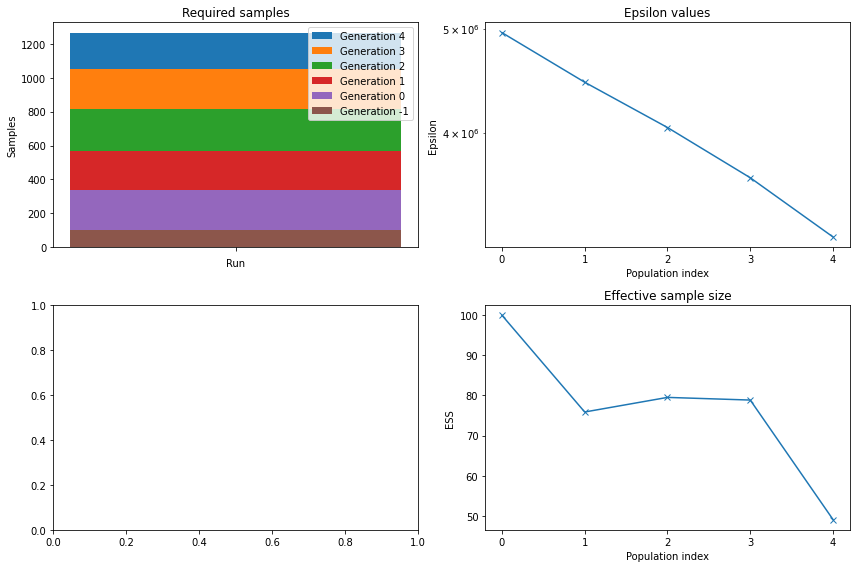

In [28]:
_, arr_ax = plt.subplots(2, 2)

pyabc.visualization.plot_sample_numbers(history, ax=arr_ax[0][0])
pyabc.visualization.plot_epsilons(history, ax=arr_ax[0][1])
#pyabc.visualization.plot_credible_intervals(
#    history, levels=[0.95, 0.9, 0.5], ts=[0, 1, 2, 3, 4],
#    show_mean=True, show_kde_max_1d=True,
#    refval={'mean': 2.5}, 
#    arr_ax=arr_ax[1][0])
pyabc.visualization.plot_effective_sample_sizes(history, ax=arr_ax[1][1])

plt.gcf().set_size_inches((12, 8))
plt.gcf().tight_layout()

Plot the marginal posteriors

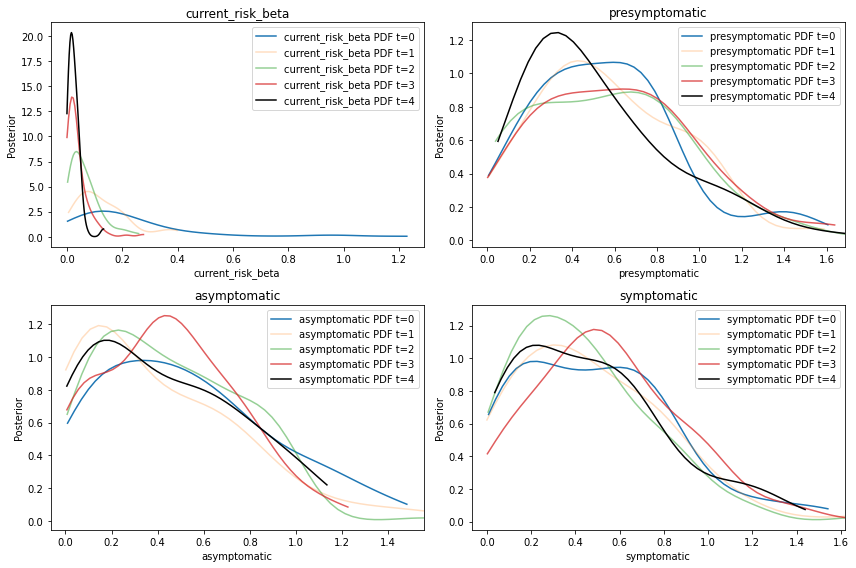

In [29]:
fig, axes = plt.subplots(2,int(len(priors)/2), figsize=(12,8))

#cmap = { 0:'k',1:'b',2:'y',3:'g',4:'r' }  # Do this automatically for len(params)

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"{param} PDF t={t}", 
            alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None # Make the last one black
        ) 
        ax.legend()
        #ax.axvline(x=posterior_df.loc[1,param], color="grey", linestyle="dashed")
        #ax.set_title(f"{param}: {posterior_df.loc[0,param]}")
        ax.set_title(f"{param}")
fig.tight_layout()

In [ ]:
#As above, but this time do a separate plot for each population

#fig, axes = plt.subplots(3,int(history.max_t/2), figsize=(10,8))
#for t in range(history.max_t + 1):
#    ax = axes.flat[t]
#    for i, param in enumerate(priors.keys()):
#        df, w = history.get_distribution(m=0, t=t)
#        pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
#            label=f"{param}")
#    ax.legend()
#    ax.set_title(f"t={t}")
# fig.tight_layout()


Now look at the 2D correlations (_I'm not sure how to read this_)

array([[<AxesSubplot:ylabel='asymptomatic'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='current_risk_beta'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='presymptomatic'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:xlabel='asymptomatic', ylabel='symptomatic'>,
        <AxesSubplot:xlabel='current_risk_beta'>,
        <AxesSubplot:xlabel='presymptomatic'>,
        <AxesSubplot:xlabel='symptomatic'>]], dtype=object)

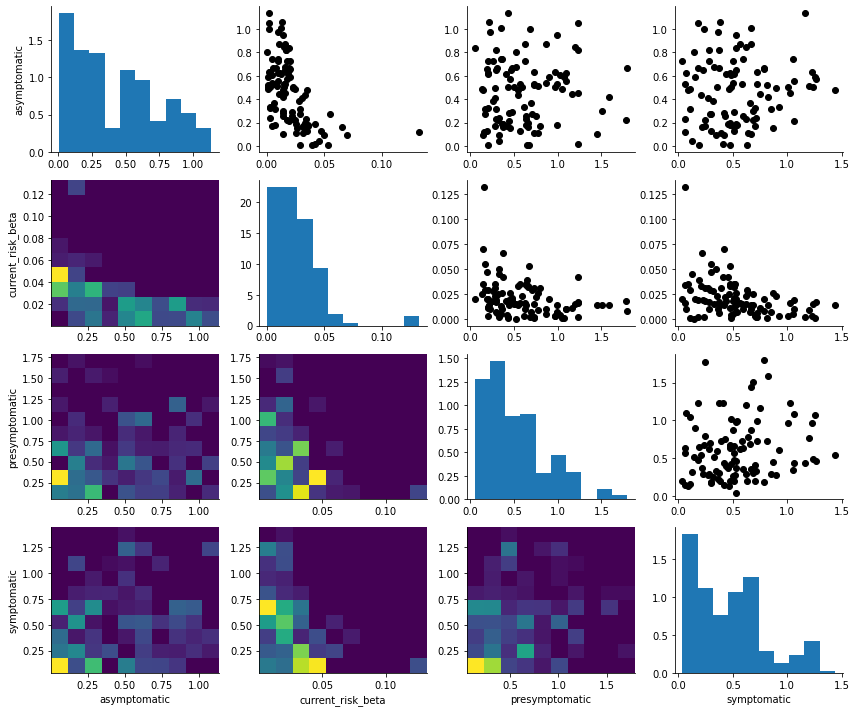

In [30]:
pyabc.visualization.plot_histogram_matrix(history, size=(12,10))

### Analyse the posterior

Have a look at the posterior distribution for the final population. This is made up of the posterior estimates for each particle in the popualtion and the associated weight.

_Note about the distrubtion returned by `get_distribution`_: With each iteration, the algorithm decreases epsilon. So in the end all particles should be within some small distance, epsilon, of the observations. However, within this range, the particles will be randomly distributed. The weight of the particle is a function of the prior and of the number of other particles that are close by, so we wouldn't necessarily expect that particles with high weight should have better fitness than those of low weight. It's just looking at the wrong thing.

In [31]:
_df, _w = history.get_distribution(m=0, t=history.max_t)
# Merge dataframe and weights and sort by weight (highest weight at the top)
_df['weight'] = _w
posterior_df = _df.sort_values('weight', ascending=False).reset_index()
posterior_df

name,id,asymptomatic,current_risk_beta,presymptomatic,symptomatic,weight
0,1603,0.042740,0.045111,0.325037,0.121876,0.087870
1,1585,0.316688,0.028885,0.168118,0.105709,0.044616
2,1526,0.005927,0.028827,0.201941,0.630251,0.034253
3,1594,0.010842,0.039290,0.645905,0.187314,0.034233
4,1535,1.006344,0.012877,0.356416,0.665056,0.024953
...,...,...,...,...,...,...
95,1558,0.476393,0.013946,0.545352,1.438342,0.003883
96,1523,0.554666,0.009757,1.088879,1.059470,0.003784
97,1573,0.415793,0.014398,1.580461,0.824243,0.003127
98,1522,0.664410,0.008093,1.792337,0.788645,0.003113


This code shows how to calculate the fitness associated with each particle (not the correct way to draw from the posterior so not especially useful).

In [32]:
df_fitnesses = []
for i, row in posterior_df.iterrows():
    param_values = { param:row[str(param)] for param in priors}
    (_fitness, _sim, _obs, _out_params, _summaries) = \
          OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
    df_fitnesses.append(_fitness)
    print(f"{i}, Fitness: {_fitness}")
posterior_df['fitness'] = df_fitnesses

Running models:   0%|          | 0/5 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/ramp-ua/lib/python3.7/site-packages/RAMP_UA-1.4.0.dev0-py3.7.egg/microsim/opencl/ramp/params.py:58: UserWarning: Params object is being created using hard-coded default values, not those in the parameters file.
  warnings.warn("Params object is being created using hard-coded default values, "
Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.045111365684051094, 'presymptomatic': 0.32503747240008407, 'asymptomatic': 0.042740475467571704, 'symptomatic': 0.12187630095351965}
0, Fitness: 2326861.195399786


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.01s/it]

.. finished, took 15.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.02888515159535708, 'presymptomatic': 0.16811774593629092, 'asymptomatic': 0.31668841828885264, 'symptomatic': 0.10570922542681271}
1, Fitness: 2597775.8385766004


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.2s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.02882691244214905, 'presymptomatic': 0.20194122383812252, 'asymptomatic': 0.005927348673466976, 'symptomatic': 0.6302513061209721}
2, Fitness: 2432000.092947531


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.03s/it]

.. finished, took 15.14s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.03929030616436956, 'presymptomatic': 0.6459050476028576, 'asymptomatic': 0.010842200633945975, 'symptomatic': 0.18731379320537983}
3, Fitness: 2494656.76566856


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.012876887543317695, 'presymptomatic': 0.35641637315973335, 'asymptomatic': 1.0063436884357546, 'symptomatic': 0.6650563087949156}
4, Fitness: 3008480.6457011816


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.1324237291802144, 'presymptomatic': 0.154773733190764, 'asymptomatic': 0.12097333759115705, 'symptomatic': 0.059153668756092015}
5, Fitness: 3137728.3881950136


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.06s/it]

.. finished, took 15.29s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.03517891586886965, 'presymptomatic': 0.14294711914918282, 'asymptomatic': 0.47602492535594887, 'symptomatic': 0.08288510344755051}
6, Fitness: 2994628.6644947412


Running models: 100%|██████████| 5/5 [00:14<00:00,  3.00s/it]

.. finished, took 15.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.01922313779501524, 'presymptomatic': 0.4394783063325243, 'asymptomatic': 0.21202823523349584, 'symptomatic': 1.0653055738945412}
7, Fitness: 2846605.9523023907


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.21s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.020209167814065506, 'presymptomatic': 0.1988855215902857, 'asymptomatic': 0.7279129056884319, 'symptomatic': 0.03587072486410836}
8, Fitness: 2871238.1069810423


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.94s/it]

.. finished, took 14.73s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.001946114436492923, 'presymptomatic': 0.43664228660280924, 'asymptomatic': 1.1348433426700724, 'symptomatic': 1.1625777910205477}
9, Fitness: 2113181.083783536


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.79s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.0150559281008182, 'presymptomatic': 1.2028463071573465, 'asymptomatic': 0.8489055481139692, 'symptomatic': 0.6199817072763849}
10, Fitness: 3179159.3080180236


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.87s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.033815623914601016, 'presymptomatic': 0.6377530365873518, 'asymptomatic': 0.23292972651358196, 'symptomatic': 0.058042339246023464}
11, Fitness: 2788663.143411581


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.04753903325067881, 'presymptomatic': 0.19182112305628657, 'asymptomatic': 0.13223703694617184, 'symptomatic': 0.29467198671610606}
12, Fitness: 2762614.998641092


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.002971708497616351, 'presymptomatic': 0.19791607976215703, 'asymptomatic': 0.3226073232075922, 'symptomatic': 0.7072534338441597}
13, Fitness: 2018219.3853774967


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.6s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.00021252813642878843, 'presymptomatic': 0.5252550348761845, 'asymptomatic': 0.8017154136674067, 'symptomatic': 0.14713088904436847}
14, Fitness: 1935647.218805865


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.33s/it]

.. finished, took 16.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.014233547883454286, 'presymptomatic': 0.9862088956418767, 'asymptomatic': 0.9437914075768383, 'symptomatic': 0.5332448521124813}
15, Fitness: 3124868.911707306


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.01689035608640417, 'presymptomatic': 1.2276891263473622, 'asymptomatic': 0.8187722270354348, 'symptomatic': 0.367919427301574}
16, Fitness: 3177360.2685317444


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.009941149952041851, 'presymptomatic': 1.094650075481369, 'asymptomatic': 0.6211092786971519, 'symptomatic': 0.06888031166380595}
17, Fitness: 2510424.3312645853


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.013726201672957912, 'presymptomatic': 0.20958596325782067, 'asymptomatic': 1.0596897656245674, 'symptomatic': 0.3824331074286338}
18, Fitness: 2970522.617926603


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.0024373816117661904, 'presymptomatic': 0.683839569515083, 'asymptomatic': 0.99719263771458, 'symptomatic': 0.2310365203997597}
19, Fitness: 2087054.3390036207


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.16s/it]

.. finished, took 15.81s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.007369649727679695, 'presymptomatic': 0.9871722701848122, 'asymptomatic': 0.17593954442922258, 'symptomatic': 0.5386408572459015}
20, Fitness: 2201315.898716356


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.4s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.017684798353489187, 'presymptomatic': 0.4605400649875453, 'asymptomatic': 0.5679593144646674, 'symptomatic': 1.2663475870247973}
21, Fitness: 3193647.054360948


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.0026571057757836074, 'presymptomatic': 0.33029906533762415, 'asymptomatic': 0.24313634851188068, 'symptomatic': 0.7131121124449575}
22, Fitness: 2004036.8323505635


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.12s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.0044199438289105955, 'presymptomatic': 0.42058125063870005, 'asymptomatic': 0.1683017346081797, 'symptomatic': 0.7051030613062397}
23, Fitness: 2054717.316415482


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.01634236289496319, 'presymptomatic': 0.6254603108149751, 'asymptomatic': 0.8666494545524273, 'symptomatic': 0.5642554990668796}
24, Fitness: 3135411.5273476816


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.0012493068254432731, 'presymptomatic': 1.047256626383232, 'asymptomatic': 0.4865056120068096, 'symptomatic': 0.10461402282330023}
25, Fitness: 1988539.2473743935


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.06580233501824188, 'presymptomatic': 0.3701421513758102, 'asymptomatic': 0.1655103322341052, 'symptomatic': 0.21504497811295914}
26, Fitness: 3176343.8101537875


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.031496821708337785, 'presymptomatic': 0.8012820131442686, 'asymptomatic': 0.16799016723660076, 'symptomatic': 0.24512618583457332}
27, Fitness: 2844473.5670804325


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.010610265824708382, 'presymptomatic': 0.8710656550969061, 'asymptomatic': 0.87212967718834, 'symptomatic': 0.6702885583257069}
28, Fitness: 2863729.2260004818


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.17s/it]

.. finished, took 15.86s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.015176541337874803, 'presymptomatic': 0.4963249749040066, 'asymptomatic': 0.5023067438988001, 'symptomatic': 1.2401405268861099}
29, Fitness: 3012010.9046235937


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.94s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.05013508513301447, 'presymptomatic': 0.3327561439250095, 'asymptomatic': 0.09796164316408651, 'symptomatic': 0.3456741450047607}
30, Fitness: 2886434.4860635796


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.010354881324577833, 'presymptomatic': 0.22738464725232432, 'asymptomatic': 0.9715749239130478, 'symptomatic': 0.36279283368113613}
31, Fitness: 2693856.4051975156


Running models: 100%|██████████| 5/5 [00:14<00:00,  2.98s/it]

.. finished, took 14.92s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.007679421575100279, 'presymptomatic': 0.2901904640461982, 'asymptomatic': 0.31615348730156323, 'symptomatic': 0.8552264337991513}
32, Fitness: 2246716.5979835014


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.02s/it]

.. finished, took 15.11s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.0198262011636371, 'presymptomatic': 0.05043361755944184, 'asymptomatic': 0.8324349205285674, 'symptomatic': 0.5251865418456092}
33, Fitness: 3114815.0171023123


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.07s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.031386068461078095, 'presymptomatic': 0.7286738470092707, 'asymptomatic': 0.10988280646495158, 'symptomatic': 0.3900896810663183}
34, Fitness: 2809452.2463392825


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.67s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.005020462756178075, 'presymptomatic': 0.3542207075749977, 'asymptomatic': 0.7450833254649282, 'symptomatic': 1.052590143830341}
35, Fitness: 2303992.0272133844


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.04s/it]

.. finished, took 15.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.014554351341518102, 'presymptomatic': 1.4465803476341645, 'asymptomatic': 0.09861327119321438, 'symptomatic': 0.667356208847744}
36, Fitness: 2604988.979110361


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.09s/it]

.. finished, took 15.47s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.053424439901030255, 'presymptomatic': 0.6709052066805274, 'asymptomatic': 0.009456296247112417, 'symptomatic': 0.476512500399599}
37, Fitness: 3064353.92907989


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.11s/it]

.. finished, took 15.56s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.02273694333663471, 'presymptomatic': 0.28084546159139195, 'asymptomatic': 0.497071738140325, 'symptomatic': 0.8982191116748831}
38, Fitness: 3164520.1895371755


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

.. finished, took 15.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.01950746411983317, 'presymptomatic': 0.2964658839594008, 'asymptomatic': 0.6486608865931976, 'symptomatic': 0.22479835185555752}
39, Fitness: 2885210.78612936


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.00s/it]

.. finished, took 15.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.002425122862010156, 'presymptomatic': 0.7243932305310268, 'asymptomatic': 0.6299371607749189, 'symptomatic': 0.7194658610580866}
40, Fitness: 2073237.9146910084


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.38s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.01947034381386909, 'presymptomatic': 0.4814950625840286, 'asymptomatic': 0.6625918573213242, 'symptomatic': 0.17846082509691746}
41, Fitness: 2934603.72152668


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.01455440528657284, 'presymptomatic': 0.4443612974907272, 'asymptomatic': 0.27994720327994826, 'symptomatic': 0.4192511316613442}
42, Fitness: 2409992.149533778


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.28s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.01006018392270417, 'presymptomatic': 0.6225055077639688, 'asymptomatic': 0.7273431109444117, 'symptomatic': 0.2802270938508526}
43, Fitness: 2566387.5188458506


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.18s/it]

.. finished, took 15.9s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.004658074440368316, 'presymptomatic': 1.0255986991949149, 'asymptomatic': 0.6052809957864652, 'symptomatic': 0.4825472645268765}
44, Fitness: 2205375.9907508017


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.15s/it]

.. finished, took 15.74s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.0057667878405484735, 'presymptomatic': 0.3075652246821047, 'asymptomatic': 0.669666526179415, 'symptomatic': 0.3742816348015456}
45, Fitness: 2198971.332619914


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.65s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.016159658067931848, 'presymptomatic': 0.5668190089496186, 'asymptomatic': 0.5318907618095995, 'symptomatic': 0.06396400940282412}
46, Fitness: 2625727.8854764597


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.05s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.054671960088777824, 'presymptomatic': 0.17209223792287218, 'asymptomatic': 0.27002466529813396, 'symptomatic': 0.2981857360246269}
47, Fitness: 3203258.0781770484


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.002855070204485957, 'presymptomatic': 0.9706464677036253, 'asymptomatic': 0.6349957283614605, 'symptomatic': 1.2318882409816443}
48, Fitness: 2161151.2091851323


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.25s/it]

.. finished, took 16.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.017273686774137813, 'presymptomatic': 0.29376371801907564, 'asymptomatic': 0.8164311341984561, 'symptomatic': 0.2820646322812196}
49, Fitness: 2969846.5769054736


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.13s/it]

.. finished, took 15.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.026678347802408547, 'presymptomatic': 0.4569502653131944, 'asymptomatic': 0.15287947877188415, 'symptomatic': 0.8648274395946645}
50, Fitness: 2946784.3243853054


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.58s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.027781297171511978, 'presymptomatic': 0.26039482386656754, 'asymptomatic': 0.3847409179203986, 'symptomatic': 0.3148001434475006}
51, Fitness: 2896681.6278842036


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.93s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.02034324543224496, 'presymptomatic': 0.1932483341489186, 'asymptomatic': 0.6546262792922022, 'symptomatic': 0.7882125973580775}
52, Fitness: 3143161.3739203587


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.28s/it]

.. finished, took 16.42s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.0311435678606233, 'presymptomatic': 0.28767910095327487, 'asymptomatic': 0.4106084206108069, 'symptomatic': 0.2686752346040716}
53, Fitness: 3008041.6474663178


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.61s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.010207306374695354, 'presymptomatic': 0.35983676980384083, 'asymptomatic': 0.7423520441480276, 'symptomatic': 0.5921959601341948}
54, Fitness: 2629818.222348176


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.14s/it]

.. finished, took 15.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.029334007331230517, 'presymptomatic': 0.7097925130022283, 'asymptomatic': 0.2695586632914645, 'symptomatic': 0.2899161990617727}
55, Fitness: 2945414.636290578


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.12s/it]

.. finished, took 15.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.01395078359099189, 'presymptomatic': 1.5085290807188503, 'asymptomatic': 0.2991319445723096, 'symptomatic': 0.6821493313778662}
56, Fitness: 2797841.301801952


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.015635544827019274, 'presymptomatic': 0.5207323904890212, 'asymptomatic': 0.6705129672815737, 'symptomatic': 0.3242976929489285}
57, Fitness: 2842511.0058018914


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.03566489090843651, 'presymptomatic': 0.28321935536221565, 'asymptomatic': 0.167144280120277, 'symptomatic': 0.5220625378118069}
58, Fitness: 2897759.796306478


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.57s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.019970767091527755, 'presymptomatic': 0.8948082433679027, 'asymptomatic': 0.590261260930903, 'symptomatic': 0.15561408963792775}
59, Fitness: 2994186.1846302813


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.35s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.07011337583012454, 'presymptomatic': 0.15162312756245205, 'asymptomatic': 0.09315861823897925, 'symptomatic': 0.4161885349294808}
60, Fitness: 3089239.576776033


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.22s/it]

.. finished, took 16.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.03332310243927579, 'presymptomatic': 0.5492971089052137, 'asymptomatic': 0.43201412025718655, 'symptomatic': 0.20375012152189131}
61, Fitness: 3146377.006369993


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.46s/it]

.. finished, took 17.32s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.0009586290698407052, 'presymptomatic': 1.0710450218441525, 'asymptomatic': 0.5875738276305035, 'symptomatic': 1.2528145369151324}
62, Fitness: 2020119.1994295584


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]

.. finished, took 17.5s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.042278386496567566, 'presymptomatic': 1.2298659522460746, 'asymptomatic': 0.01567780001397468, 'symptomatic': 0.41215294590501605}
63, Fitness: 3110855.0880309874


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.02588743259906116, 'presymptomatic': 0.3689347577316701, 'asymptomatic': 0.18436926947634552, 'symptomatic': 0.5258616325548859}
64, Fitness: 2718457.7123461384


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.57s/it]

.. finished, took 17.83s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.016153976760207564, 'presymptomatic': 0.46925372348747524, 'asymptomatic': 0.6509645933405532, 'symptomatic': 0.5296110542275501}
65, Fitness: 2920124.819001414


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.69s/it]

.. finished, took 18.45s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.0064526407881760825, 'presymptomatic': 0.9936215452780287, 'asymptomatic': 0.5333646692707945, 'symptomatic': 0.7191816031969751}
66, Fitness: 2352406.7150009586


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it]

.. finished, took 17.26s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.023201188476736724, 'presymptomatic': 0.2924578810034323, 'asymptomatic': 0.23325803796024858, 'symptomatic': 0.6183111437990026}
67, Fitness: 2734730.9846857917


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.21s/it]

.. finished, took 16.03s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.005138245196965808, 'presymptomatic': 0.8710443574924206, 'asymptomatic': 0.5372899885745166, 'symptomatic': 0.4994766147812738}
68, Fitness: 2204955.5136362733


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.62s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.002840911096906701, 'presymptomatic': 0.6108363902233929, 'asymptomatic': 0.3352958491294673, 'symptomatic': 0.9286577695985193}
69, Fitness: 2067950.2294549837


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.30s/it]

.. finished, took 16.52s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.0012888305967608572, 'presymptomatic': 0.43333896420153184, 'asymptomatic': 0.501826106007443, 'symptomatic': 0.47870454032359294}
70, Fitness: 1983312.0709752764


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.64s/it]

.. finished, took 18.19s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.010809654449758442, 'presymptomatic': 1.1586657548777957, 'asymptomatic': 0.4401981228316324, 'symptomatic': 0.749362563277483}
71, Fitness: 2666633.1281292895


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]

.. finished, took 17.49s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.001999988470540233, 'presymptomatic': 1.2295940356989887, 'asymptomatic': 1.0521072615814502, 'symptomatic': 0.17613850791143915}
72, Fitness: 2082561.9815544796


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.60s/it]

.. finished, took 18.01s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.02577458163584461, 'presymptomatic': 0.7782766006299224, 'asymptomatic': 0.11496731327783208, 'symptomatic': 0.6389975525451107}
73, Fitness: 2851193.945695978


Running models: 100%|██████████| 5/5 [00:18<00:00,  3.65s/it]

.. finished, took 18.27s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.009115892810561764, 'presymptomatic': 0.7731610656350303, 'asymptomatic': 0.5131961945556132, 'symptomatic': 1.2036296881276844}
74, Fitness: 2646922.236218684


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]

.. finished, took 17.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.014736893209905637, 'presymptomatic': 0.7342262714823937, 'asymptomatic': 0.5280208623357643, 'symptomatic': 0.5840262116253543}
75, Fitness: 2828600.011758191


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.37s/it]

.. finished, took 16.84s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.02497590852097197, 'presymptomatic': 0.3144216370573895, 'asymptomatic': 0.21853239849849132, 'symptomatic': 0.6816639640748268}
76, Fitness: 2820915.404548077


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

.. finished, took 16.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.018007080209965606, 'presymptomatic': 0.2636905539016955, 'asymptomatic': 0.7297406730830003, 'symptomatic': 0.49902815214759616}
77, Fitness: 3009184.8555592326


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

.. finished, took 16.77s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.02194738365396655, 'presymptomatic': 0.7558095835193573, 'asymptomatic': 0.253204353697986, 'symptomatic': 0.43041679588549403}
78, Fitness: 2793066.2535533668


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.40s/it]

.. finished, took 17.0s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.011252166860898579, 'presymptomatic': 0.20082317661114593, 'asymptomatic': 0.6228350347653027, 'symptomatic': 0.4777213220250043}
79, Fitness: 2529863.34027634


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.53s/it]

.. finished, took 17.64s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.022852263374714205, 'presymptomatic': 0.5966759177589395, 'asymptomatic': 0.5052996833581165, 'symptomatic': 0.35814922626050305}
80, Fitness: 3027826.9832421006


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.44s/it]

.. finished, took 17.18s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.0419258020436082, 'presymptomatic': 0.37611471066614793, 'asymptomatic': 0.1908980422635863, 'symptomatic': 0.4562017053914035}
81, Fitness: 3085939.871775191


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.40s/it]

.. finished, took 16.98s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.02481530173599702, 'presymptomatic': 0.13713259059097177, 'asymptomatic': 0.48459154985219693, 'symptomatic': 0.46817063625106825}
82, Fitness: 2976534.633735942


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.03555397584180604, 'presymptomatic': 0.6349298980783324, 'asymptomatic': 0.18374051385771703, 'symptomatic': 0.47307047042679196}
83, Fitness: 3065474.427200488


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.26s/it]

.. finished, took 16.31s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.012583404979900995, 'presymptomatic': 0.20526587196003115, 'asymptomatic': 0.6128929300516454, 'symptomatic': 0.5092738420453621}
84, Fitness: 2613503.2838532804


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.7s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.03343388322984826, 'presymptomatic': 0.6650015168246053, 'asymptomatic': 0.19525217415166857, 'symptomatic': 0.477839816615031}
85, Fitness: 3048894.4451741786


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.42s/it]

.. finished, took 17.09s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.03479457960800833, 'presymptomatic': 0.569439292211148, 'asymptomatic': 0.12773296470096834, 'symptomatic': 0.5115592551775167}
86, Fitness: 2949284.811974015


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.32s/it]

.. finished, took 16.59s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.018689728575141673, 'presymptomatic': 0.40708612888648493, 'asymptomatic': 0.611371641335924, 'symptomatic': 0.4388376868849722}
87, Fitness: 2952697.167887076


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.33s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.03191341345744627, 'presymptomatic': 0.6589160301188912, 'asymptomatic': 0.1593346556330686, 'symptomatic': 0.5141185645735555}
88, Fitness: 2970071.4064135496


Running models: 100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

.. finished, took 15.95s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.0013887729552923647, 'presymptomatic': 0.7345090743054841, 'asymptomatic': 0.5208132135312256, 'symptomatic': 0.8115158090649295}
89, Fitness: 2016005.1536665675


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.35s/it]

.. finished, took 16.75s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.01802420049453575, 'presymptomatic': 1.7743527833151131, 'asymptomatic': 0.22168313220230002, 'symptomatic': 0.2400146948538734}
90, Fitness: 2798783.004412868


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.31s/it]

.. finished, took 16.54s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.021668984289817915, 'presymptomatic': 0.4748581208995811, 'asymptomatic': 0.2935330810682471, 'symptomatic': 0.5118512214177399}
91, Fitness: 2779282.340433494


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.29s/it]

.. finished, took 16.48s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.014564898373399405, 'presymptomatic': 0.634454937529281, 'asymptomatic': 0.25511542112932745, 'symptomatic': 0.5971163782026884}
92, Fitness: 2532927.7765073525


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.34s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.0030065633062660822, 'presymptomatic': 0.9696034392582438, 'asymptomatic': 0.49971527319220665, 'symptomatic': 1.0042110740089223}
93, Fitness: 2129544.6229600543


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.27s/it]

.. finished, took 16.37s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.006864467192236165, 'presymptomatic': 0.689312749387591, 'asymptomatic': 0.3691548250158596, 'symptomatic': 0.6602727798774833}
94, Fitness: 2248063.606154479


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.15s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.01394609670030616, 'presymptomatic': 0.5453523641967365, 'asymptomatic': 0.47639256009125774, 'symptomatic': 1.4383417166502335}
95, Fitness: 2992196.7578516155


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it]

.. finished, took 16.72s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.009756837900819715, 'presymptomatic': 1.0888790607763514, 'asymptomatic': 0.5546661081686971, 'symptomatic': 1.0594703721110474}
96, Fitness: 2742631.7887477567


Running models: 100%|██████████| 5/5 [00:16<00:00,  3.38s/it]

.. finished, took 16.91s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.014398042907682223, 'presymptomatic': 1.5804613376087897, 'asymptomatic': 0.41579320138384723, 'symptomatic': 0.8242427833240282}
97, Fitness: 2985018.251553735


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.43s/it]

.. finished, took 17.16s)



Running models:   0%|          | 0/5 [00:00<?, ?it/s]

Ran Model with {'current_risk_beta': 0.008092719008515986, 'presymptomatic': 1.7923373224325159, 'asymptomatic': 0.6644096757815601, 'symptomatic': 0.7886454045174465}
98, Fitness: 2700192.6864091237


Running models: 100%|██████████| 5/5 [00:17<00:00,  3.50s/it]

.. finished, took 17.49s)
Ran Model with {'current_risk_beta': 0.015846744601835713, 'presymptomatic': 1.2348710405281693, 'asymptomatic': 0.45426616632012773, 'symptomatic': 1.0237766710216811}
99, Fitness: 3091734.539322301


Text(0, 0.5, 'Fitness')

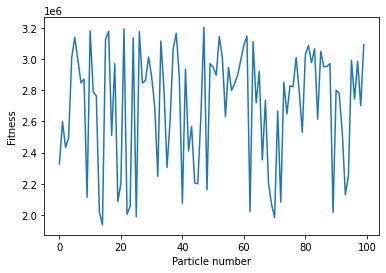

In [33]:
plt.plot(range(len(posterior_df)), posterior_df['fitness'])
plt.xlabel("Particle number")
plt.ylabel("Fitness")

Text(0, 0.5, 'Weight')

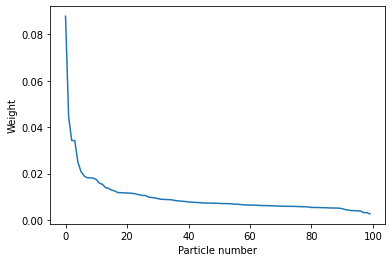

In [34]:
plt.plot(range(len(posterior_df)), posterior_df['weight'])
plt.xlabel("Particle number")
plt.ylabel("Weight")

Now we have a posterior over the parameters. There are two ways to find the 'optimal' model:

 - Find the posterior mode (i.e. the set of parameters that gave the result that was the most likely to have generated the observations). This is useful because then the 'optimal' parameters can be reported and these can be set as the default for future model runs (i.e. a traditional calibration).
 
 - Sample from the posterior distribution N times (N=100?) to generate a posterior over the model outputs. This better captures the uncertainty in the parameter values and in the associated model outputs.


#### ABC Posterior (A) - Sample

Sample from the distribution of parameter posteriors to generate a distribution over the mode likely model results. Use kernel density approximation to randomly draw some equally weighted samples.

(This is kind of pointless as we already know what the parameter posteriors are, but we could use this mechanism to make predictions from the model).

In [ ]:
N_samples = 100
df, w = history.get_distribution(m=0, t=history.max_t)

# Sample from the dataframe of posteriors using KDE
kde = MultivariateNormalTransition(scaling=1)
kde.fit(df, w)
samples = kde.rvs(N_samples)

## Instead sample just using the weights (this isn't the best way to do it though, should use KDE)
#df = df.reset_index()  # So that the row index is 0-N (currently it's something else)
#sample_idx = np.random.choice(
#            a=range(history.get_nr_particles_per_population().values[-1]),
#            size=N_samples, replace=True, p=w)
#samples = df.iloc[sample_idx] 

# Now run N models and store the results of each one
fitness_l = []  # Fitness values for each sample (model)
sim_l = []  # The full simulation results
obs_l = []  # Observations (should be the same for each sample)
out_params_l = []  # The parameters objects used in each sample (all parameters in the model)
out_calibrated_params_l = []  # The values of the specific calibrated parameters for the sample
summaries_l = []  # The summaries objects

for i, sample in samples.iterrows():

    # Check for negatives. If needed, resample
    while (sample < 0).values.any():
        print("Found negatives. Resampling")
        sample = kde.rvs()
        
    # Create a dictionary with the parameters and their values for this sample
    param_values = { param:sample[str(param)] for param in priors}
    
    # Run the model
    (_fitness, _sim, _obs, _out_params, _summaries) = \
          OpenCLRunner.run_model_with_params_abc(param_values, return_full_details=True)
    print(f"Fitness: {_fitness}.")
    #print(f"Fitness: {_fitness}. Sample: {sample}")
    
    fitness_l.append(_fitness)
    sim_l.append(_sim)
    obs_l.append(_obs)
    out_params_l.append(_out_params)
    out_calibrated_params_l.append(param_values)
    summaries_l.append(_summaries)

# Sanity check
for i in range(len(obs_l)-1):
    assert np.array_equal(obs_l[0], obs_l[i])
    
# Save these because it took ages to sample
def pickle_samples(mode, *arrays):
    if mode=="save":
        with open("abc-1-samples.pkl", "wb") as f:
            for x in arrays:
                pickle.dump(x, f)
        return
    elif mode=="load":
        with open("abc-1-samples.pkl", "rb") as f:
            fitness_l = pickle.load(f)
            sim_l = pickle.load(f)
            obs_l = pickle.load(f)
            out_params_l = pickle.load(f)
            out_calibrated_params_l = pickle.load(f)
            summaries_l = pickle.load(f)
        return( fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)
    else:
        raise Exception(f"Unkonwn mode: {mode}")
pickle_samples('save', fitness_l, sim_l, obs_l, out_params_l, out_calibrated_params_l, summaries_l)

Plot the individual results for each sample

In [ ]:
#print(f"Original fitness: {round(fitness0)}\nOptimised fitness: {round(fitness)}")

# Normalise fitness to 0-1 to calculate transparency
_fitness = np.array(fitness_l)  # Easier to do maths on np.array
fitness_norm = (_fitness-min(_fitness))/(max(_fitness)-min(_fitness))

fig, ax = plt.subplots(1,1, figsize=(12,8))
x = range(len(sim_l[0]))
for i in range(len(summaries_l)):
    ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries_l[i]),
            #label=f"Particle {df.index[sample_idx[i]]}", 
            color="black", alpha = 1-fitness_norm[i]  # (1-x because high fitness is bad)
    )
    
    #ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"Fitness {round(fitness_l[i])}", fontsize=8)
    #ax.text(x=len(sim_l[i]), y=sim_l[i][-1], s=f"P{df.index[sample_idx[i]]}, F{round(fitness_l[i])}", fontsize=8)
ax.plot(x, obs_l[0], label="Observations")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim")
ax.legend()
#plot_summaries(summaries=summaries_l[0], plot_type="error_bars", observations=OBSERVATIONS)

del _fitness, fitness_norm

Plot the kde of the sample results (a bit like the posterior?). See the [pygam documentation](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html) for the GAM code to do this.

_The prediction intervals clearly aren't working_

In [ ]:
# Make two long arrays with every result from every particle
x = list(range(len(sim_l[0])))  # List of iteration numbers
X = []
for _iter in x * len(summaries_l):  # One sequence of iterations (0-100) for each particle
    X.append([_iter]) # (The x list is odd because every element in the list needs to be a 1-element list)
X = np.array(X)
y = []
for i in range(len(summaries_l)):
    y += list(OpenCLRunner.get_cumulative_new_infections(summaries_l[i]))
y = np.array(y)

# Generate the GAM
gam = LinearGAM( n_splines=250)
#gam = LinearGAM( s(0, n_splines=250) )  # Linear GAM with a spline function on feature 0
gam.gridsearch(X, y)
#XX = gam.generate_X_grid(term=0, n=len(X))
XX = gam.generate_X_grid(term=0)

# Plot
fig, ax = plt.subplots(1,1, figsize=(12,8))

ax.plot(XX, gam.predict(XX), 'r--')
ax.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--')

#pdep, confi = gam.partial_dependence(term=0, width=.95)
#ax.plot(XX, pdep)
#ax.plot(XX, confi, c='r', ls='--')

ax.plot(x, obs_l[0], label="Observations")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim")
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.legend()
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.set_title('95% prediction interval');

Do a KDE plot with a logarithmic colour scale.

_Looks like the distribution is multi-model_

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,7))

h = ax.hist2d(x=[x[0] for x in X], y=y, bins=int(len(x)/5),
         norm=LogNorm())

ax.set_xlabel("Iteration")
ax.set_ylabel("Cumulative cases")

ax.plot(x, obs_l[0], label="Observations")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="Initial sim")
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.legend()
fig.colorbar(h[3], ax=ax)
#plt.scatter(X, y, facecolor='gray', edgecolors='none')
ax.set_title('Density plot of results posterior');

#### ABC Posterior (B) - Find the Mode(s)

_I can't work out how to find the modes (basically I think I need the largest value of the `kde`?) so instead just choose the parameter values from the best sample_

Find the 'optimal' parameters

In [ ]:
# Load samples if needed
#fitness_l, sim_l, obs_l, out_params_l, summaries_l = pickle_samples("load")

# Find the best parameters
best_model_idx = np.argmin(fitness_l)
best_params = out_calibrated_params_l[best_model_idx]
# Sanity check, the calibrated param should be the same as the one in the params object
assert np.isclose(out_calibrated_params_l[best_model_idx]['presymptomatic'],
                  out_params_l[best_model_idx].individual_hazard_multipliers[0])
best_params

See how those parameters relate to the marginal posteriors

In [ ]:
fig, axes = plt.subplots(2,int(len(priors)/2), figsize=(12,8))

for i, param in enumerate(priors.keys()):
    ax = axes.flat[i]
    df, w = history.get_distribution(m=0, t=history.max_t)
    pyabc.visualization.plot_kde_1d(df, w, x=param, ax=ax, 
            label=f"{param} PDF t={t}", 
            alpha=1.0 if t==0 else float(t)/history.max_t, # Make earlier populations transparent
            color= "black" if t==history.max_t else None # Make the last one black
        )
    ax.legend()
    ax.axvline(x=best_params[param], color="grey", linestyle="dashed")
    ax.text(x=best_params[param], y=0.9*ax.get_ylim()[1], s=str(round(best_params[param],3)), fontsize=12)
    ax.set_title(f"{param}")
fig.suptitle("Optimal parameter values")
fig.tight_layout()

Run the model with those parameters

In [ ]:
OpenCLRunner.update(store_detailed_counts=True)  # Temporarily output age breakdowns
(fitness1, sim1, obs1, out_params1, summaries1) = OpenCLRunner.run_model_with_params_abc(
    best_params, return_full_details=True)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

# Check the model returns the observations correctly (should be same as initial, default model)
np.array_equal(obs0, obs1)

# Print the fitness and plot the different disease counts
print(f"Fitness: {fitness1}")
#print(pd.DataFrame({"sim":sim, "real_obs1":obs}))

fig, ax = plt.subplots(1,1)
x = range(len(sim1))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="sim0")
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries1), label="sim1")
ax.plot(x, obs1, label="obs")
ax.legend()


## Spatial analysis of the posterior

We've seen how the aggregate, cumulative disease count varies, but how do the results vary over space?



Look at the distribtion of explosed people in the optimal model

In [35]:
N=len(summaries1)
disease_status = "exposed"

fig, axes = plt.subplots(nrows=2, ncols=int(N/2) if (N % 2) == 0 else int(N/2)+1,
                    figsize=(12,8))

for i in range(N):
    #idx = indices[i]
    ax = axes.flat[i]
    plot_msoa_choropleth(devon_msoa_shapes, summaries1[i], disease_status, 99, ax=ax)
    ax.set_title(f"Run {i}")

NameError: name 'summaries1' is not defined

XXXX HERE there is too much spatial variation? Might need to reduce impact of workplace interactions. Or maybe this is interesting. 